# Transcription Factor Project - QC Testing
**Robin Anwyl, UCSD Subramaniam Lab**

**Goal:** Analyze the hiPSC Perturb-seq dataset from the Mali lab (Nourreddine et al preprint) to investigate the effects of transcription factor knockouts (TF KOs)

**Guiding Questions:** What do TF KO effects reveal about:
* … the transcription regulatory network of hiPSCs, and TF crosstalk?
* … cell lineage?
* … how TFs influence chromatin remodeling?

**Notebook Description:** Testing lack of TF KO overlap when using different random seeds

***

# Import statements and global random seed

In [2]:
import muon as mu
import anndata as ad
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3
import scipy as sp
#import re
#import requests
import gc
from plotnine import ggplot, aes, geom_bar, ggtitle, xlab, ylab, scale_fill_manual, geom_histogram, labs, theme, element_text, scale_y_continuous
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from tqdm.auto import tqdm
from statsmodels.stats.multitest import multipletests
from scipy.stats import mannwhitneyu
from scipy.stats import ks_2samp
from scipy.stats import gamma
from scipy.stats import spearmanr
import seaborn as sns
import dcor
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib
from joblib import delayed, parallel_backend, Parallel
import networkx as nx
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.default_inference import DefaultInference
import openpyxl
from IPython.display import display  #type: ignore
from scipy.spatial.distance import pdist, squareform #type: ignore
import plotly.express as px #type: ignore
import plotly.graph_objects as go #type: ignore
import pymde #type: ignore
import plotly.io as pio #type: ignore
from sklearn.preprocessing import StandardScaler #type: ignore
from sklearn.neighbors import kneighbors_graph #type: ignore
from sklearn.manifold import SpectralEmbedding
import igraph as ig #type: ignore
import leidenalg #type: ignore
import sys
import os
sys.path.insert(0, "/home/ranwyl/data_tf_project/")
import perturb_seq_heuristic_pipeline as qc
import pan_genome_analysis_functions as qc2

# Set global random seed as safety measure for reproducibility
np.random.seed(92093)

# Summer + Fall Week 0

In [2]:
# List of 1639 TFs from Lambert et al (2018)
lambert_csv = pd.read_csv("Lambert_2018_TFs.csv")
tfs = lambert_csv[lambert_csv.iloc[:,3] == "Yes"].iloc[:,1].tolist()
tfs = set(tfs)

def filter_tf_ko_and_ntc(adata):
    """
    Filter for TF KO and NTC cells.
    """
    return adata[(adata.obs["gene_target"].isin(tfs)) | (adata.obs["gene_target"] == "NTC")].copy()

def get_tf_kos_3_batches(tf_set, adata1, adata2, adata3):
    """
    Return set of unique TF KOs present in union of 3 datasets.
    """
    tf_kos = set()
    for adata in (adata1, adata2, adata3):
        adata_kos = set(adata.obs["gene_target"].unique().tolist())
        adata_tf_kos = tf_set & adata_kos # Gene targets that are in TF set
        tf_kos.update(set(adata_tf_kos))
    return tf_kos

In [ ]:
def plot_venn(set1, set2, label1, label2, title=None, color1="red", color2="green"):
    plt.rcParams['font.size'] = 16
    n_items1, n_items2 = len(set1), len(set2)
    n_shared = len([g for g in set2 if g in set1])
    left = n_items1 - n_shared
    right = n_items2 - n_shared
    venn2(subsets = (left, right, n_shared), 
        set_labels = (label1, label2),
        set_colors = (color1, color2),
        alpha=0.4)
    if title:
        plt.title(title, fontsize=18)
    plt.show()

In [4]:
def plot_venn3(set1, set2, set3, label1, label2, label3, title=None, color1="red", color2="green", color3="blue"):
    plt.rcParams['font.size'] = 14
    venn3(subsets=[set1, set2, set3], 
          set_labels=(label1, label2, label3), 
          set_colors=(color1, color2, color3), alpha=0.4)
    if title:
        plt.title(title, fontsize=18)
    plt.show()

## Steps E and F

### Step E output

In [25]:
# Datasets processed with RNG-modified code for Sept 12
stepE_alpha_mod_sept12 = sc.read_h5ad("/home/ranwyl/data_tf_project/step_E_output_ALPHA.h5ad", backed='r')
stepE_beta_mod_sept12 = sc.read_h5ad("/home/ranwyl/data_tf_project/step_E_output_BETA.h5ad", backed='r')
stepE_gamma_mod_sept12 = sc.read_h5ad("/home/ranwyl/data_tf_project/step_E_output_GAMMA.h5ad", backed='r')

In [26]:
stepE_tf_kos_mod_sept12 = get_tf_kos_3_batches(tfs, stepE_alpha_mod_sept12, stepE_beta_mod_sept12, stepE_gamma_mod_sept12)

In [27]:
# Datasets processed with original code and random seed
stepE_alpha_seed = sc.read_h5ad("/home/ranwyl/data_tf_project/step_E_output_ALPHA_1randseed.h5ad", backed="r")
stepE_beta_seed = sc.read_h5ad("/home/ranwyl/data_tf_project/step_E_output_BETA_1randseed.h5ad", backed="r")
stepE_gamma_seed = sc.read_h5ad("/home/ranwyl/data_tf_project/step_E_output_GAMMA_1randseed.h5ad", backed="r")

In [28]:
stepE_tf_kos_seed = get_tf_kos_3_batches(tfs, stepE_alpha_seed, stepE_beta_seed, stepE_gamma_seed)

In [29]:
# Datasets processed with RNG-modified code for Sept 26th
stepE_alpha_mod_sept26 = sc.read_h5ad("/home/ranwyl/data_tf_project/step_E_output_ALPHA_final.h5ad", backed='r')
stepE_beta_mod_sept26 = sc.read_h5ad("/home/ranwyl/data_tf_project/step_E_output_BETA_final.h5ad", backed='r')
stepE_gamma_mod_sept26 = sc.read_h5ad("/home/ranwyl/data_tf_project/step_E_output_GAMMA_final.h5ad", backed='r')

In [30]:
stepE_tf_kos_mod_sept26 = get_tf_kos_3_batches(tfs, stepE_alpha_mod_sept26, 
                                         stepE_beta_mod_sept26, stepE_gamma_mod_sept26)

In [31]:
print("After Step E:")
print(f"tf_kos_mod_sept12 = {len(stepE_tf_kos_mod_sept12)} TF KOs, tf_kos_seed = {len(stepE_tf_kos_seed)} TF KOs, "
      f"tf_kos_mod_sept26 = {len(stepE_tf_kos_mod_sept26)} TF KOs")
print(f"Shared between 9/12 and global seed = {len(stepE_tf_kos_mod_sept12 & stepE_tf_kos_seed)} TF KOs")
print(f"Shared between global seed and 9/26 = {len(stepE_tf_kos_mod_sept26 & stepE_tf_kos_seed)} TF KOs")
print(f"Shared between 9/12 and 9/26 = {len(stepE_tf_kos_mod_sept12 & stepE_tf_kos_mod_sept26)} TF KOs")

After Step E:
tf_kos_mod_sept12 = 1388 TF KOs, tf_kos_seed = 1390 TF KOs, tf_kos_mod_sept26 = 1387 TF KOs
Shared between 9/12 and global seed = 1384 TF KOs
Shared between global seed and 9/26 = 1382 TF KOs
Shared between 9/12 and 9/26 = 1386 TF KOs


### Step F energy distance testing output

In [11]:
# Datasets processed with RNG-modified code for Sept 12th
stepF_alpha_energy_mod_sept12 = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_sgRNA_Filtered.h5ad", backed="r")
stepF_beta_energy_mod_sept12 = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_BETA_sgRNA_Filtered.h5ad", backed="r")
stepF_gamma_energy_mod_sept12 = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_GAMMA_sgRNA_Filtered.h5ad", backed="r")

In [12]:
energy_tf_kos_mod_sept12 = get_tf_kos_3_batches(tfs, stepF_alpha_energy_mod_sept12, 
    stepF_beta_energy_mod_sept12, stepF_gamma_energy_mod_sept12)

In [13]:
# Datasets processed with original code and random seed
stepF_alpha_energy_seed = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_sgRNA_Filtered_1randseed.h5ad", backed="r")
stepF_beta_energy_seed = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_BETA_sgRNA_Filtered_1randseed.h5ad", backed="r")
stepF_gamma_energy_seed = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_GAMMA_sgRNA_Filtered_1randseed.h5ad", backed="r")

In [14]:
energy_tf_kos_seed = get_tf_kos_3_batches(tfs, stepF_alpha_energy_seed, stepF_beta_energy_seed, stepF_gamma_energy_seed)

In [15]:
# Datasets processed with RNG-modified code for Sept 26th
stepF_alpha_energy_mod_sept26 = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_sgRNA_Filtered_final.h5ad", backed="r")
stepF_beta_energy_mod_sept26 = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_BETA_sgRNA_Filtered_final.h5ad", backed="r")
stepF_gamma_energy_mod_sept26 = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_GAMMA_sgRNA_Filtered_final.h5ad", backed="r")

In [16]:
energy_tf_kos_mod_sept26 = get_tf_kos_3_batches(tfs, stepF_alpha_energy_mod_sept26, 
    stepF_beta_energy_mod_sept26, stepF_gamma_energy_mod_sept26)

In [19]:
print("After Step F filtering based on energy distance testing:")
print(f"tf_kos_mod_sept12 = {len(energy_tf_kos_mod_sept12)} TF KOs, tf_kos_seed = {len(energy_tf_kos_seed)} TF KOs, "
      f"tf_kos_mod_sept26 = {len(energy_tf_kos_mod_sept26)} TF KOs")
print(f"Shared between 9/12 and global seed = {len(energy_tf_kos_mod_sept12 & energy_tf_kos_seed)} TF KOs")
print(f"Shared between global seed and 9/26 = {len(energy_tf_kos_mod_sept26 & energy_tf_kos_seed)} TF KOs")
print(f"Shared between 9/12 and 9/26 = {len(energy_tf_kos_mod_sept12 & energy_tf_kos_mod_sept26)} TF KOs")
print(f"Shared between all 3: {len(energy_tf_kos_mod_sept12 & energy_tf_kos_mod_sept26 & energy_tf_kos_seed)} TF KOs")

After Step F filtering based on energy distance testing:
tf_kos_mod_sept12 = 989 TF KOs, tf_kos_seed = 907 TF KOs, tf_kos_mod_sept26 = 905 TF KOs
Shared between 9/12 and global seed = 698 TF KOs
Shared between global seed and 9/26 = 641 TF KOs
Shared between 9/12 and 9/26 = 737 TF KOs
Shared between all 3: 542 TF KOs


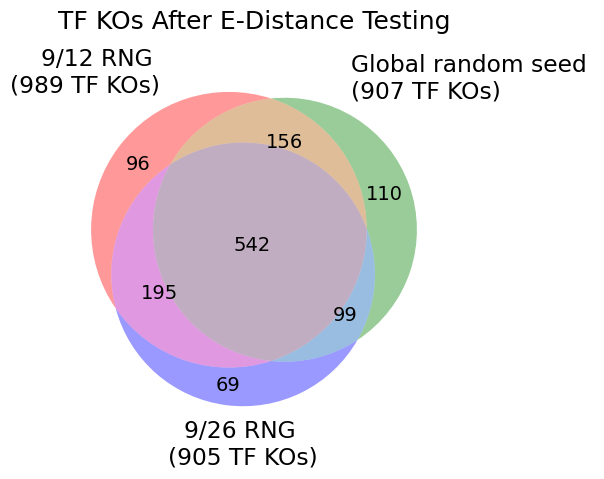

In [51]:
plot_venn3(energy_tf_kos_mod_sept12, energy_tf_kos_seed, energy_tf_kos_mod_sept26, 
           "9/12 RNG \n(989 TF KOs)", "Global random seed \n(907 TF KOs)", "9/26 RNG \n(905 TF KOs)", 
           title="TF KOs After E-Distance Testing\n")

### Step F SVM output

In [3]:
stepF_alpha_svm_mod_sept12 = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_Core_Cells.h5ad", backed="r")
stepF_beta_svm_mod_sept12 = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_BETA_Core_Cells.h5ad", backed="r")
stepF_gamma_svm_mod_sept12 = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_GAMMA_Core_Cells.h5ad", backed="r")

In [4]:
svm_tf_kos_mod_sept12 = get_tf_kos_3_batches(tfs, stepF_alpha_svm_mod_sept12, stepF_beta_svm_mod_sept12, stepF_gamma_svm_mod_sept12)

In [5]:
stepF_alpha_svm_seed = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_Core_Cells_1randseed.h5ad", backed="r")
stepF_beta_svm_seed = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_BETA_Core_Cells_1randseed.h5ad", backed="r")
stepF_gamma_svm_seed = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_GAMMA_Core_Cells_1randseed.h5ad", backed="r")

In [6]:
svm_tf_kos_seed = get_tf_kos_3_batches(tfs, stepF_alpha_svm_seed, stepF_beta_svm_seed, stepF_gamma_svm_seed)

In [7]:
# Datasets processed with RNG-modified code for Sept 26th
stepF_alpha_svm_mod_sept26 = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_Core_Cells_final.h5ad", backed="r")
stepF_beta_svm_mod_sept26 = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_BETA_Core_Cells_final.h5ad", backed="r")
stepF_gamma_svm_mod_sept26 = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_GAMMA_Core_Cells_final.h5ad", backed="r")

In [8]:
svm_tf_kos_mod_sept26 = get_tf_kos_3_batches(tfs, stepF_alpha_svm_mod_sept26, 
    stepF_beta_svm_mod_sept26, stepF_gamma_svm_mod_sept26)

In [20]:
print("After Step F filtering based on SVM:")
print(f"tf_kos_mod_sept12 = {len(svm_tf_kos_mod_sept12)} TF KOs, tf_kos_seed = {len(svm_tf_kos_seed)} TF KOs, "
      f"tf_kos_mod_sept26 = {len(svm_tf_kos_mod_sept26)} TF KOs")
print(f"Shared between 9/12 and global seed = {len(svm_tf_kos_mod_sept12 & svm_tf_kos_seed)} TF KOs")
print(f"Shared between global seed and 9/26 = {len(svm_tf_kos_mod_sept26 & svm_tf_kos_seed)} TF KOs")
print(f"Shared between 9/12 and 9/26 = {len(svm_tf_kos_mod_sept12 & svm_tf_kos_mod_sept26)} TF KOs")
print(f"Shared between all 3: {len(svm_tf_kos_mod_sept12 & svm_tf_kos_mod_sept26 & svm_tf_kos_seed)} TF KOs")

After Step F filtering based on SVM:
tf_kos_mod_sept12 = 660 TF KOs, tf_kos_seed = 629 TF KOs, tf_kos_mod_sept26 = 612 TF KOs
Shared between 9/12 and global seed = 381 TF KOs
Shared between global seed and 9/26 = 357 TF KOs
Shared between 9/12 and 9/26 = 412 TF KOs
Shared between all 3: 260 TF KOs


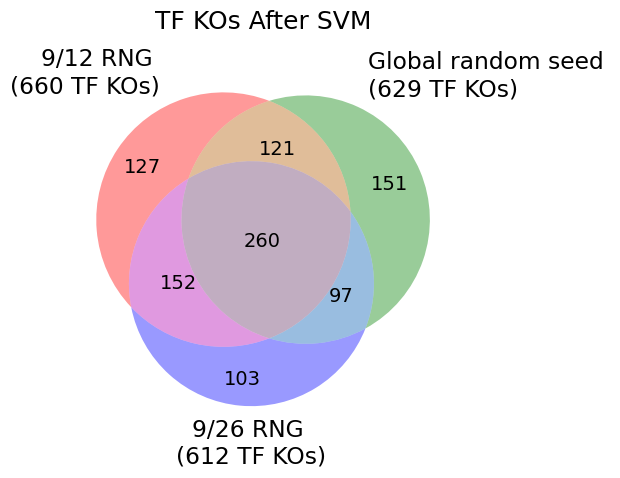

In [52]:
plot_venn3(svm_tf_kos_mod_sept12, svm_tf_kos_seed, svm_tf_kos_mod_sept26, 
           "9/12 RNG \n(660 TF KOs)", "Global random seed \n(629 TF KOs)", "9/26 RNG \n(612 TF KOs)", 
           title="TF KOs After SVM\n")

## Step F testing

### Step F with modified RNG functions (seed = 1337)

PCA seeds = 0

First we perform sgRNA-level energy distance-based filtering on each of the 3 data subsets.

In [ ]:
# Settings for parallel processing with tqdm_joblib
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OMP_MAX_ACTIVE_LEVELS"] = "1"
os.environ["KMP_WARNINGS"] = "0"  # For Intel's OpenMP implementation

# Create numpy default_rng() RNG object
step_f_rand_seed = 1337
step_f_rng = np.random.default_rng(step_f_rand_seed)

ALPHA:

In [ ]:
knockdown_adata_alpha = ad.read_h5ad("/home/ranwyl/data_tf_project/step_E_output_ALPHA_final.h5ad")

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:09)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)
computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 50
    computed neighbors (0:00:18)
    computed connectivities (0:00:11)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:30)


Computing null distribution:   0%|          | 0/20 [00:00<?, ?it/s]

Computing group distances:   0%|          | 0/7406 [00:00<?, ?it/s]

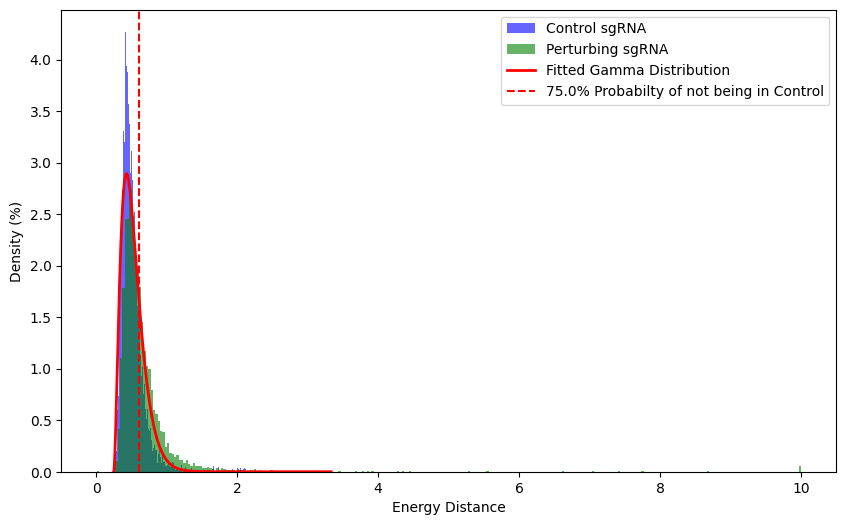

2939/7406 Perturbing sgRNA cross threshold of 0.75


In [ ]:
alpha_filtered, alpha_null_distances, alpha_results = qc2.filter_sgRNA_rng(knockdown_adata_alpha, rng=step_f_rng)

In [ ]:
alpha_filtered = alpha_filtered.copy()

In [ ]:
alpha_filtered.write("/home/ranwyl/data_tf_project/Aggregate_ALPHA_sgRNA_Filtered_final.h5ad")

In [ ]:
del alpha_filtered
gc.collect()

37401

BETA:

In [ ]:
knockdown_adata_beta = ad.read_h5ad("/home/ranwyl/data_tf_project/step_E_output_BETA_final.h5ad")

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:07)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)
computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 50
    computed neighbors (0:00:06)
    computed connectivities (0:00:11)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:18)


Computing null distribution:   0%|          | 0/20 [00:00<?, ?it/s]

Computing group distances:   0%|          | 0/8766 [00:00<?, ?it/s]

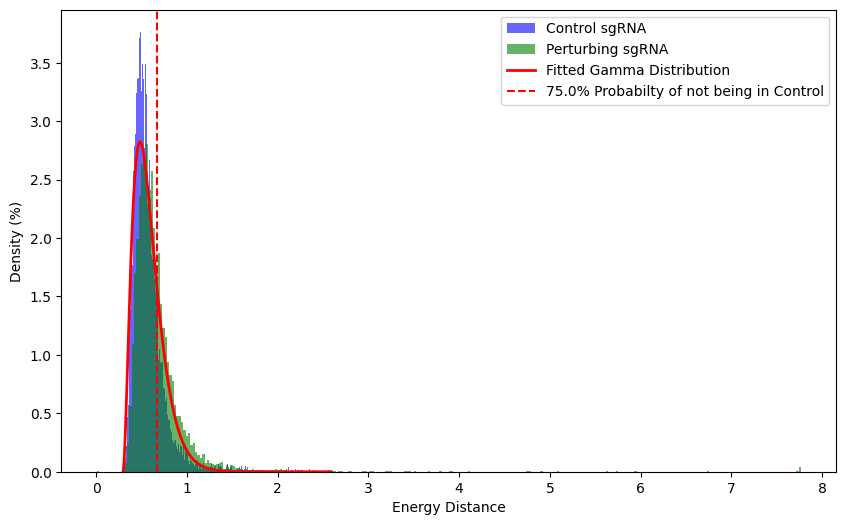

3194/8766 Perturbing sgRNA cross threshold of 0.75


In [ ]:
beta_filtered, beta_null_distances, beta_results = qc2.filter_sgRNA_rng(knockdown_adata_beta, rng=step_f_rng)

In [ ]:
beta_filtered = beta_filtered.copy()

In [ ]:
beta_filtered.write("/home/ranwyl/data_tf_project/Aggregate_BETA_sgRNA_Filtered_final.h5ad")

In [ ]:
del beta_filtered
gc.collect()

37610

GAMMA:

In [ ]:
knockdown_adata_gamma = ad.read_h5ad("/home/ranwyl/data_tf_project/step_E_output_GAMMA_final.h5ad")

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:13)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)
computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 50
    computed neighbors (0:00:06)
    computed connectivities (0:00:10)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:17)


Computing null distribution:   0%|          | 0/20 [00:00<?, ?it/s]

Computing group distances:   0%|          | 0/8262 [00:00<?, ?it/s]

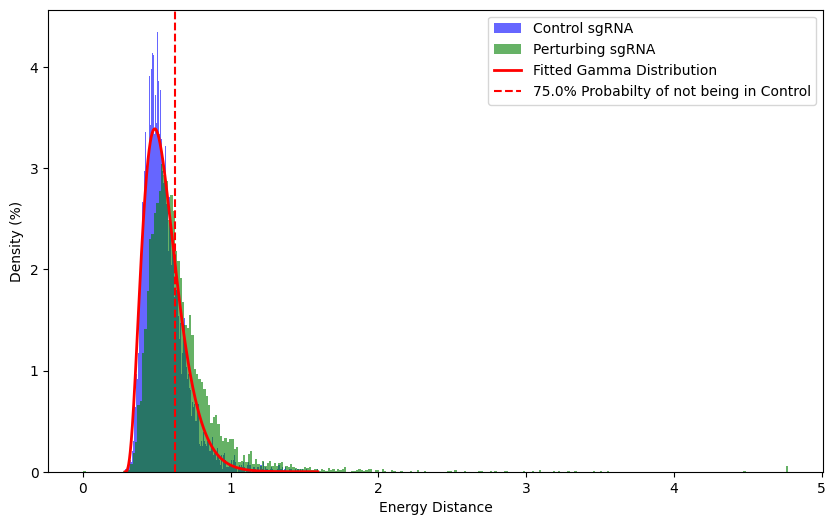

3541/8262 Perturbing sgRNA cross threshold of 0.75


In [ ]:
gamma_filtered, gamma_null_distances, gamma_results = qc2.filter_sgRNA_rng(knockdown_adata_gamma, rng=step_f_rng)

In [ ]:
gamma_filtered = gamma_filtered.copy()

In [ ]:
gamma_filtered.write("/home/ranwyl/data_tf_project/Aggregate_GAMMA_sgRNA_Filtered_final.h5ad")

Restart kernel

Next, we remove unperturbed cells one data subset at a time using an SVM classifier. The SVM is trained on the PCA embedding of the dataset. KO cells that are classified as NTC cells by the SVM will be removed.

In [ ]:
step_f_rm_rand_seed = 0 # PCA random_state

ALPHA:

In [ ]:
adata_alpha = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_sgRNA_Filtered_final.h5ad")

In [ ]:
adata_alpha

AnnData object with n_obs × n_vars = 235798 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std'
    uns: 'log1p'
    layers: 'counts', 'normalized_counts'

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:02)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:17)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


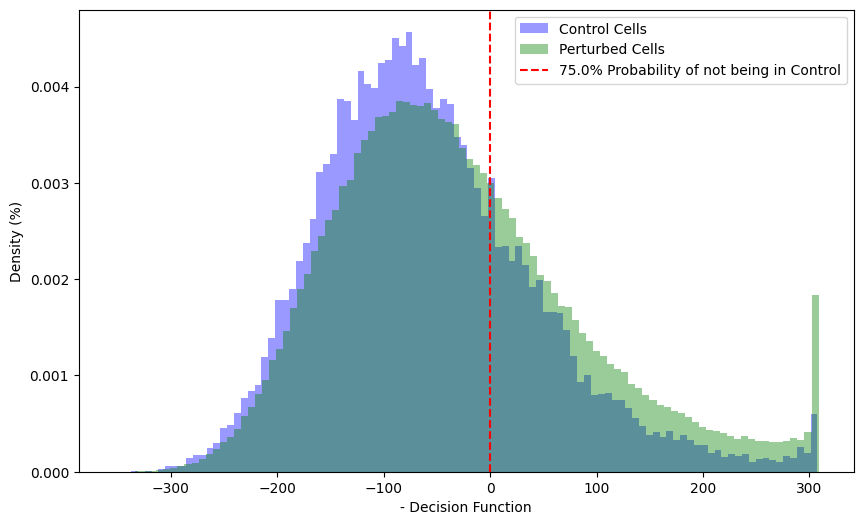

75190/222500 Perturbed Cells cross threshold of 0.75


In [ ]:
adata_alpha_filtered, c, p = qc2.remove_unperturbed_cells_random_seed(
    adata_alpha, threshold=0.75, rand_seed=step_f_rm_rand_seed)

In [ ]:
perturbation_counts = dict(adata_alpha_filtered.obs.gene_target.value_counts())
remaining_perturbations = [k for k,v in perturbation_counts.items() if v >= 25]
print(len(remaining_perturbations),remaining_perturbations)

1333 ['NTC', 'KAT2A', 'ARHGAP35', 'LRPPRC', 'CABIN1', 'ZNF787', 'ZFP82', 'ESRRG', 'DNMT1', 'NPM2', 'EHMT1', 'TENT4B', 'VDR', 'PCGF1', 'FOXH1', 'TSFM', 'INTS12', 'PNPT1', 'ZNF20', 'EZH2', 'ZSCAN18', 'ZNF396', 'ARNT2', 'UHRF1', 'PGR', 'TFAM', 'METTL24', 'CDYL2', 'KMT5C', 'ZNF521', 'ZNF875', 'ELOA', 'SMARCC1', 'DHX36', 'EHMT2', 'RNASEH1', 'DDX6', 'PAXIP1', 'DFFB', 'ZFP37', 'GNMT', 'DBX2', 'METTL7B', 'ANKZF1', 'ZNF362', 'MTA1', 'SMARCE1', 'SHOX2', 'HNF1A', 'POU5F1', 'LEMD3', 'KDM4B', 'H2BK1', 'ZNF426', 'ACTB', 'SUZ12', 'SOX4', 'MED19', 'SCX', 'POLRMT', 'RNF2', 'JMJD8', 'PPARGC1B', 'NABP2', 'POGZ', 'ZNF276', 'ACSF2', 'TRIM37', 'SCAI', 'KMT2D', 'UBR3', 'NEUROD4', 'SETDB1', 'DOT1L', 'FOXJ1', 'NCOA7', 'RCOR2', 'CDK13', 'SMAD4', 'CHAMP1', 'NANOG', 'H4C2', 'FOXD4', 'RLIM', 'EMSY', 'ZFP92', 'SETD7', 'ZNF551', 'BARX1', 'ZNF44', 'BARHL1', 'ZNF687', 'OVOL1', 'ZNF280B', 'ASF1A', 'MLLT1', 'SIN3B', 'EID1', 'ZNF469', 'SLC27A1', 'ZNF358', 'CCDC85B', 'HEXIM1', 'HHEX', 'GATAD1', 'IRF9', 'PARP16', 'SCRT2', 

In [ ]:
adata_alpha_filtered = qc2.remove_perturbations_by_cell_threshold(adata_alpha_filtered)

Removing 749 perturbations for having under 25 cells.


In [ ]:
adata_alpha_filtered

AnnData object with n_obs × n_vars = 75341 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '

In [ ]:
adata_alpha_filtered.write("/home/ranwyl/data_tf_project/Aggregate_ALPHA_Core_Cells_final.h5ad")

In [ ]:
del adata_alpha, adata_alpha_filtered
gc.collect()

16720

BETA:

In [ ]:
adata_beta = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_BETA_sgRNA_Filtered_final.h5ad")

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:02)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:16)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


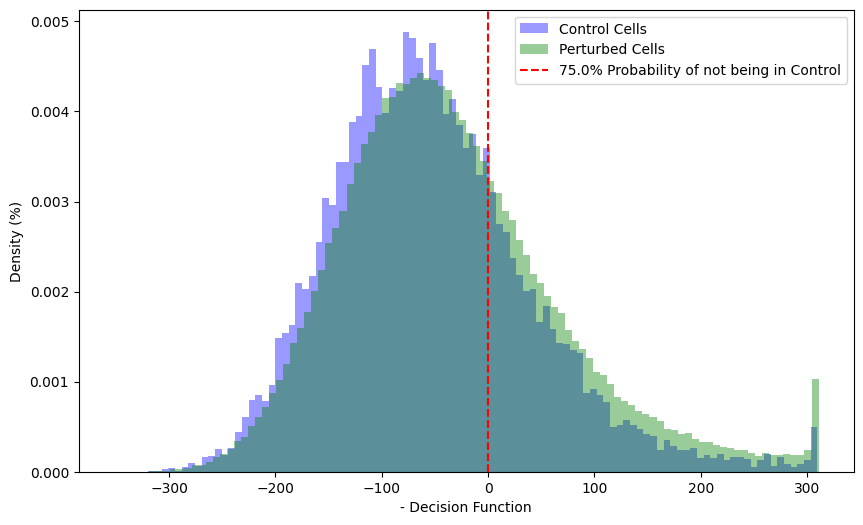

76834/245988 Perturbed Cells cross threshold of 0.75


In [ ]:
adata_beta_filtered, c, p = qc2.remove_unperturbed_cells_random_seed(
    adata_beta, threshold=0.75, rand_seed=step_f_rm_rand_seed)

In [ ]:
perturbation_counts = dict(adata_beta_filtered.obs.gene_target.value_counts())
remaining_perturbations = [k for k,v in perturbation_counts.items() if v >= 25]
print(len(remaining_perturbations),remaining_perturbations)

1353 ['NTC', 'CASP6', 'CCDC6', 'SLC39A13', 'BBC3', 'HCCS', 'VPS33A', 'VHL', 'UBE2M', 'RGS19', 'SLC30A1', 'MZT2A', 'UBFD1', 'PLIN3', 'ENHO', 'FBXO45', 'B3GAT3', 'LATS2', 'DTD2', 'SEMA6C', 'NAE1', 'PGM1', 'RNPEPL1', 'NDUFAF4', 'CRYGD', 'PDPR', 'ANKRD39', 'ANKRD9', 'FASTKD5', 'DESI2', 'LAMTOR1', 'PLOD3', 'ARFGAP1', 'TEFM', 'ORMDL1', 'MTHFR', 'CDKN2AIPNL', 'CYCS', 'TMEM98', 'IGF2R', 'IFFO1', 'ARSA', 'S100A11', 'TESK1', 'WDR91', 'TBRG4', 'JOSD1', 'RASL10B', 'AK4', 'INPP5J', 'PRSS53', 'STEAP3', 'AMOTL2', 'CHP2', 'LAMTOR5', 'IKBIP', 'MRPL36', 'ARL4D', 'HRH3', 'FXYD6', 'VPS39', 'MRPL11', 'POGLUT3', 'OSBPL2', 'FUOM', 'UNC50', 'ETNK2', 'SOCS1', 'TAGLN2', 'KHDC4', 'MTRES1', 'TNKS2', 'HNRNPM', 'DSP', 'PLA2G12A', 'HMBS', 'ZFAND2B', 'CSTB', 'UFSP1', 'CDO1', 'MRPS27', 'CTSL', 'MRPL10', 'FBXO2', 'TOE1', 'CKAP2', 'IFFO2', 'RUSF1', 'APMAP', 'CRELD1', 'WFS1', 'COX6B1', 'MRPL24', 'PCDH1', 'FNDC4', 'SRRD', 'LRFN3', 'MRPL58', 'GPR62', 'ADRA2C', 'FCHSD1', 'RAB5A', 'MYADM', 'GOLGA5', 'ELAVL1', 'CNOT11', 'MYL9

In [ ]:
adata_beta_filtered = qc2.remove_perturbations_by_cell_threshold(adata_beta_filtered)

Removing 945 perturbations for having under 25 cells.


In [ ]:
adata_beta_filtered

AnnData object with n_obs × n_vars = 73543 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '

In [ ]:
adata_beta_filtered.write("/home/ranwyl/data_tf_project/Aggregate_BETA_Core_Cells_final.h5ad")

In [ ]:
del adata_beta, adata_beta_filtered
gc.collect()

17401

GAMMA:

In [ ]:
adata_gamma = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_GAMMA_sgRNA_Filtered_final.h5ad")

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:02)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:16)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


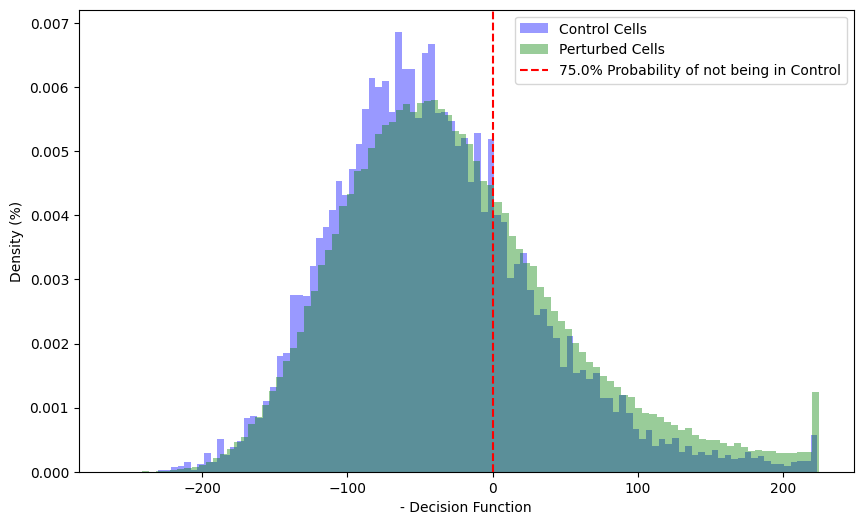

64218/207387 Perturbed Cells cross threshold of 0.75


In [ ]:
adata_gamma_filtered, c, p = qc2.remove_unperturbed_cells_random_seed(
    adata_gamma, threshold=0.75, rand_seed=step_f_rm_rand_seed)

In [ ]:
perturbation_counts = dict(adata_gamma_filtered.obs.gene_target.value_counts())
remaining_perturbations = [k for k,v in perturbation_counts.items() if v >= 25]
print(len(remaining_perturbations),remaining_perturbations)

1070 ['NTC', 'FLYWCH2', 'SUPT20H', 'NF2', 'ABCD1', 'HS2ST1', 'FAM193A', 'C15orf61', 'DDT', 'BAK1', 'FLCN', 'RALGAPB', 'IL17RD', 'STOML1', 'CDC42EP1', 'VSIG10', 'TIMM50', 'FGF21', 'CTAGE15', 'CHRD', 'DNAL4', 'NPC1', 'FECH', 'ADCY9', 'EIF4ENIF1', 'CDON', 'TGFBR2', 'EFNB3', 'MPC2', 'SCAF8', 'TMEM74B', 'SYT7', 'USP45', 'DAP', 'AKAP9', 'BAD', 'SLC35F5', 'PLXND1', 'ARL3', 'RPL39L', 'UNC5B', 'DTX2', 'CAB39', 'ERO1A', 'DECR2', 'SPAG9', 'HIBADH', 'CAMK2N2', 'PAQR3', 'TSEN54', 'CISD3', 'TBC1D7', 'FAM98A', 'KTN1', 'GDAP1', 'POMT2', 'NCAN', 'AGTPBP1', 'UQCC1', 'C1orf21', 'PAPSS1', 'WASHC2C', 'AP5S1', 'TIE1', 'PEX13', 'NPIPA3', 'BCL2L12', 'OSBPL7', 'CYP2R1', 'MBOAT1', 'WNK2', 'SH3D19', 'FLT1', 'GOLGA6A', 'HPRT1', 'DSE', 'C18orf32', 'BEND4', 'RNF11', 'CNST', 'MCOLN1', 'HEATR6', 'RETREG2', 'KLHL24', 'RET', 'KLHL4', 'NRBP1', 'FRAS1', 'SLC25A51', 'FAM221A', 'TAC1', 'MAP4K5', 'BLTP1', 'CYP2D6', 'MTPAP', 'APAF1', 'CYBRD1', 'NADK2', 'DNAJC16', 'SLC29A2', 'EDNRB', 'GARIN5A', 'GCSAM', 'CCDC87', 'DFFA', 'USP

In [ ]:
adata_gamma_filtered = qc2.remove_perturbations_by_cell_threshold(adata_gamma_filtered)

Removing 1408 perturbations for having under 25 cells.


In [ ]:
adata_gamma_filtered

AnnData object with n_obs × n_vars = 52126 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '

In [ ]:
adata_gamma_filtered.write("/home/ranwyl/data_tf_project/Aggregate_GAMMA_Core_Cells_final.h5ad")

Restart kernel

### Step F with modified RNG functions (E-dist seed = 42, SVM seed = 0)

Using "_final" dataset. Use random seed of 42 instead of 1337 as previously used. PCA seeds = 0.

First we perform sgRNA-level energy distance-based filtering on each of the 3 data subsets.

In [2]:
# Settings for parallel processing with tqdm_joblib
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OMP_MAX_ACTIVE_LEVELS"] = "1"
os.environ["KMP_WARNINGS"] = "0"  # For Intel's OpenMP implementation

# Create numpy default_rng() RNG object
step_f_rand_seed = 42
step_f_rng = np.random.default_rng(step_f_rand_seed)

ALPHA:

In [3]:
knockdown_adata_alpha = ad.read_h5ad("/home/ranwyl/data_tf_project/step_E_output_ALPHA_final.h5ad")

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:10)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)
computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 50
    computed neighbors (0:00:18)
    computed connectivities (0:00:11)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:30)


Computing null distribution:   0%|          | 0/20 [00:00<?, ?it/s]

Computing group distances:   0%|          | 0/7406 [00:00<?, ?it/s]

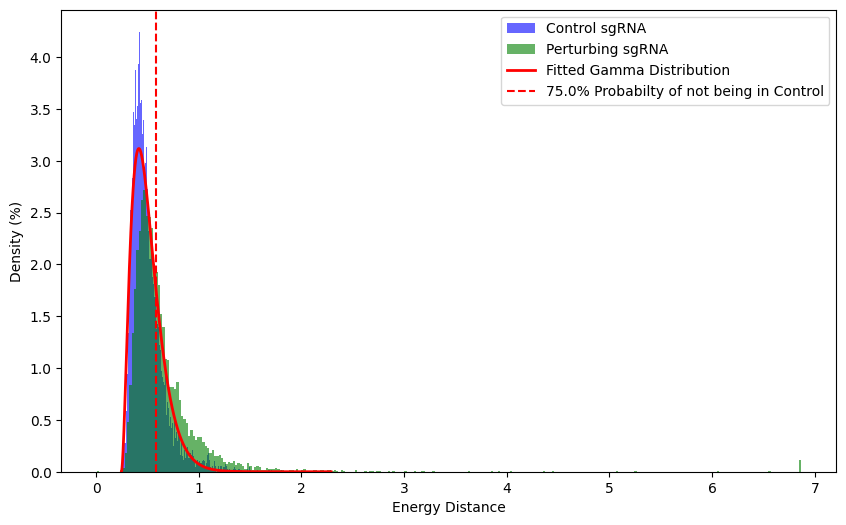

3260/7406 Perturbing sgRNA cross threshold of 0.75


In [4]:
alpha_filtered, alpha_null_distances, alpha_results = qc2.filter_sgRNA_rng(knockdown_adata_alpha, rng=step_f_rng)

In [5]:
alpha_filtered = alpha_filtered.copy()

In [6]:
alpha_filtered.write("/home/ranwyl/data_tf_project/Aggregate_ALPHA_sgRNA_Filtered_final_seed42.h5ad")

In [7]:
del alpha_filtered
gc.collect()

37664

BETA:

In [8]:
knockdown_adata_beta = ad.read_h5ad("/home/ranwyl/data_tf_project/step_E_output_BETA_final.h5ad")

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:07)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)
computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 50
    computed neighbors (0:00:07)
    computed connectivities (0:00:11)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:18)


Computing null distribution:   0%|          | 0/20 [00:00<?, ?it/s]

Computing group distances:   0%|          | 0/8766 [00:00<?, ?it/s]

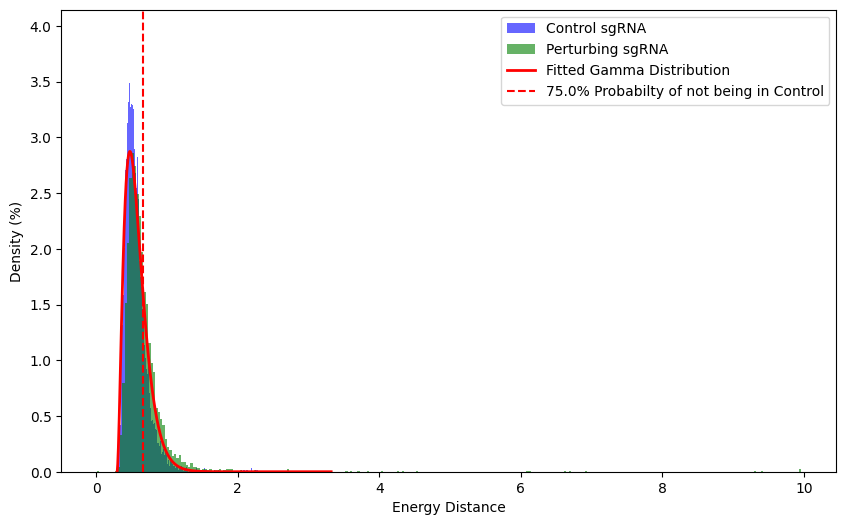

3154/8766 Perturbing sgRNA cross threshold of 0.75


In [9]:
beta_filtered, beta_null_distances, beta_results = qc2.filter_sgRNA_rng(knockdown_adata_beta, rng=step_f_rng)

In [10]:
beta_filtered = beta_filtered.copy()

In [11]:
beta_filtered.write("/home/ranwyl/data_tf_project/Aggregate_BETA_sgRNA_Filtered_final_seed42.h5ad")

In [12]:
del beta_filtered
gc.collect()

37410

GAMMA:

In [13]:
knockdown_adata_gamma = ad.read_h5ad("/home/ranwyl/data_tf_project/step_E_output_GAMMA_final.h5ad")

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:06)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)
computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 50
    computed neighbors (0:00:06)
    computed connectivities (0:00:10)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:17)


Computing null distribution:   0%|          | 0/20 [00:00<?, ?it/s]

Computing group distances:   0%|          | 0/8262 [00:00<?, ?it/s]

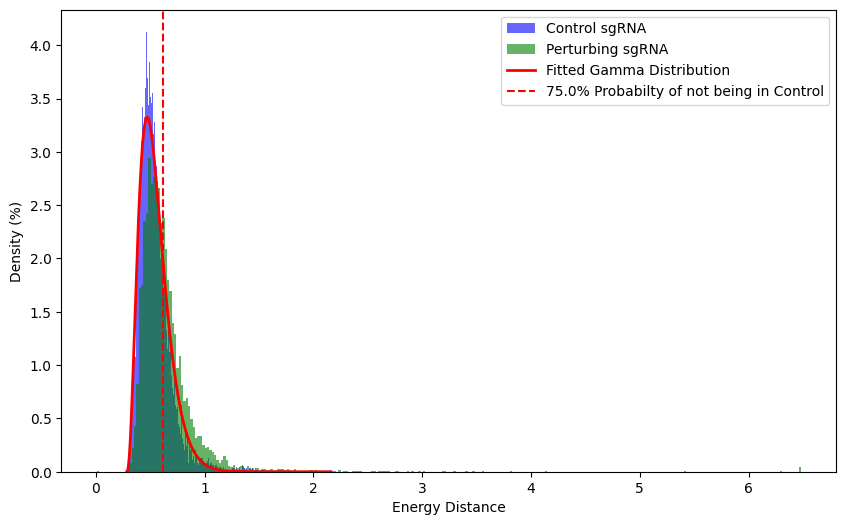

3466/8262 Perturbing sgRNA cross threshold of 0.75


In [14]:
gamma_filtered, gamma_null_distances, gamma_results = qc2.filter_sgRNA_rng(knockdown_adata_gamma, rng=step_f_rng)

In [15]:
gamma_filtered = gamma_filtered.copy()

In [16]:
gamma_filtered.write("/home/ranwyl/data_tf_project/Aggregate_GAMMA_sgRNA_Filtered_final_seed42.h5ad")

Restart kernel

Next, we remove unperturbed cells one data subset at a time using an SVM classifier. The SVM is trained on the PCA embedding of the dataset. KO cells that are classified as NTC cells by the SVM will be removed.

Use PCA random_state = 0

In [2]:
step_f_rm_rand_seed = 0 # PCA random_state

ALPHA:

In [3]:
adata_alpha = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_sgRNA_Filtered_final_seed42.h5ad")

In [4]:
adata_alpha

AnnData object with n_obs × n_vars = 262550 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std'
    uns: 'log1p'
    layers: 'counts', 'normalized_counts'

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:02)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:19)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


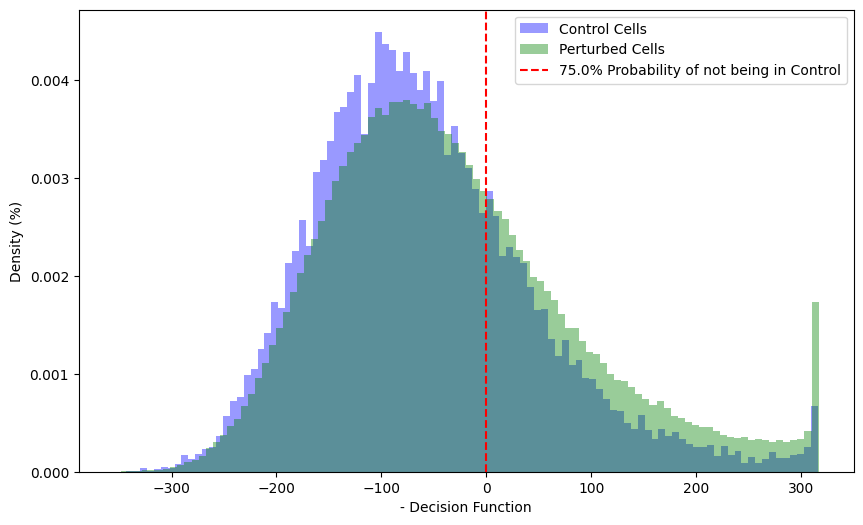

82407/249252 Perturbed Cells cross threshold of 0.75


In [5]:
adata_alpha_filtered, c, p = qc2.remove_unperturbed_cells_random_seed(
    adata_alpha, threshold=0.75, rand_seed=step_f_rm_rand_seed)

In [6]:
perturbation_counts = dict(adata_alpha_filtered.obs.gene_target.value_counts())
remaining_perturbations = [k for k,v in perturbation_counts.items() if v >= 25]
print(len(remaining_perturbations),remaining_perturbations)

1480 ['NTC', 'HNF4A', 'KAT2A', 'VDR', 'LRPPRC', 'CABIN1', 'ZNF787', 'DNMT1', 'CHAMP1', 'PCGF1', 'EHMT1', 'TADA2B', 'POGZ', 'EMSY', 'ZNF273', 'NSD2', 'PNPT1', 'UHRF1', 'TBXT', 'INTS12', 'TAF6L', 'ZFP28', 'ZBTB22', 'FOXH1', 'ALKBH1', 'ZNF875', 'DDX6', 'ZNF396', 'EOMES', 'EHMT2', 'ZNF697', 'SIN3B', 'BMAL2', 'ELOC', 'TFAM', 'HIC1', 'ASS1', 'SOX4', 'ZNF426', 'ZNF419', 'ZNF829', 'ZFP57', 'ESRRA', 'NR0B1', 'SMARCC1', 'POU5F1', 'USP17L2', 'ACTB', 'PDP1', 'LEMD3', 'DOT1L', 'ZNF683', 'POLRMT', 'PRMT5', 'SNAI3', 'SMARCE1', 'ZNF287', 'ADNP2', 'OLIG1', 'BRD1', 'PKNOX2', 'BHLHE40', 'ZNF420', 'ZNF132', 'KMT2E', 'ZNF596', 'MTA2', 'ZNF556', 'HOXB3', 'NANOG', 'PARP16', 'SETDB1', 'CRTC2', 'SWAP70', 'H3-7', 'ZFP41', 'SLC22A1', 'ARHGAP35', 'ASF1A', 'FOXJ1', 'SUZ12', 'RCOR2', 'ZNF713', 'ZNF700', 'CDK13', 'RLIM', 'SSBP1', 'TCF21', 'MEIS3', 'RNASE6', 'SP4', 'ELL2', 'TDP1', 'ZNF557', 'CCNC', 'KMT2D', 'IRF9', 'SMAD4', 'POU2F3', 'ZNF735', 'ZNF17', 'H2BW2', 'ARNT2', 'GATAD1', 'EYA3', 'TACC1', 'KDM1A', 'PNLDC1', '

In [7]:
adata_alpha_filtered = qc2.remove_perturbations_by_cell_threshold(adata_alpha_filtered)

Removing 740 perturbations for having under 25 cells.


In [8]:
adata_alpha_filtered

AnnData object with n_obs × n_vars = 82527 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '

In [9]:
adata_alpha_filtered.write("/home/ranwyl/data_tf_project/Aggregate_ALPHA_Core_Cells_final_seed42.h5ad")

In [10]:
del adata_alpha, adata_alpha_filtered
gc.collect()

16726

BETA:

In [11]:
adata_beta = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_BETA_sgRNA_Filtered_final_seed42.h5ad")

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:02)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:16)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


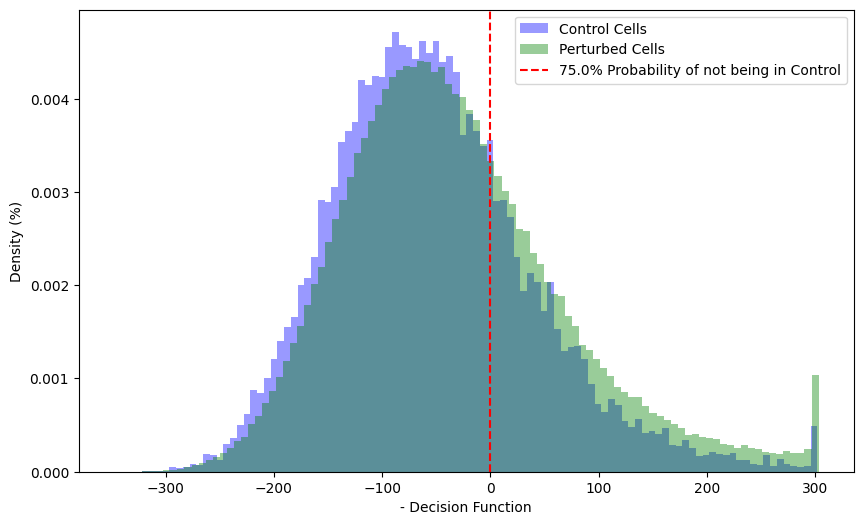

77533/245233 Perturbed Cells cross threshold of 0.75


In [12]:
adata_beta_filtered, c, p = qc2.remove_unperturbed_cells_random_seed(
    adata_beta, threshold=0.75, rand_seed=step_f_rm_rand_seed)

In [13]:
perturbation_counts = dict(adata_beta_filtered.obs.gene_target.value_counts())
remaining_perturbations = [k for k,v in perturbation_counts.items() if v >= 25]
print(len(remaining_perturbations),remaining_perturbations)

1388 ['NTC', 'SCAF4', 'CCDC6', 'CASP9', 'HCCS', 'LATS2', 'MZT2A', 'VPS33A', 'VHL', 'UBE2M', 'CDK5R1', 'PTPN1', 'CASP6', 'UBFD1', 'SLC30A1', 'PALD1', 'CASP3', 'C19orf12', 'PPP1R14B', 'ARHGDIA', 'STXBP2', 'CTAGE15', 'HRH3', 'BET1L', 'NAE1', 'PRR7', 'KCTD3', 'B3GALT6', 'MTRF1L', 'LAMTOR1', 'RNF41', 'RAB12', 'FASTKD5', 'FGFRL1', 'CYCS', 'BICD2', 'NDUFAF4', 'TEFM', 'CCDC71L', 'FZD9', 'IPO9', 'AMIGO2', 'C3orf80', 'MRPL36', 'IFFO1', 'RNF139', 'MIEF2', 'RAB5C', 'LRCH4', 'SPRY2', 'JOSD1', 'NKTR', 'TWSG1', 'KIF5A', 'PTEN', 'LAMTOR5', 'FTH1', 'CHEK2', 'AMOTL2', 'STARD3NL', 'RGS19', 'BCL2L13', 'SLC39A1', 'CD7', 'DEXI', 'POGLUT3', 'SNN', 'VPS39', 'CAPN1', 'USP38', 'INPP5J', 'C19orf47', 'TRAFD1', 'FGFR4', 'MST1R', 'PLCD3', 'UHMK1', 'MYLIP', 'B3GAT3', 'TUNAR', 'HLA-DOA', 'IL27RA', 'ADO', 'HNRNPM', 'TMEM167A', 'CD46', 'REEP6', 'GIPC1', 'RRM1', 'TOR1B', 'TBC1D13', 'CDH1', 'RNPEPL1', 'RPRD2', 'ENAH', 'TST', 'OLFML3', 'GRIK5', 'CDO1', 'ALAS1', 'FRAT2', 'ATP1A3', 'MRPL58', 'SV2A', 'NCKAP5L', 'SH2D2A', 'AG

In [14]:
adata_beta_filtered = qc2.remove_perturbations_by_cell_threshold(adata_beta_filtered)

Removing 873 perturbations for having under 25 cells.


In [15]:
adata_beta_filtered

AnnData object with n_obs × n_vars = 75481 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '

In [16]:
adata_beta_filtered.write("/home/ranwyl/data_tf_project/Aggregate_BETA_Core_Cells_final_seed42.h5ad")

In [17]:
del adata_beta, adata_beta_filtered
gc.collect()

16595

GAMMA:

In [18]:
adata_gamma = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_GAMMA_sgRNA_Filtered_final_seed42.h5ad")

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:02)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:13)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


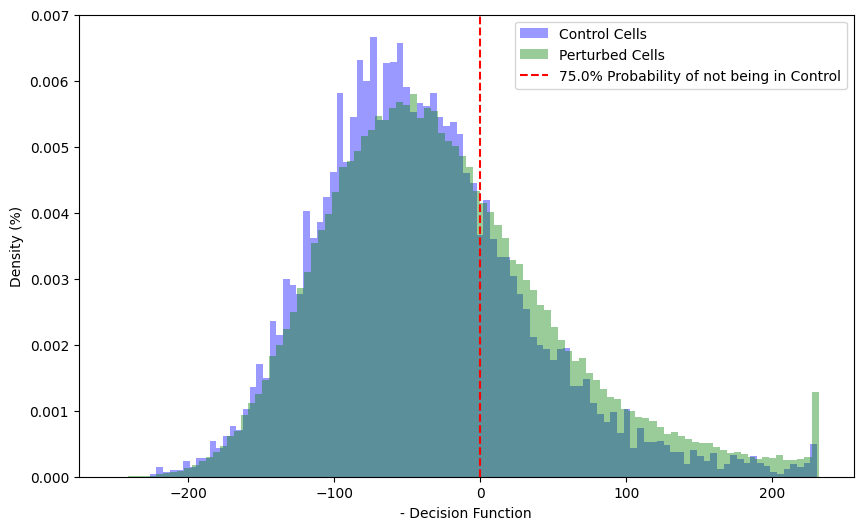

63300/202140 Perturbed Cells cross threshold of 0.75


In [19]:
adata_gamma_filtered, c, p = qc2.remove_unperturbed_cells_random_seed(
    adata_gamma, threshold=0.75, rand_seed=step_f_rm_rand_seed)

In [20]:
perturbation_counts = dict(adata_gamma_filtered.obs.gene_target.value_counts())
remaining_perturbations = [k for k,v in perturbation_counts.items() if v >= 25]
print(len(remaining_perturbations),remaining_perturbations)

1064 ['NTC', 'SUPT20H', 'HS2ST1', 'FAM193A', 'NF2', 'CCDC18', 'PER2', 'RNF144A', 'MBP', 'FLYWCH2', 'RFK', 'ADAMTS13', 'SEL1L3', 'OGG1', 'FLCN', 'TIMM50', 'CAMK2N2', 'NOMO1', 'NNT', 'STOML1', 'MPC2', 'VAC14', 'CYP2R1', 'STXBP3', 'EIF4ENIF1', 'TGFBR2', 'CR2', 'FBXO31', 'CTAGE15', 'PIP4P2', 'FBXO42', 'SCAF8', 'FBXO17', 'ARHGEF10L', 'CDON', 'BAIAP3', 'STK38L', 'AP5S1', 'ANOS1', 'HCN2', 'CWF19L1', 'FAM83E', 'USP45', 'LRRC45', 'TMEM74B', 'AMER1', 'C3orf52', 'SREK1IP1', 'SPAG9', 'TSEN54', 'QTRT2', 'BICD1', 'MYO1B', 'AP5Z1', 'OSBPL7', 'BAD', 'SPHK1', 'CRIM1', 'PIGC', 'DNAJC16', 'IFT22', 'NAAA', 'SHISAL2B', 'TMEM120A', 'MON1A', 'C1orf21', 'RNF11', 'SLC37A1', 'RALGAPB', 'RGPD6', 'CXCL1', 'CNST', 'RSAD1', 'CCDC96', 'IGFBP5', 'NRBP1', 'MTPAP', 'MCU', 'MAPK6', 'MRPL4', 'PAN3', 'RTL8B', 'CDK5RAP1', 'SULT4A1', 'NRBP2', 'EMC7', 'PKIA', 'RAB33B', 'RBM5', 'CA2', 'NPIPA3', 'TAOK1', 'USP14', 'RETREG2', 'PTGR2', 'NPC1', 'TMEM63B', 'FAM221A', 'HAGH', 'SLC44A1', 'AGTPBP1', 'KCTD5', 'WHAMM', 'ETHE1', 'APAF1',

In [21]:
adata_gamma_filtered = qc2.remove_perturbations_by_cell_threshold(adata_gamma_filtered)

Removing 1353 perturbations for having under 25 cells.


In [22]:
adata_gamma_filtered

AnnData object with n_obs × n_vars = 51783 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '

In [23]:
adata_gamma_filtered.write("/home/ranwyl/data_tf_project/Aggregate_GAMMA_Core_Cells_final_seed42.h5ad")

Restart kernel

### Rerun SVM step with PCA random_state=42

Use PCA random_state = 42

In [2]:
step_f_rm_rand_seed = 42 # PCA random_state

ALPHA:

In [3]:
adata_alpha = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_sgRNA_Filtered_final_seed42.h5ad")

In [4]:
adata_alpha

AnnData object with n_obs × n_vars = 262550 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std'
    uns: 'log1p'
    layers: 'counts', 'normalized_counts'

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:02)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:19)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


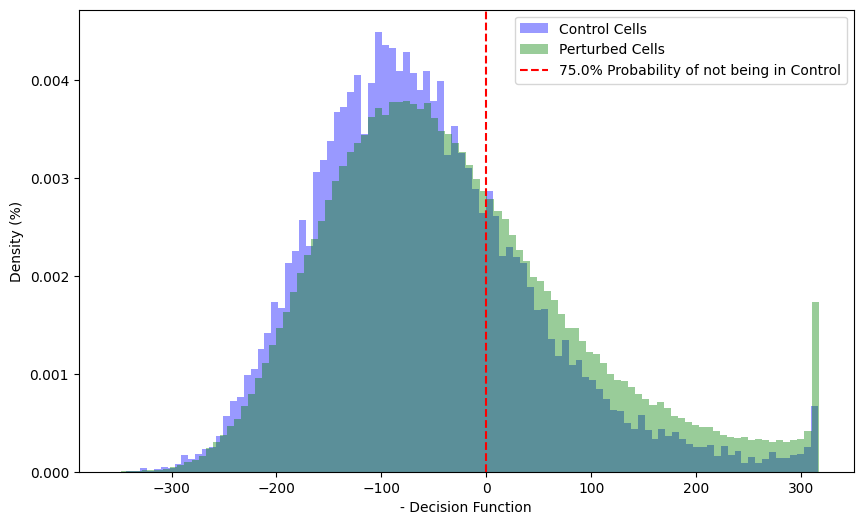

82408/249252 Perturbed Cells cross threshold of 0.75


In [5]:
adata_alpha_filtered, c, p = qc2.remove_unperturbed_cells_random_seed(
    adata_alpha, threshold=0.75, rand_seed=step_f_rm_rand_seed)

In [6]:
perturbation_counts = dict(adata_alpha_filtered.obs.gene_target.value_counts())
remaining_perturbations = [k for k,v in perturbation_counts.items() if v >= 25]
print(len(remaining_perturbations),remaining_perturbations)

1480 ['NTC', 'HNF4A', 'KAT2A', 'VDR', 'LRPPRC', 'CABIN1', 'ZNF787', 'DNMT1', 'CHAMP1', 'PCGF1', 'EHMT1', 'TADA2B', 'POGZ', 'EMSY', 'ZNF273', 'NSD2', 'PNPT1', 'UHRF1', 'TBXT', 'INTS12', 'TAF6L', 'ZFP28', 'ZBTB22', 'FOXH1', 'ALKBH1', 'ZNF875', 'DDX6', 'ZNF396', 'EOMES', 'EHMT2', 'ZNF697', 'SIN3B', 'BMAL2', 'ELOC', 'TFAM', 'HIC1', 'ASS1', 'SOX4', 'ZNF426', 'ZNF419', 'ZNF829', 'ZFP57', 'ESRRA', 'NR0B1', 'SMARCC1', 'POU5F1', 'USP17L2', 'ACTB', 'PDP1', 'LEMD3', 'DOT1L', 'ZNF683', 'POLRMT', 'PRMT5', 'SNAI3', 'SMARCE1', 'ZNF287', 'ADNP2', 'OLIG1', 'BRD1', 'PKNOX2', 'BHLHE40', 'ZNF420', 'ZNF132', 'KMT2E', 'ZNF596', 'MTA2', 'ZNF556', 'HOXB3', 'NANOG', 'PARP16', 'SETDB1', 'CRTC2', 'SWAP70', 'H3-7', 'ZFP41', 'SLC22A1', 'ARHGAP35', 'ASF1A', 'FOXJ1', 'SUZ12', 'RCOR2', 'ZNF713', 'ZNF700', 'CDK13', 'RLIM', 'SSBP1', 'TCF21', 'MEIS3', 'RNASE6', 'SP4', 'ELL2', 'TDP1', 'ZNF557', 'CCNC', 'KMT2D', 'IRF9', 'SMAD4', 'POU2F3', 'ZNF735', 'ZNF17', 'H2BW2', 'ARNT2', 'GATAD1', 'EYA3', 'TACC1', 'KDM1A', 'PNLDC1', '

In [7]:
adata_alpha_filtered = qc2.remove_perturbations_by_cell_threshold(adata_alpha_filtered)

Removing 740 perturbations for having under 25 cells.


In [8]:
adata_alpha_filtered

AnnData object with n_obs × n_vars = 82528 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '

In [ ]:
adata_alpha_filtered.write("/home/ranwyl/data_tf_project/Aggregate_ALPHA_Core_Cells_final_seed4242.h5ad")

In [10]:
del adata_alpha, adata_alpha_filtered
gc.collect()

16726

BETA:

In [11]:
adata_beta = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_BETA_sgRNA_Filtered_final_seed42.h5ad")

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:02)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:18)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


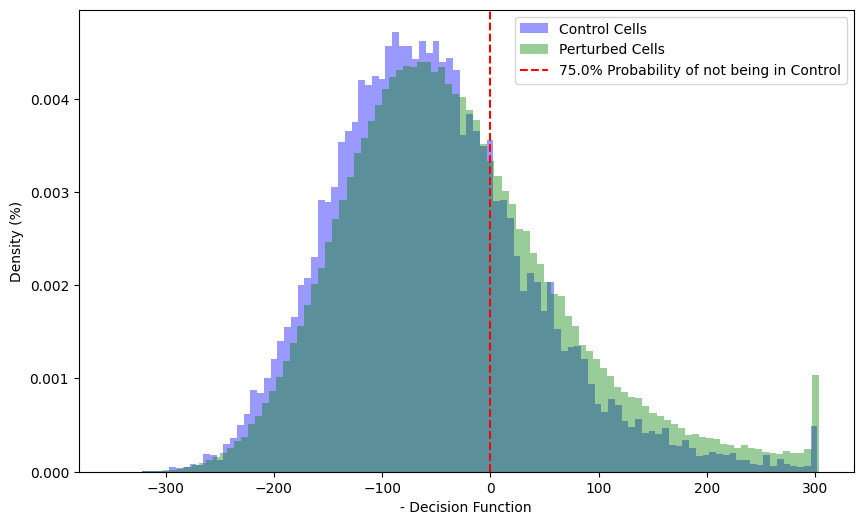

77535/245233 Perturbed Cells cross threshold of 0.75


In [12]:
adata_beta_filtered, c, p = qc2.remove_unperturbed_cells_random_seed(
    adata_beta, threshold=0.75, rand_seed=step_f_rm_rand_seed)

In [13]:
perturbation_counts = dict(adata_beta_filtered.obs.gene_target.value_counts())
remaining_perturbations = [k for k,v in perturbation_counts.items() if v >= 25]
print(len(remaining_perturbations),remaining_perturbations)

1388 ['NTC', 'SCAF4', 'CCDC6', 'CASP9', 'HCCS', 'LATS2', 'MZT2A', 'VPS33A', 'VHL', 'UBE2M', 'CASP6', 'CDK5R1', 'PTPN1', 'UBFD1', 'SLC30A1', 'PALD1', 'CASP3', 'C19orf12', 'PPP1R14B', 'ARHGDIA', 'STXBP2', 'CTAGE15', 'HRH3', 'BET1L', 'NAE1', 'PRR7', 'KCTD3', 'B3GALT6', 'LAMTOR1', 'MTRF1L', 'RAB12', 'RNF41', 'FASTKD5', 'FGFRL1', 'CYCS', 'BICD2', 'NDUFAF4', 'TEFM', 'CCDC71L', 'FZD9', 'IPO9', 'C3orf80', 'AMIGO2', 'IFFO1', 'MRPL36', 'MIEF2', 'RAB5C', 'RNF139', 'LRCH4', 'SPRY2', 'NKTR', 'JOSD1', 'KIF5A', 'TWSG1', 'CHEK2', 'FTH1', 'LAMTOR5', 'AMOTL2', 'STARD3NL', 'PTEN', 'RGS19', 'BCL2L13', 'CD7', 'SNN', 'CAPN1', 'POGLUT3', 'DEXI', 'SLC39A1', 'VPS39', 'USP38', 'INPP5J', 'C19orf47', 'MST1R', 'TRAFD1', 'FGFR4', 'PLCD3', 'MYLIP', 'UHMK1', 'B3GAT3', 'TUNAR', 'HLA-DOA', 'IL27RA', 'ADO', 'HNRNPM', 'REEP6', 'TMEM167A', 'CD46', 'GIPC1', 'RRM1', 'TOR1B', 'CDH1', 'RNPEPL1', 'TBC1D13', 'ENAH', 'OLFML3', 'TST', 'RPRD2', 'ALAS1', 'FRAT2', 'CDO1', 'GRIK5', 'TMX2', 'NCKAP5L', 'SV2A', 'TXNDC15', 'ATP1A3', 'MRP

In [14]:
adata_beta_filtered = qc2.remove_perturbations_by_cell_threshold(adata_beta_filtered)

Removing 873 perturbations for having under 25 cells.


In [15]:
adata_beta_filtered

AnnData object with n_obs × n_vars = 75483 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '

In [16]:
adata_beta_filtered.write("/home/ranwyl/data_tf_project/Aggregate_BETA_Core_Cells_final_seed4242.h5ad")

In [17]:
del adata_beta, adata_beta_filtered
gc.collect()

16589

GAMMA:

In [18]:
adata_gamma = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_GAMMA_sgRNA_Filtered_final_seed42.h5ad")

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:02)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:12)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


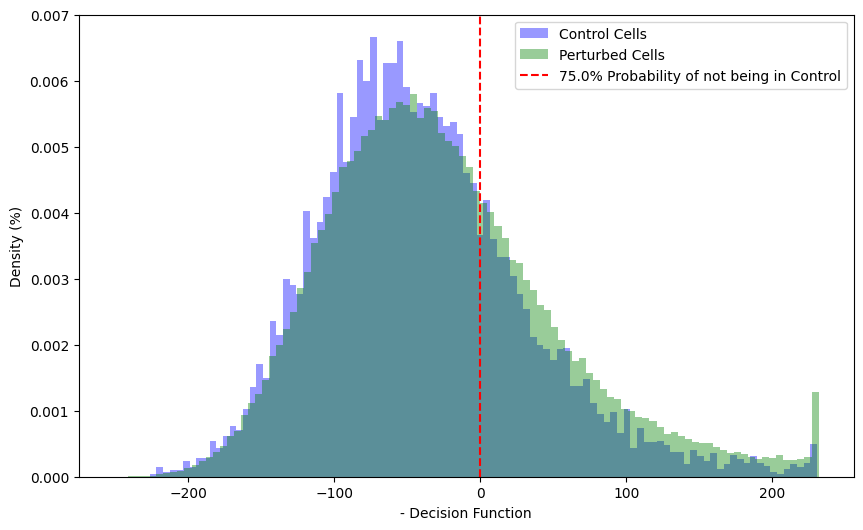

63300/202140 Perturbed Cells cross threshold of 0.75


In [19]:
adata_gamma_filtered, c, p = qc2.remove_unperturbed_cells_random_seed(
    adata_gamma, threshold=0.75, rand_seed=step_f_rm_rand_seed)

In [20]:
perturbation_counts = dict(adata_gamma_filtered.obs.gene_target.value_counts())
remaining_perturbations = [k for k,v in perturbation_counts.items() if v >= 25]
print(len(remaining_perturbations),remaining_perturbations)

1064 ['NTC', 'SUPT20H', 'HS2ST1', 'FAM193A', 'NF2', 'CCDC18', 'PER2', 'RNF144A', 'MBP', 'FLYWCH2', 'RFK', 'ADAMTS13', 'SEL1L3', 'OGG1', 'FLCN', 'TIMM50', 'CAMK2N2', 'NOMO1', 'NNT', 'STOML1', 'MPC2', 'VAC14', 'CYP2R1', 'STXBP3', 'EIF4ENIF1', 'TGFBR2', 'CR2', 'FBXO31', 'CTAGE15', 'PIP4P2', 'FBXO42', 'SCAF8', 'FBXO17', 'ARHGEF10L', 'CDON', 'BAIAP3', 'STK38L', 'AP5S1', 'ANOS1', 'HCN2', 'CWF19L1', 'FAM83E', 'USP45', 'LRRC45', 'TMEM74B', 'AMER1', 'C3orf52', 'SREK1IP1', 'SPAG9', 'TSEN54', 'QTRT2', 'BICD1', 'MYO1B', 'AP5Z1', 'OSBPL7', 'BAD', 'SPHK1', 'CRIM1', 'PIGC', 'DNAJC16', 'IFT22', 'NAAA', 'SHISAL2B', 'TMEM120A', 'MON1A', 'C1orf21', 'RNF11', 'SLC37A1', 'RALGAPB', 'RGPD6', 'CXCL1', 'CNST', 'RSAD1', 'CCDC96', 'IGFBP5', 'NRBP1', 'MTPAP', 'MCU', 'MAPK6', 'MRPL4', 'PAN3', 'RTL8B', 'CDK5RAP1', 'SULT4A1', 'NRBP2', 'EMC7', 'PKIA', 'RAB33B', 'RBM5', 'CA2', 'NPIPA3', 'TAOK1', 'USP14', 'RETREG2', 'PTGR2', 'NPC1', 'TMEM63B', 'FAM221A', 'HAGH', 'SLC44A1', 'AGTPBP1', 'KCTD5', 'WHAMM', 'ETHE1', 'APAF1',

In [21]:
adata_gamma_filtered = qc2.remove_perturbations_by_cell_threshold(adata_gamma_filtered)

Removing 1353 perturbations for having under 25 cells.


In [22]:
adata_gamma_filtered

AnnData object with n_obs × n_vars = 51783 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '

In [23]:
adata_gamma_filtered.write("/home/ranwyl/data_tf_project/Aggregate_GAMMA_Core_Cells_final_seed4242.h5ad")

Restart kernel

Use seed 42 for E-distance testing and 0 for SVM

In [2]:
step_f_rm_rand_seed = 0 # PCA random_state

In [3]:
adata_alpha = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_sgRNA_Filtered_final_seed42.h5ad")

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:02)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:19)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


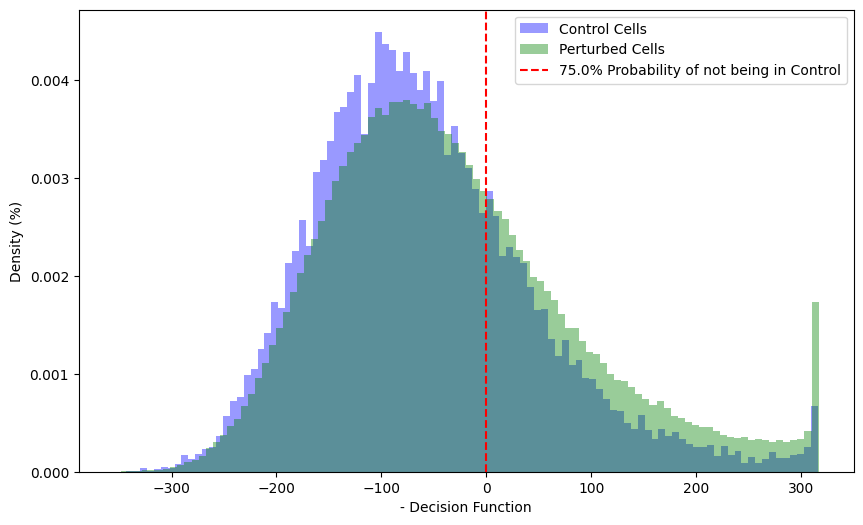

82407/249252 Perturbed Cells cross threshold of 0.75


In [4]:
adata_alpha_filtered, c, p = qc2.remove_unperturbed_cells_random_seed(
    adata_alpha, threshold=0.75, rand_seed=step_f_rm_rand_seed)

In [5]:
adata_alpha_filtered = qc2.remove_perturbations_by_cell_threshold(adata_alpha_filtered)

Removing 740 perturbations for having under 25 cells.


In [6]:
adata_alpha_filtered.write("/home/ranwyl/data_tf_project/Aggregate_ALPHA_Core_Cells_final_seed420.h5ad")

In [7]:
del adata_alpha, adata_alpha_filtered
gc.collect()

18890

In [8]:
adata_beta = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_BETA_sgRNA_Filtered_final_seed42.h5ad")

In [ ]:
adata_beta_filtered, c, p = qc2.remove_unperturbed_cells_random_seed(
    adata_beta, threshold=0.75, rand_seed=step_f_rm_rand_seed)

In [ ]:
adata_beta_filtered = qc2.remove_perturbations_by_cell_threshold(adata_beta_filtered)

In [ ]:
adata_beta_filtered.write("/home/ranwyl/data_tf_project/Aggregate_BETA_Core_Cells_final_seed420.h5ad")

In [ ]:
del adata_beta, adata_beta_filtered
gc.collect()

In [ ]:
adata_gamma = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_GAMMA_sgRNA_Filtered_final_seed42.h5ad")

In [ ]:
adata_gamma_filtered, c, p = qc2.remove_unperturbed_cells_random_seed(
    adata_gamma, threshold=0.75, rand_seed=step_f_rm_rand_seed)

In [ ]:
adata_gama_filtered = qc2.remove_perturbations_by_cell_threshold(adata_gamma_filtered)

In [ ]:
adata_gamma_filtered.write("/home/ranwyl/data_tf_project/Aggregate_GAMMA_Core_Cells_final_seed420.h5ad")

Restart kernel

## Step F energy distance

In [5]:
stepF_alpha_energy_1337 = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_sgRNA_Filtered_final.h5ad", backed="r")
stepF_beta_energy_1337 = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_BETA_sgRNA_Filtered_final.h5ad", backed="r")
stepF_gamma_energy_1337 = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_GAMMA_sgRNA_Filtered_final.h5ad", backed="r")

In [7]:
energy_tf_kos_1337 = get_tf_kos_3_batches(tfs, stepF_alpha_energy_1337, stepF_beta_energy_1337, stepF_gamma_energy_1337)

In [8]:
stepF_alpha_energy_42 = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_sgRNA_Filtered_final_seed42.h5ad", backed="r")
stepF_beta_energy_42 = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_BETA_sgRNA_Filtered_final_seed42.h5ad", backed="r")
stepF_gamma_energy_42 = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_GAMMA_sgRNA_Filtered_final_seed42.h5ad", backed="r")

In [9]:
energy_tf_kos_42 = get_tf_kos_3_batches(tfs, stepF_alpha_energy_42, stepF_beta_energy_42, stepF_gamma_energy_42)

In [ ]:
print("After Step F filtering based on energy distance testing:")
print(f"Seed 1337 = {len(energy_tf_kos_1337)} TF KOs, seed 42 = {len(energy_tf_kos_42)} TF KOs")
print(f"Shared = {len(energy_tf_kos_1337 & energy_tf_kos_42)} TF KOs")

After Step F filtering based on energy distance testing:
Seed 1337 = 905 TF KOs, seed 42 = 979 TF KOs
Shared = 682 TF KOs


## Step F SVM

In [5]:
stepF_alpha_svm_42_0 = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_Core_Cells_final_seed42.h5ad", backed="r")
stepF_beta_svm_42_0 = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_BETA_Core_Cells_final_seed42.h5ad", backed="r")
stepF_gamma_svm_42_0 = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_GAMMA_Core_Cells_final_seed42.h5ad", backed="r")

In [7]:
svm_tf_kos_42_0 = get_tf_kos_3_batches(tfs, stepF_alpha_svm_42_0, stepF_beta_svm_42_0, stepF_gamma_svm_42_0)

In [6]:
stepF_alpha_svm_42_42 = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_Core_Cells_final_seed4242.h5ad", backed="r")
stepF_beta_svm_42_42 = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_BETA_Core_Cells_final_seed4242.h5ad", backed="r")
stepF_gamma_svm_42_42 = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_GAMMA_Core_Cells_final_seed4242.h5ad", backed="r")

In [8]:
svm_tf_kos_42_42 = get_tf_kos_3_batches(tfs, stepF_alpha_svm_42_42, stepF_beta_svm_42_42, stepF_gamma_svm_42_42)

In [9]:
print("After Step F filtering based on SVM:")
print(f"SVM PCA seed 0 = {len(svm_tf_kos_42_0)} TF KOs, seed 42 = {len(svm_tf_kos_42_42)} TF KOs")
print(f"Shared = {len(svm_tf_kos_42_0 & svm_tf_kos_42_42)} TF KOs")

After Step F filtering based on SVM:
SVM PCA seed 0 = 674 TF KOs, seed 42 = 674 TF KOs
Shared = 674 TF KOs


# Fall Week 1 Step F Testing

## Step F testing

### Step F (batch ALPHA, seed = 1337, 10k permutations)

In [2]:
# Settings for parallel processing with tqdm_joblib
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OMP_MAX_ACTIVE_LEVELS"] = "1"
os.environ["KMP_WARNINGS"] = "0"  # For Intel's OpenMP implementation

# Create numpy default_rng() RNG object
step_f_rand_seed = 1337
step_f_rng = np.random.default_rng(step_f_rand_seed)

ALPHA:

In [3]:
knockdown_adata_alpha = ad.read_h5ad("/home/ranwyl/data_tf_project/step_E_output_ALPHA_TF_KO.h5ad")

Use 10,000 permutations for computing the null distribution

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:06)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)
computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 50
    computed neighbors (0:00:16)
    computed connectivities (0:00:07)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:23)


Computing null distribution:   0%|          | 0/25 [00:00<?, ?it/s]

Computing group distances:   0%|          | 0/3336 [00:00<?, ?it/s]

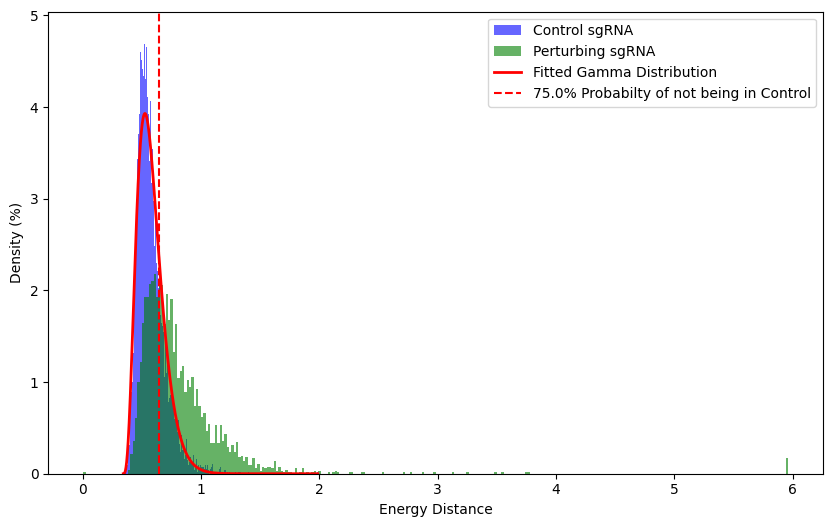

2183/3336 Perturbing sgRNA cross threshold of 0.75


In [4]:
alpha_filtered, alpha_null_distances, alpha_results = qc2.filter_sgRNA_rng(knockdown_adata_alpha, cells_per_ko=25, 
                                                                           rng=step_f_rng, n_jobs=25, 
                                                                           n_permutations=10000)

In [5]:
alpha_filtered = alpha_filtered.copy()

In [6]:
alpha_filtered.write("/home/ranwyl/data_tf_project/Aggregate_ALPHA_sgRNA_Filtered_TF_KO_10kperm.h5ad")

Restart kernel

### Step F (batch ALPHA, seed = 42, 10k permutations)

In [2]:
# Settings for parallel processing with tqdm_joblib
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OMP_MAX_ACTIVE_LEVELS"] = "1"
os.environ["KMP_WARNINGS"] = "0"  # For Intel's OpenMP implementation

# Create numpy default_rng() RNG object
step_f_rand_seed = 42
step_f_rng_42 = np.random.default_rng(step_f_rand_seed)

ALPHA:

In [3]:
knockdown_adata_alpha = ad.read_h5ad("/home/ranwyl/data_tf_project/step_E_output_ALPHA_TF_KO.h5ad")

Use 10,000 permutations for computing the null distribution

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:06)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)
computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 50
    computed neighbors (0:00:16)
    computed connectivities (0:00:07)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:24)


Computing null distribution:   0%|          | 0/25 [00:00<?, ?it/s]

Computing group distances:   0%|          | 0/3336 [00:00<?, ?it/s]

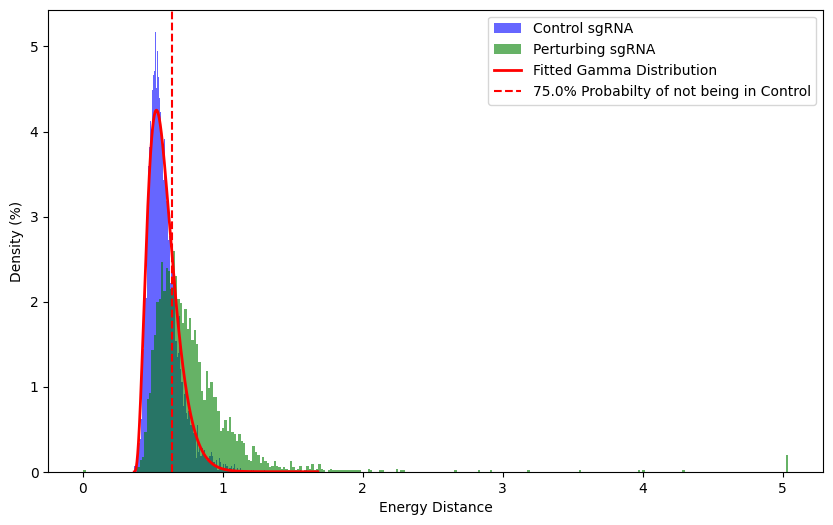

2188/3336 Perturbing sgRNA cross threshold of 0.75


In [4]:
alpha_filtered, alpha_null_distances, alpha_results = qc2.filter_sgRNA_rng(knockdown_adata_alpha, cells_per_ko=25, 
                                                                           rng=step_f_rng_42, n_jobs=25, 
                                                                           n_permutations=10000)

In [5]:
alpha_filtered = alpha_filtered.copy()

In [6]:
alpha_filtered.write("/home/ranwyl/data_tf_project/Aggregate_ALPHA_sgRNA_Filtered_TF_KO_seed42_10kperm.h5ad")

Restart kernel

### Step F (batch ALPHA, seed = 1337, 50k permutations)

Copied from tf_project_qc.ipynb

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:06)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)
computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 50
    computed neighbors (0:00:16)
    computed connectivities (0:00:07)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:24)


Computing null distribution:   0%|          | 0/25 [00:00<?, ?it/s]

Computing group distances:   0%|          | 0/3336 [00:00<?, ?it/s]

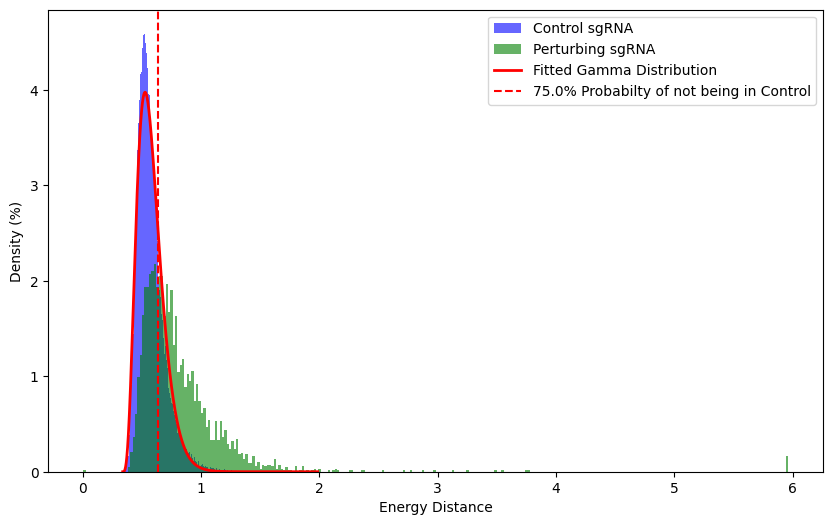

2196/3336 Perturbing sgRNA cross threshold of 0.75


In [ ]:
alpha_filtered, alpha_null_distances, alpha_results = qc2.filter_sgRNA_rng(knockdown_adata_alpha, cells_per_ko=25,
                                                                           rng=step_f_rng, n_jobs=25,
                                                                           n_permutations=50000)

### Step F (batch ALPHA, seed = 42, 50k permutations)

In [2]:
# Settings for parallel processing with tqdm_joblib
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OMP_MAX_ACTIVE_LEVELS"] = "1"
os.environ["KMP_WARNINGS"] = "0"  # For Intel's OpenMP implementation

# Create numpy default_rng() RNG object
step_f_rand_seed = 42
step_f_rng_42 = np.random.default_rng(step_f_rand_seed)

ALPHA:

In [3]:
knockdown_adata_alpha = ad.read_h5ad("/home/ranwyl/data_tf_project/step_E_output_ALPHA_TF_KO.h5ad")

In [4]:
knockdown_adata_alpha

AnnData object with n_obs × n_vars = 289158 × 20200
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std'
    uns: 'log1p'
    layers: 'counts', 'normalized_counts'

Use 50,000 permutations for computing the null distribution

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:06)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)
computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 50
    computed neighbors (0:00:16)
    computed connectivities (0:00:08)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:24)


Computing null distribution:   0%|          | 0/25 [00:00<?, ?it/s]

Computing group distances:   0%|          | 0/3336 [00:00<?, ?it/s]

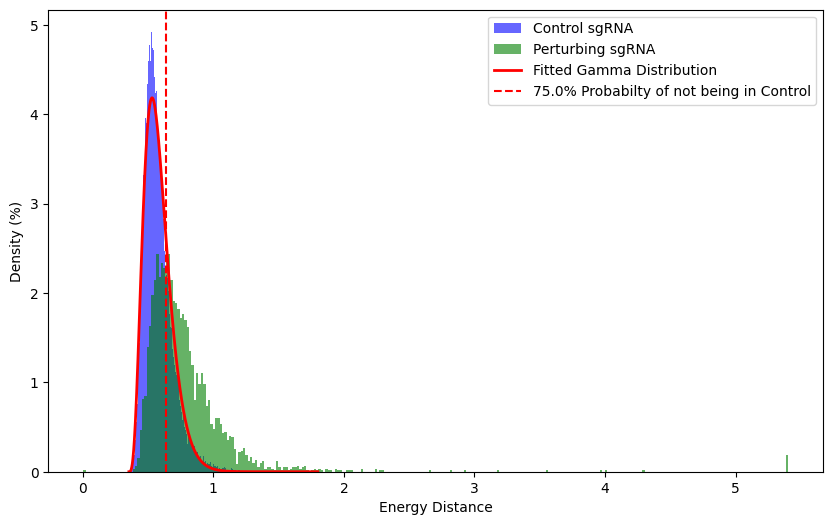

2170/3336 Perturbing sgRNA cross threshold of 0.75


In [5]:
alpha_filtered, alpha_null_distances, alpha_results = qc2.filter_sgRNA_rng(knockdown_adata_alpha, rng=step_f_rng_42,
                                                                           n_permutations=50000, n_jobs=25, 
                                                                           cells_per_ko=25)

In [6]:
alpha_filtered = alpha_filtered.copy()

In [7]:
alpha_filtered.write("/home/ranwyl/data_tf_project/Aggregate_ALPHA_sgRNA_Filtered_TF_KO_seed42_50kperm.h5ad")

Restart kernel

In [3]:
adata_alpha = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_sgRNA_Filtered_TF_KO_seed42_50kperm.h5ad")

In [4]:
adata_alpha

AnnData object with n_obs × n_vars = 189690 × 20200
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std'
    uns: 'log1p'
    layers: 'counts', 'normalized_counts'

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:02)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:11)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


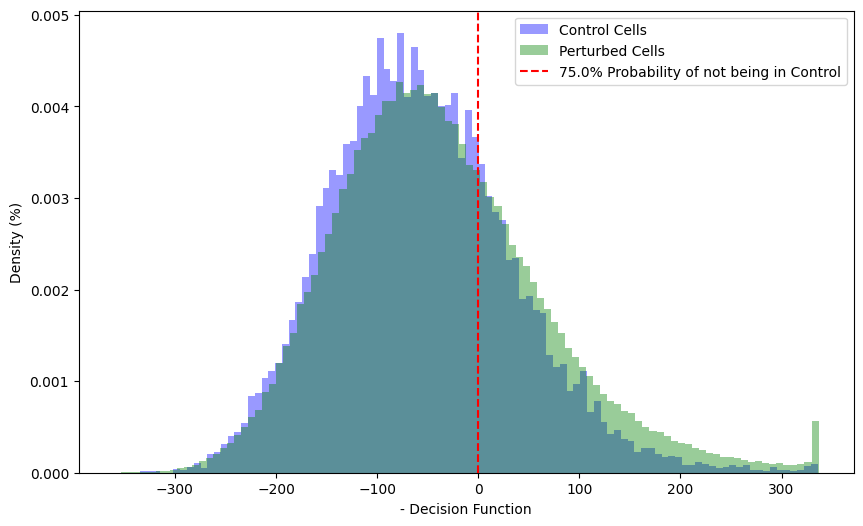

54897/175848 Perturbed Cells cross threshold of 0.75


In [5]:
adata_alpha_filtered, c, p = qc2.remove_unperturbed_cells_random_seed(adata_alpha, threshold=0.75, rand_seed=0)

In [6]:
perturbation_counts = dict(adata_alpha_filtered.obs.gene_target.value_counts())
remaining_perturbations = [k for k,v in perturbation_counts.items() if v >= 25]
print(len(remaining_perturbations),remaining_perturbations)

935 ['NTC', 'ZFP37', 'ARHGAP35', 'VDR', 'ADNP2', 'DNMT1', 'ZBTB21', 'ZSCAN9', 'BHLHE22', 'ZNF426', 'ZNF836', 'NEUROG1', 'ZNF462', 'SHOX2', 'ZFP1', 'CHAMP1', 'ZFP62', 'TIGD3', 'ZNF160', 'ZNF41', 'ETS1', 'ZSCAN26', 'HES6', 'ZNF280B', 'FOXA2', 'TSHZ1', 'ZFP28', 'BCL6B', 'FOXH1', 'ZNF580', 'ZNF787', 'PGR', 'NKX2-4', 'IKZF1', 'ZNF662', 'NANOGNB', 'NANOG', 'PITX3', 'DOT1L', 'ZSCAN5B', 'ZNF563', 'SKOR1', 'PCGF6', 'PRDM13', 'CREM', 'ZNF594', 'FOXG1', 'IRF9', 'POU5F1', 'THAP12', 'ZNF408', 'ZNF396', 'ZNF394', 'PKNOX2', 'CREB3L3', 'RFX2', 'ZZZ3', 'OVOL3', 'ZNF521', 'IRX1', 'IRX4', 'TBX18', 'TBX19', 'DMRT2', 'ZFP2', 'ZNF318', 'ZBTB48', 'HES3', 'NR5A1', 'ZNF418', 'NPAS4', 'FOXD4', 'ZNF623', 'ZNF383', 'TCF21', 'ZNF420', 'KLF14', 'ARX', 'BHLHE40', 'ZNF765', 'BARX1', 'ATF1', 'ZNF132', 'ZBED3', 'ZNF530', 'SIX3', 'ZFY', 'SETDB1', 'ZNF701', 'RREB1', 'REPIN1', 'ZNF10', 'MESP1', 'ZNF534', 'ZNF600', 'LBX2', 'SCX', 'SMAD4', 'GATA2', 'ZNF879', 'ANKZF1', 'BARHL2', 'ZNF783', 'SMYD3', 'ST18', 'ZNF267', 'ZNF461',

In [7]:
adata_alpha_filtered = qc2.remove_perturbations_by_cell_threshold(adata_alpha_filtered)

Removing 274 perturbations for having under 25 cells.


In [8]:
adata_alpha_filtered

AnnData object with n_obs × n_vars = 63743 × 20200
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '

In [9]:
adata_alpha_filtered.write("/home/ranwyl/data_tf_project/Aggregate_ALPHA_Core_Cells_TF_KO_seed42.h5ad")

In [11]:
print(len(adata_alpha_filtered.obs.gene_target.unique().tolist())-1)

934


### Step F (batch ALPHA, seed = 1337, 100k permutations)

Copied from tf_project_qc.ipynb

In [ ]:
# Settings for parallel processing with tqdm_joblib
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OMP_MAX_ACTIVE_LEVELS"] = "1"
os.environ["KMP_WARNINGS"] = "0"  # For Intel's OpenMP implementation

# Create numpy default_rng() RNG object
step_f_rand_seed = 1337
step_f_rng = np.random.default_rng(step_f_rand_seed)

In [ ]:
knockdown_adata_alpha = ad.read_h5ad("/home/ranwyl/data_tf_project/step_E_output_ALPHA_TF_KO.h5ad")

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:06)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)
computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 50
    computed neighbors (0:00:17)
    computed connectivities (0:00:07)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:24)


Computing null distribution:   0%|          | 0/25 [00:00<?, ?it/s]

Computing group distances:   0%|          | 0/3336 [00:00<?, ?it/s]

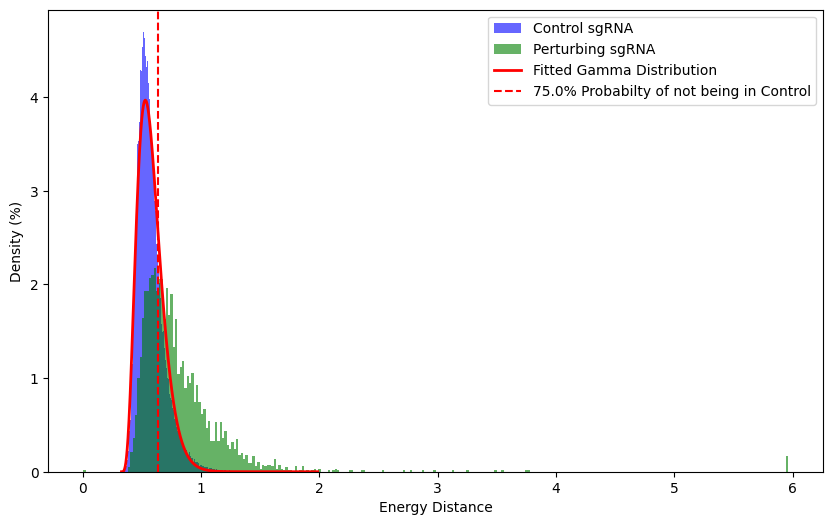

2196/3336 Perturbing sgRNA cross threshold of 0.75


In [ ]:
alpha_filtered, alpha_null_distances, alpha_results = qc2.filter_sgRNA_rng(knockdown_adata_alpha, cells_per_ko=25,
                                                                           rng=step_f_rng, n_jobs=25,
                                                                           n_permutations=100000)

In [ ]:
alpha_filtered = alpha_filtered.copy()

In [ ]:
alpha_filtered.write("/home/ranwyl/data_tf_project/Aggregate_ALPHA_sgRNA_Filtered_TF_KO_100kperm.h5ad")

### Step F (batch ALPHA, seed = 42, 100k permutations)

In [2]:
# Settings for parallel processing with tqdm_joblib
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OMP_MAX_ACTIVE_LEVELS"] = "1"
os.environ["KMP_WARNINGS"] = "0"  # For Intel's OpenMP implementation

# Create numpy default_rng() RNG object
step_f_rand_seed = 42
step_f_rng_42 = np.random.default_rng(step_f_rand_seed)

In [3]:
knockdown_adata_alpha = ad.read_h5ad("/home/ranwyl/data_tf_project/step_E_output_ALPHA_TF_KO.h5ad")

In [4]:
knockdown_adata_alpha

AnnData object with n_obs × n_vars = 289158 × 20200
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std'
    uns: 'log1p'
    layers: 'counts', 'normalized_counts'

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:06)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)
computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 50
    computed neighbors (0:00:16)
    computed connectivities (0:00:08)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:24)


Computing null distribution:   0%|          | 0/25 [00:00<?, ?it/s]

Computing group distances:   0%|          | 0/3336 [00:00<?, ?it/s]

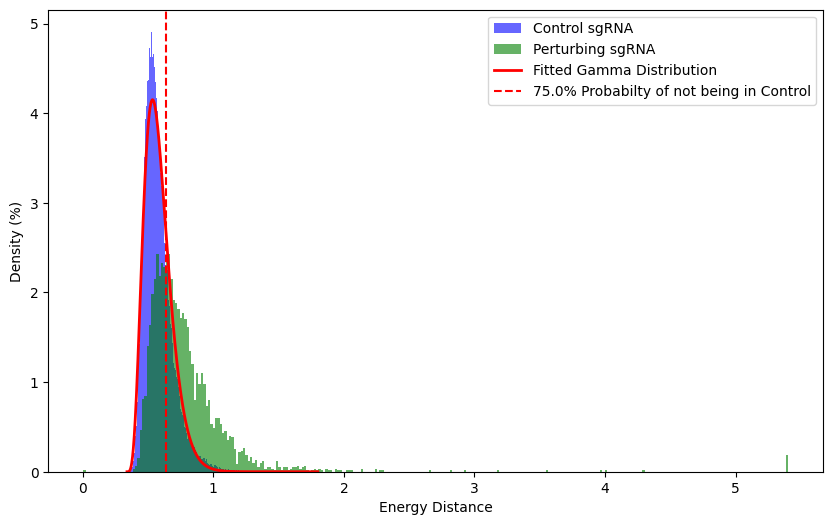

2168/3336 Perturbing sgRNA cross threshold of 0.75


In [5]:
alpha_filtered, alpha_null_distances, alpha_results = qc2.filter_sgRNA_rng(knockdown_adata_alpha, rng=step_f_rng_42,
                                                                           n_permutations=100000, n_jobs=25, 
                                                                           cells_per_ko=25)

In [6]:
alpha_filtered = alpha_filtered.copy()

In [7]:
alpha_filtered.write("/home/ranwyl/data_tf_project/Aggregate_ALPHA_sgRNA_Filtered_TF_KO_seed42_100kperm.h5ad")

## Compare datasets after step F

In [6]:
def get_kos(adata):
    kos = adata.obs.gene_target.unique().tolist()
    kos = set(kos)
    if "NTC" in kos:
        kos.remove("NTC")
    return kos

def get_kds(adata):
    kds = adata.obs.gene_target.unique().tolist()
    kds = set(kds)
    if "NTC" in kds:
        kds.remove("NTC")
    return kds

def plot_venn2(set1, set2, label1, label2, title=None, color1="red", color2="green"):
    plt.rcParams['font.size'] = 16
    venn2(subsets = [set1, set2], set_labels = (label1, label2),
        set_colors = (color1, color2), alpha=0.4)
    if title:
        plt.title(title, fontsize=18)
    plt.show()

def plot_venn3(set1, set2, set3, label1, label2, label3, title=None, color1="red", color2="green", color3="blue"):
    plt.rcParams['font.size'] = 14
    venn3(subsets=[set1, set2, set3], 
          set_labels=(label1, label2, label3), 
          set_colors=(color1, color2, color3), alpha=0.4)
    if title:
        plt.title(title, fontsize=18)
    plt.show()

In [3]:
adata_1337_10k = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_sgRNA_Filtered_TF_KO_10kperm.h5ad", backed="r")
adata_1337_50k = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_sgRNA_Filtered_TF_KO_50kperm.h5ad", backed="r")
adata_1337_100k = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_sgRNA_Filtered_TF_KO_100kperm.h5ad", backed="r")
adata_42_10k = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_sgRNA_Filtered_TF_KO_seed42_10kperm.h5ad", backed="r")
adata_42_50k = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_sgRNA_Filtered_TF_KO_seed42_50kperm.h5ad", backed="r")
adata_42_100k = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_sgRNA_Filtered_TF_KO_seed42_100kperm.h5ad", backed="r")

In [4]:
tf_kos_1337_10k = get_kos(adata_1337_10k)
tf_kos_1337_50k = get_kos(adata_1337_50k)
tf_kos_1337_100k = get_kos(adata_1337_100k)
tf_kos_42_10k = get_kos(adata_42_10k)
tf_kos_42_50k = get_kos(adata_42_50k)
tf_kos_42_100k = get_kos(adata_42_100k)

In [6]:
for tf_ko_set in (tf_kos_1337_10k, tf_kos_1337_50k, tf_kos_1337_100k, tf_kos_42_10k, tf_kos_42_50k, tf_kos_42_100k):
    print(len(tf_ko_set))

1230
1235
1235
1213
1208
1208


Check that the 50k permutation and 100k permutation conditions yield the same TF KOs

In [9]:
print(tf_kos_1337_100k - tf_kos_1337_50k)
print(tf_kos_42_100k - tf_kos_42_50k)

set()
set()


In [10]:
print(len(tf_kos_1337_50k & tf_kos_42_50k))

1119


In [3]:
adata_1337_50k = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_sgRNA_Filtered_TF_KO_50kperm.h5ad", backed="r")
adata_42_50k = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_sgRNA_Filtered_TF_KO_seed42_50kperm.h5ad", backed="r")

In [4]:
tf_kos_1337_50k = get_kos(adata_1337_50k)
tf_kos_42_50k = get_kos(adata_42_50k)

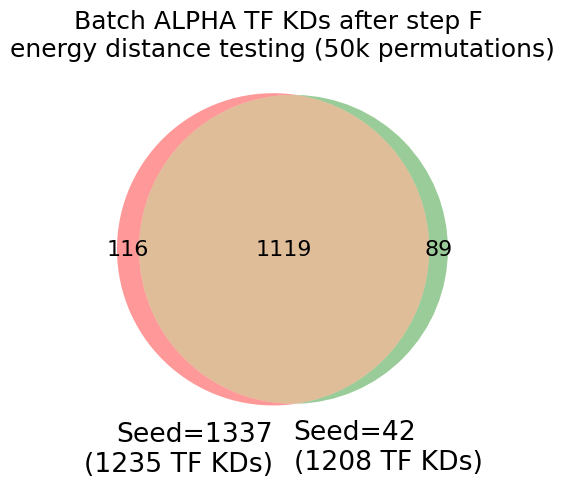

In [5]:
plot_venn2(tf_kos_1337_50k, tf_kos_42_50k, "Seed=1337\n(1235 TF KDs)", "Seed=42\n(1208 TF KDs)",
           "Batch ALPHA TF KDs after step F \nenergy distance testing (50k permutations)")

In [6]:
adata_1337 = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_Core_Cells_TF_KO.h5ad", backed="r")
adata_42 = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_Core_Cells_TF_KO_seed42.h5ad", backed="r")

In [7]:
tf_kos_1337 = get_kos(adata_1337)
tf_kos_42 = get_kos(adata_42)
print(len(tf_kos_1337))
print(len(tf_kos_42))

968
934


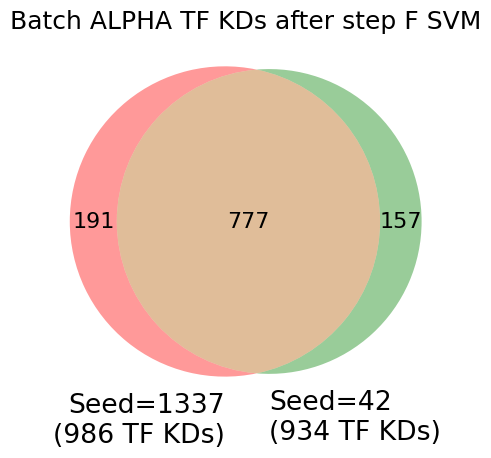

In [8]:
plot_venn2(tf_kos_1337, tf_kos_42, "Seed=1337\n(986 TF KDs)", "Seed=42\n(934 TF KDs)",
           "Batch ALPHA TF KDs after step F SVM")

Compare to old dataset

In [4]:
adata_alpha_new = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_Core_Cells_TF_KO.h5ad")
adata_beta_new = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_BETA_Core_Cells_TF_KO.h5ad")
adata_new = ad.concat([adata_alpha_new, adata_beta_new])
adata_new

AnnData object with n_obs × n_vars = 77912 × 20200
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts'

In [5]:
tf_kos_new = get_kos(adata_new)

In [8]:
print(len(tf_kos_new))

975


In [6]:
adata_old = sc.read_h5ad("/home/ranwyl/data_tf_project/old_5MADs_Aggregate_TF_KO_Batch_Normalized.h5ad", backed="r")

In [7]:
tf_kos_old = get_kos(adata_old)

In [9]:
print(len(tf_kos_old))

652


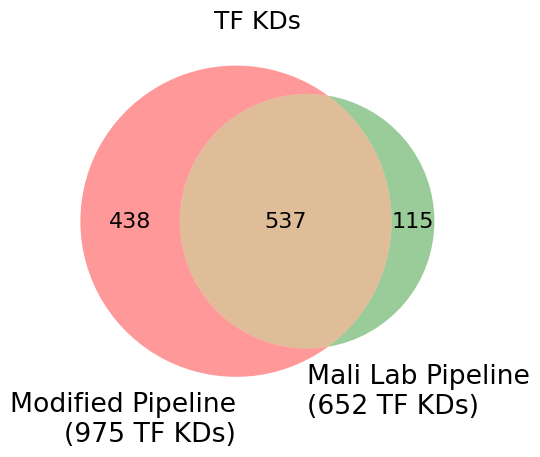

In [12]:
plot_venn2(tf_kos_new, tf_kos_old, "Modified Pipeline\n(975 TF KDs)", "Mali Lab Pipeline\n(652 TF KDs)",
           "TF KDs")

# Fall Week 1 Gene Filter (20 cells) Testing

**QC pipeline steps A-F with TF KD and NTC cell filtering after step C and gene filtering = remove genes expressed in <20 cells**

The `perturb_seq_heuristic_pipeline.py` file containing the QC and analysis pipeline from Nourreddine et al was imported as `qc`. Functions from `Pan_Genome_Analysis.ipynb`, a notebook containing additional code from Nourreddine et al, were pasted into a file `pan_genome_analysis_functions.py` which was imported as `qc2`.

## Initial data read-in

We will read in the Perturb-seq single-cell dataset `.h5mu` file as a `MuData` object, `mdata`.

`mdata` contains two modalities which are `AnnData` objects: `rna` (cell-by-gene matrix) and `crispr` (cell-by-knockout matrix)
- `rna`: 5386783 cells x 38606 features  
    - Features = expression of each human gene measured in the dataset
    - `.obs` = cell barcodes, `.var` = features = genes
- `crispr`: 5386783 cells x 35989 features
    - Features = CRISPR sgRNAs (3 sgRNAs per gene target * 11739 gene targets, plus 478 non-targeting control sgRNAs)
    - `.obs` = cell barcodes, `.var` = features = knockouts

We will be working with the `rna` modality for the majority of the analysis. We will assign it to the variable `adata`.

In [ ]:
md_filepath = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Aggregate.h5mu"
mdata = mu.read_h5mu(md_filepath)
adata = mdata.mod["rna"]

In [ ]:
crispr = mdata.mod['crispr']

## Step B: Assigning sgRNA to cells and de facto doublet detection

The lists of cells and genes provided by the Mali lab are the output of step D; however, steps E through F require metadata annotation, meaning that it would make the most sense to run the pipeline on the `KOLF_Pan_Genome_Aggregate.h5mu` file through step F. First, we will run step B: assigning sgRNA to cells based on the protospacer calls and removing cells without exactly one sgRNA assigned (cells with < 1 sgRNA assigned must be removed, and cells with > 1 sgRNA assigned are considered de facto multiplets).

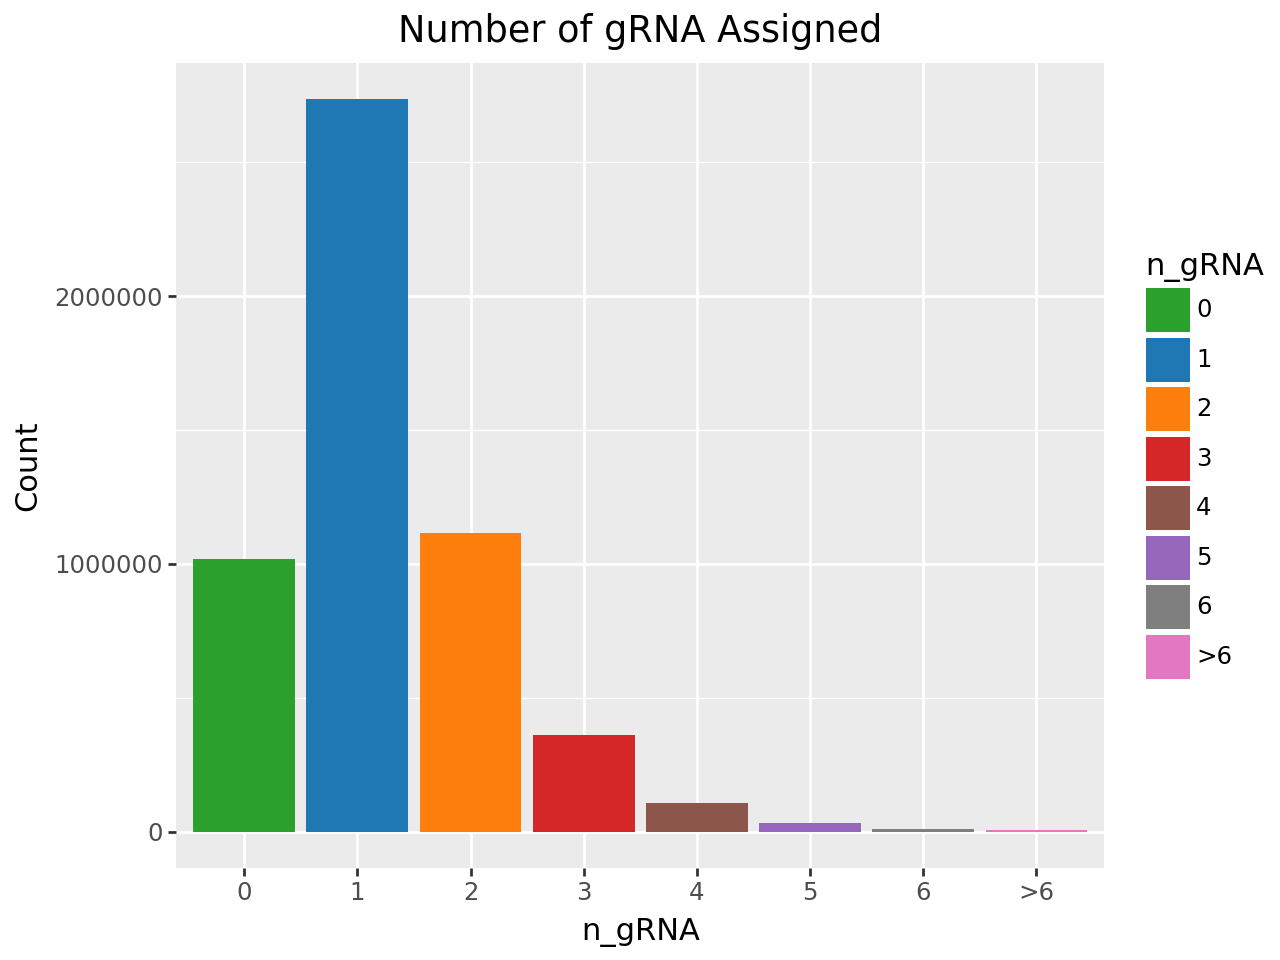

Cells without confident sgRNA calls: 18.89%
Estimated Multiplet Rate: 30.33%


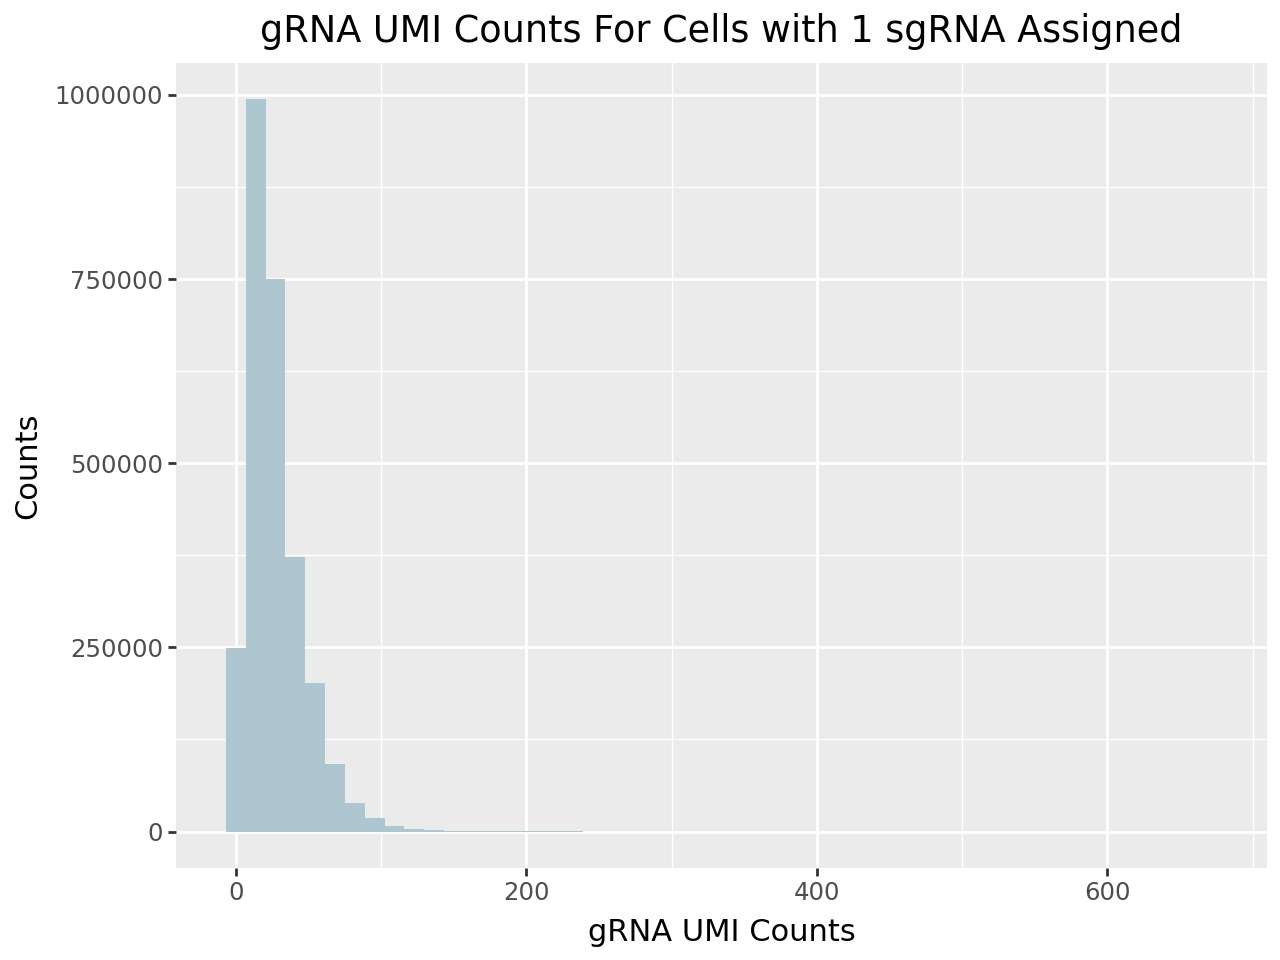

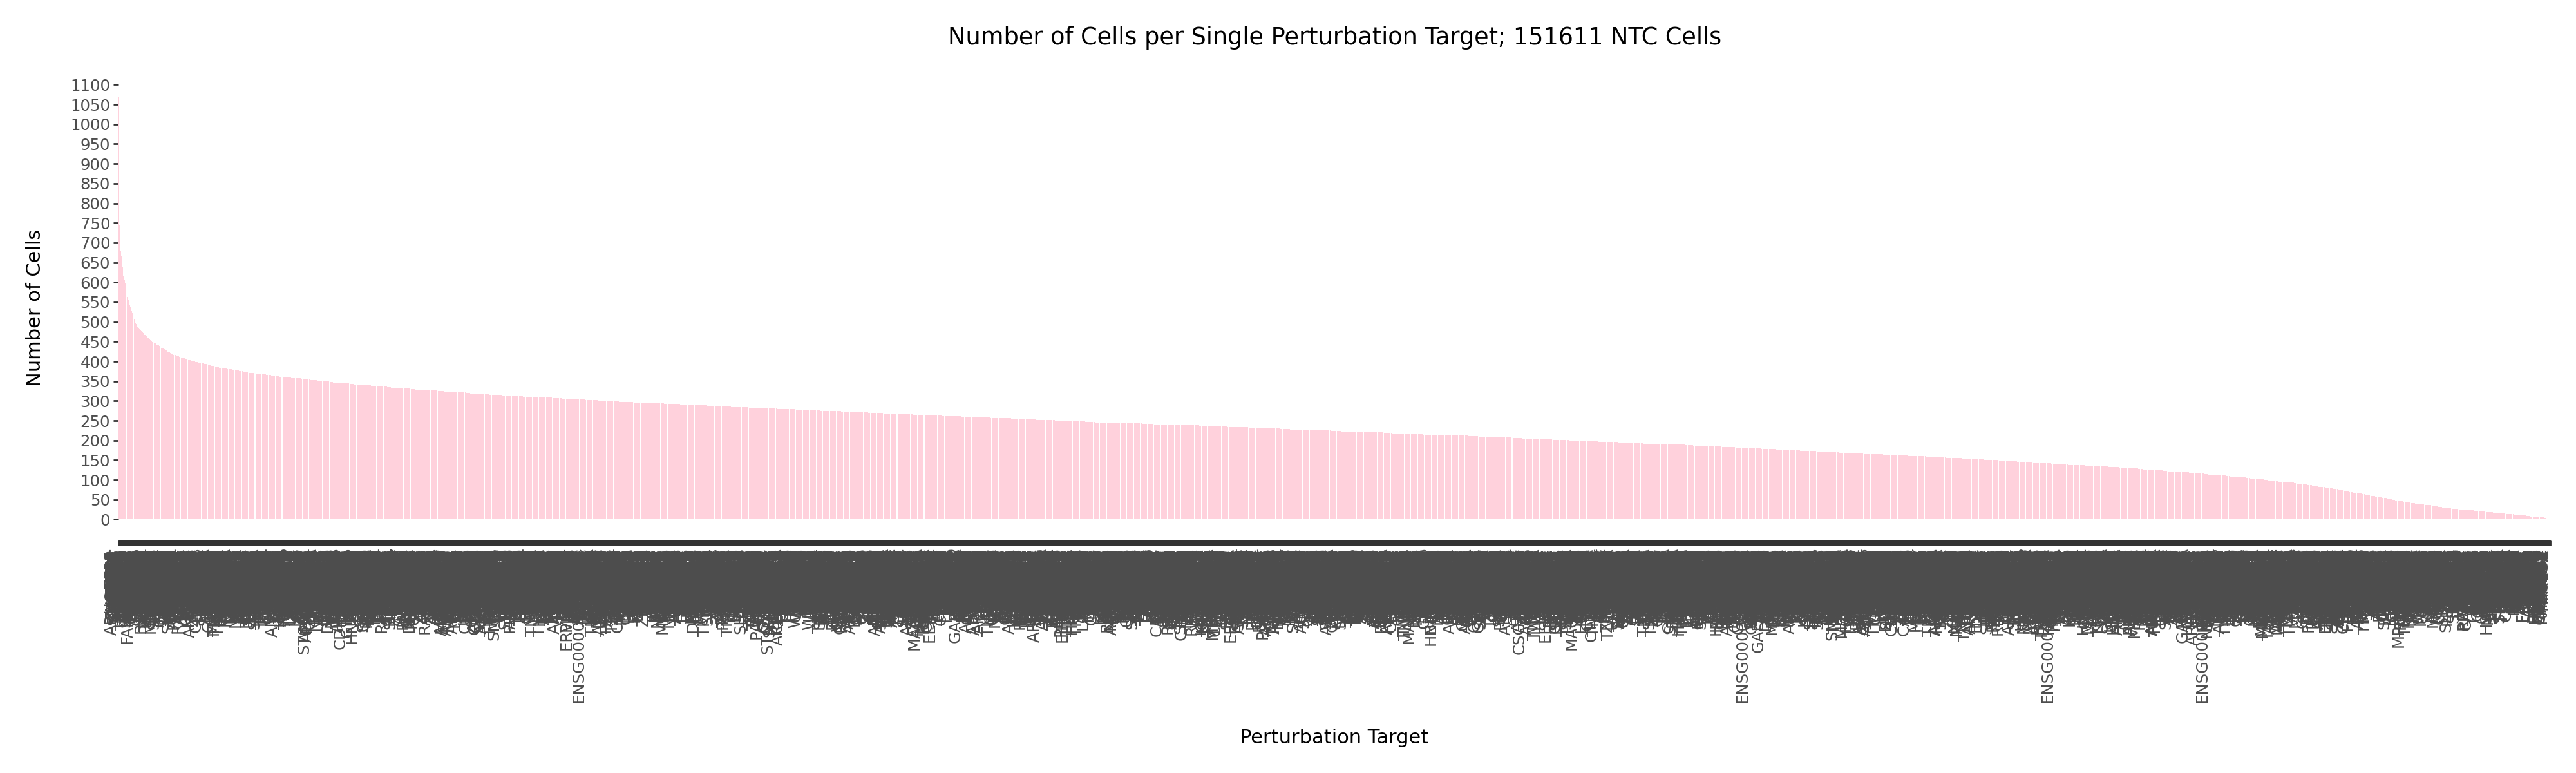

Number of perturbations with >= 50 cells with single guide assigned: 10933/11687 (93.55%)


In [ ]:
protospacer_calls_file_path = "/home/ranwyl/data_tf_project/protospacer_calls_per_cell.csv"
adata = qc.assign_protospacers(adata,protospacer_calls_file_path=protospacer_calls_file_path)

## Step C: Cell-level QC

Now we will run step C, cell-level QC. First, we assign metadata:

In [ ]:
aggregation_csv_file_path = "/home/ranwyl/data_tf_project/aggregation_csv.csv"
d = pd.read_csv(aggregation_csv_file_path)
channel_dict = {str(i+1):channel for i,channel in enumerate(d["sample_id"])}
adata = qc.assign_metadata(adata=adata,cell_type="KOLF2.1J iPSC",perturbation_type="CRISPRi Perturb-Seq",channel_dict=channel_dict)
adata.obs['n_gRNA_UMIs'] = adata.obs['n_gRNA_UMIs'].astype(str)

/home/ranwyl/data_tf_project/perturb_seq_heuristic_pipeline.py:175: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


In [ ]:
adata

AnnData object with n_obs × n_vars = 2735450 × 38606
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells'

Remove genes not detected in any cells

normalizing counts per cell
    finished (0:01:17)


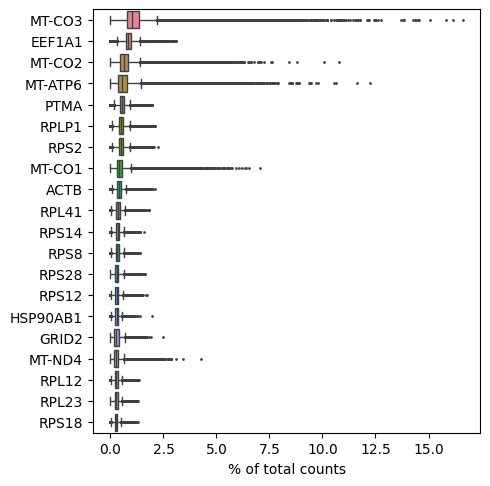

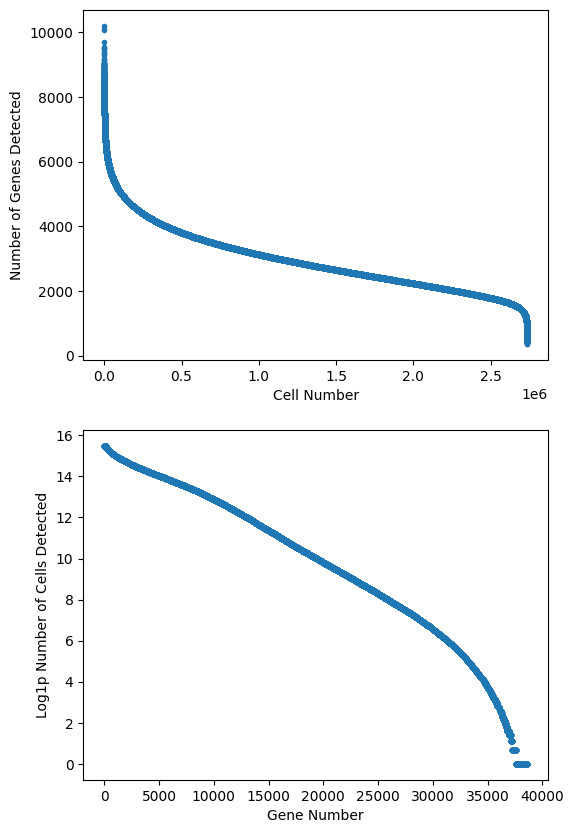

Removing 1039 genes not detected in any cells.


In [ ]:
adata = qc.general_qc(adata)

Perform QC with automatic thresholding based on median absolute deviations (MADs) for log1p_total_counts, lop1p_n_genes_by_counts, pct_counts_in_top_20_genes, and pct_counts_mt using scanpy's calculate_qc_metrics() with cumulative proportion to the 20th most expressed gene (percent_top=[20]).

Sept 7 2025: Filter on 3 count MADs and 5 mitochondrial MADs (see tf_project_qc_testing.ipynb for notes)

/home/ranwyl/data_tf_project/perturb_seq_heuristic_pipeline.py:201: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.


outlier
False    2502888
True      232562
Name: count, dtype: int64

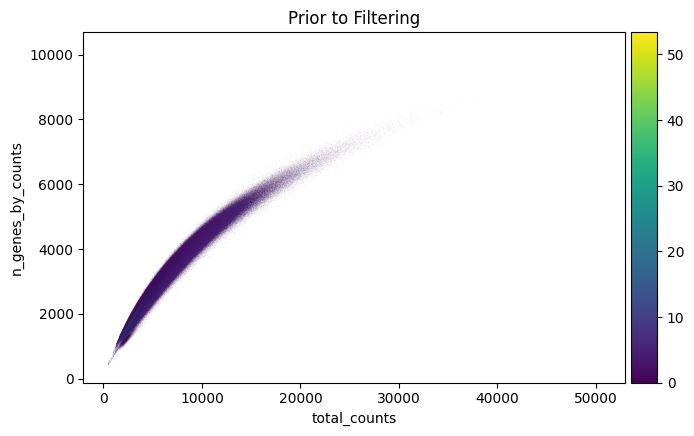

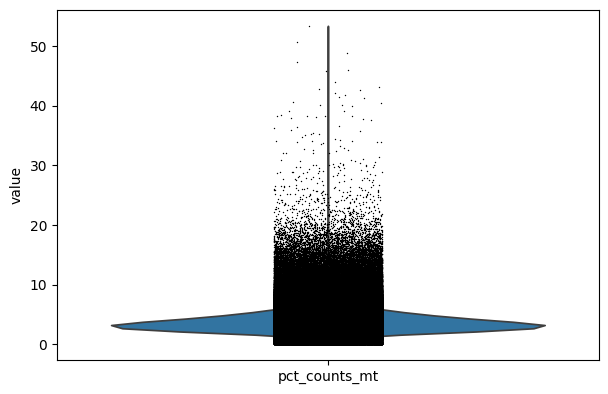

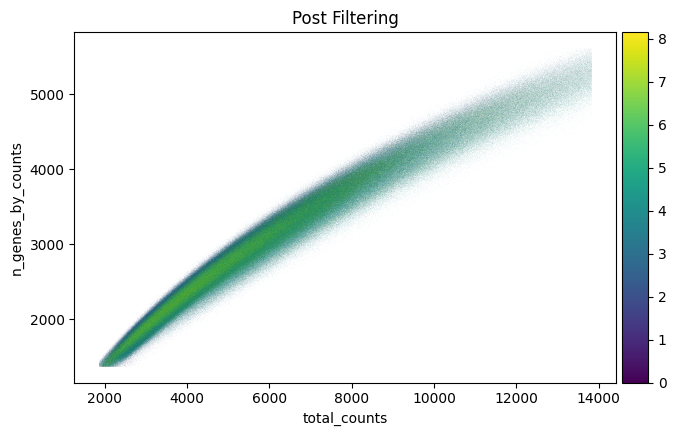

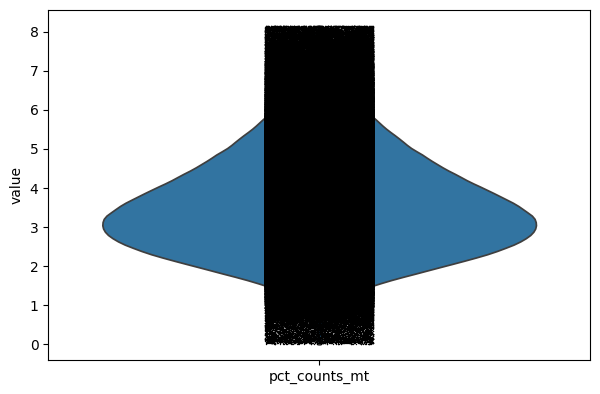

In [ ]:
adata35 = qc.dead_cell_qc(adata, count_MADs=3, mt_MADs=5, ribo_MADs=5)

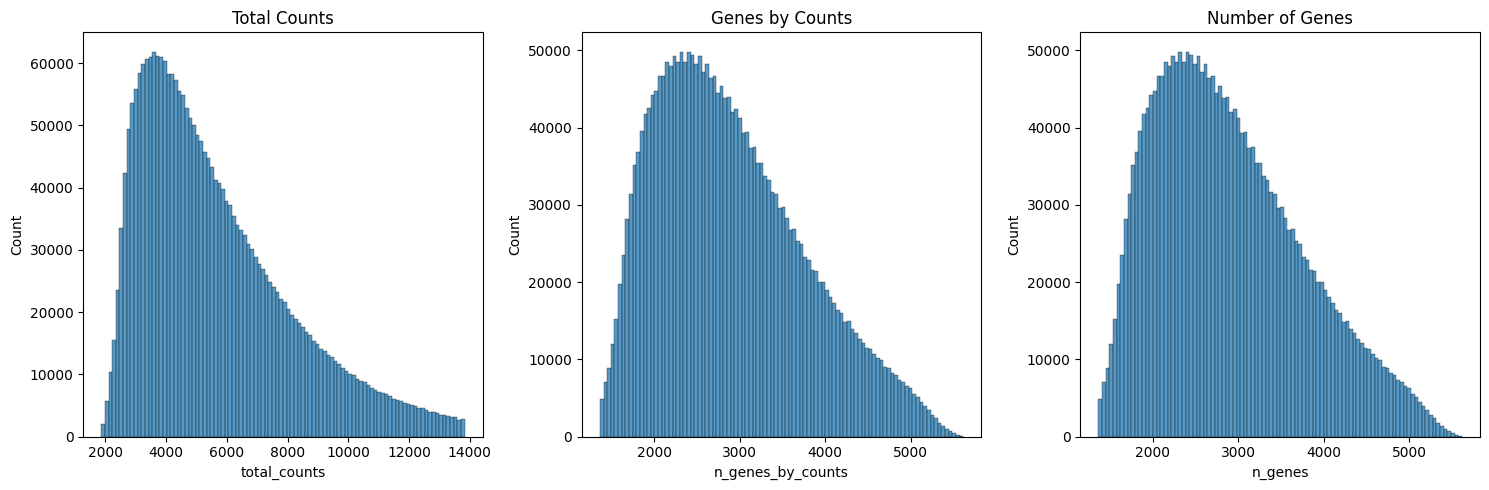

In [ ]:
qc.doublet_detection_sanity_check(adata35)

In [ ]:
adata35.write("/home/ranwyl/data_tf_project/Aggregate_Basic_QC_Cell_QC.h5ad")

## Filter cells (NTC and TF KD) and genes (expressed in <20 cells)

Filter cells, keeping NTC cells that passed fitness testing and TF KD cells only. Then filter genes expressed in fewer than 10 cells.

In [ ]:
adata = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_Basic_QC_Cell_QC.h5ad")

Save raw counts and create `run` metadata column in `obs`:

In [ ]:
adata.layers["counts"] = adata.X.copy()
adata.obs["run"] = [label.split('-')[0] for label in adata.obs.channel]
adata

In [ ]:
adata.obs.perturbed.value_counts()

perturbed
True     2364614
False     138274
Name: count, dtype: int64

Filter NTC cells based on provided whitelist of NTC cells that passed fitness testing. Filter TF KO cells based on list of TFs from Lambert et al. (2018).

In [ ]:
def filter_ntc_whitelist_and_tf_ko_cells(adata, ntc_filepath, tf_set):
    """
    Filter NTC cells based on provided whitelist of NTC cells that passed fitness testing.
    Filter KO cells that are TF KOs based on provided set of TFs.
    """
    with open(ntc_filepath, "r") as f:
        sgRNA_whitelist = f.read().splitlines()
    return adata[(adata.obs.gRNA.isin(sgRNA_whitelist)) | (adata.obs.gene_target.isin(tf_set))].copy()

In [ ]:
# List of 1639 TFs from Lambert et al (2018)
lambert_csv = pd.read_csv("Lambert_2018_TFs.csv")
lambert_tfs = lambert_csv[lambert_csv.iloc[:,3] == "Yes"].iloc[:,1].tolist()
lambert_tfs = set(lambert_tfs)

# NTC whitelist
whitelist_filepath = "/home/ranwyl/data_tf_project/NTC_sgRNA_whitelist.txt"

# Filter adata
adata = filter_ntc_whitelist_and_tf_ko_cells(adata, whitelist_filepath, lambert_tfs)

In [ ]:
adata

AnnData object with n_obs × n_vars = 451878 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'counts'

In [ ]:
adata.obs.perturbed.value_counts()

perturbed
True     401550
False     50328
Name: count, dtype: int64

Check which TFs from Lambert et al. (2018) are KOs in the dataset

In [ ]:
gene_targets = adata.obs.gene_target.tolist()
gene_targets.remove("NTC")
gene_targets = set(gene_targets)
lambert_tfs_in_dataset_kos = lambert_tfs & gene_targets
print(len(lambert_tfs_in_dataset_kos))

1610


Save intermediate file

In [ ]:
adata.write("/home/ranwyl/data_tf_project/Aggregate_Basic_QC_Cell_QC_Cell_Filt.h5ad")

Restart kernel and read in data

In [ ]:
adata = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_Basic_QC_Cell_QC_Cell_Filt.h5ad")

In [ ]:
adata

AnnData object with n_obs × n_vars = 451878 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'counts'

<Axes: xlabel='count', ylabel='Count'>

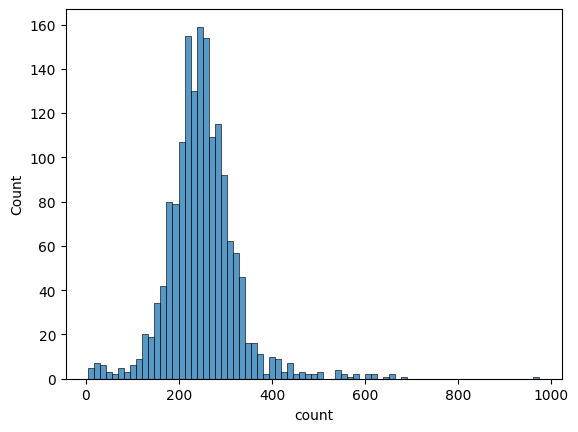

In [ ]:
cells_per_pert = adata.obs.gene_target.value_counts()
cells_per_pert.drop("NTC", inplace=True)
sns.histplot(cells_per_pert)

Filter percentage of genes with lowest expression and genes expressed in a low number of cells

In [ ]:
# List of 1639 TFs from Lambert et al (2018)
lambert_csv = pd.read_csv("Lambert_2018_TFs.csv")
lambert_tfs = lambert_csv[lambert_csv.iloc[:,3] == "Yes"].iloc[:,1].tolist()
lambert_tfs = set(lambert_tfs)

def filter_low_expressed_genes(adata, tf_set, percent_threshold=None, min_n_cells=None, silent=False):
    """
    Filter out bottom percentile of genes with lowest expression (normalized and
    log1p-transformed) and genes expressed in fewer than min_n_cells cells.
    Do not filter out genes that are TFs in tf_set.
    """
    n_genes_before = adata.shape[1]
    # Create data matrix
    if silent == False:
        print("Copying data")
    data_matrix = adata.layers["counts"] if "counts" in adata.layers else adata.X
    data_matrix = data_matrix.copy()
    # Convert from sparse to dense if necessary
    if hasattr(data_matrix, 'toarray'):
        if silent == False:
            print("Converting data from sparse to dense")
        data_matrix = data_matrix.toarray()
    
    # Filter genes expressed in fewer than min_n_cells cells
    if min_n_cells:
        if silent == False:
            print("Applying cell number threshold")
        # Create mask for TFs
        tf_mask = adata.var_names.isin(tf_set)
        # Calculate number of cells expressing each gene
        gene_detected_counts = (data_matrix > 0).sum(axis=0)
        # Set cell number threshold and filter genes
        genes_pass_cell_thr = gene_detected_counts >= min_n_cells
        genes_to_keep = genes_pass_cell_thr | tf_mask
        data_matrix = data_matrix[:, genes_to_keep]
        adata = adata[:, genes_to_keep]

    # Filter bottom percentile of genes by expression
    if percent_threshold:
        if silent == False:
            print("Applying percentile threshold")
        # Normalize
        if silent == False:
            print("Normalizing (CPM)")
        cell_sums = data_matrix.sum(axis=1, keepdims=True)
        data_matrix = data_matrix / cell_sums * 1e6
        # Log1p transform
        if silent == False:
            print("Log1p transforming")
        data_matrix = np.log1p(data_matrix)
        # Create mask for TFs
        tf_mask = adata.var_names.isin(tf_set)
        # Calculate mean expression of each gene
        col_values = data_matrix.mean(axis=0)
        # Set percent threshold and filter genes
        threshold = np.percentile(col_values, percent_threshold)
        genes_pass_pct_thr = col_values > threshold
        genes_to_keep = genes_pass_pct_thr | tf_mask
        adata = adata[:,genes_to_keep]
    
    print(f"Removed {n_genes_before - adata.shape[1]} genes")
    del data_matrix
    gc.collect()
    return adata.copy()

def histogram_mean_norm_expression(adata, title="Histogram of Mean Gene Expression", 
                              n_bins=75, ymax=None, show_labels=False, silent=False):
    plt.rcParams["font.size"] = 14
    # Create data matrix
    if silent == False:
        print("Copying data")
    data_matrix = adata.layers["counts"] if "counts" in adata.layers else adata.X
    data_matrix = data_matrix.copy()
    # Convert from sparse to dense if necessary
    if hasattr(data_matrix, 'toarray'):
        print("Converting data from sparse to dense")
        data_matrix = data_matrix.toarray()
    # Normalize
    print("Normalizing (CPM)")
    cell_sums = data_matrix.sum(axis=1, keepdims=True)
    data_matrix = data_matrix / cell_sums * 1e6
    # Log1p transform
    print(f"Log1p tranforming")
    data_matrix = np.log1p(data_matrix)

    # Plot mean expression
    mean_expr = data_matrix.mean(axis=0)
    plt.figure(figsize=(8,4)) if show_labels else plt.figure(figsize=(6,4))
    ax = sns.histplot(mean_expr, bins=n_bins, kde=False)
    plt.xlabel("Mean expression per gene (norm & log1p)")
    plt.ylabel("Number of genes")
    plt.title(title, fontsize=15)
    if ymax:
        ax.set_ylim(0, ymax)
    if show_labels:
        ax.bar_label(ax.containers[0], rotation=90, padding=3, fontsize=10)
    plt.tight_layout()
    plt.show()
    del data_matrix
    gc.collect()

def histogram_cells_expressing_gene(adata, title="Histogram of # Cells Expressing a Gene", 
                                    n_bins=75, ymax=None, show_labels=False):
    plt.rcParams["font.size"] = 14
    # Use raw counts
    count_matrix = adata.X if "counts" not in adata.layers else adata.layers["counts"]
    count_matrix = count_matrix.copy()
    # Convert from sparse to dense if necessary
    if hasattr(count_matrix, 'toarray'):
        count_matrix = count_matrix.toarray()
    # Plot number of cells expressing each gene
    gene_detected_counts = (count_matrix > 0).sum(axis=0)
    plt.figure(figsize=(8,4)) if show_labels else plt.figure(figsize=(6,4))
    ax = sns.histplot(gene_detected_counts, bins=n_bins, kde=False)
    plt.xlabel("Number of cells in which gene is expressed")
    plt.ylabel("Number of genes")
    plt.title(title, fontsize=15)
    if ymax:
        ax.set_ylim(0, ymax)
    if show_labels:
        ax.bar_label(ax.containers[0], rotation=90, padding=3, fontsize=10)
    plt.tight_layout()
    plt.show()
    del count_matrix
    gc.collect()

Plot histograms before filtering genes

Copying data
Converting data from sparse to dense
Normalizing (CPM)
Log1p tranforming


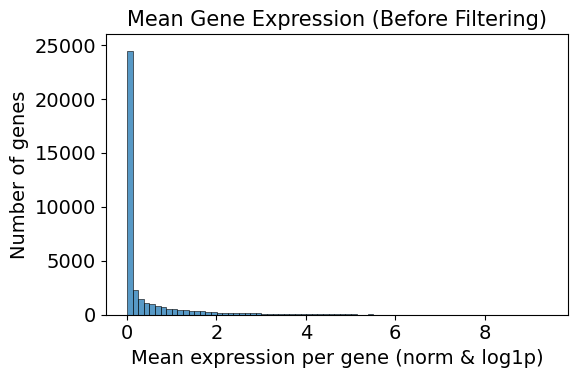

In [ ]:
histogram_mean_norm_expression(adata, title="Mean Gene Expression (Before Filtering)", ymax=26000)

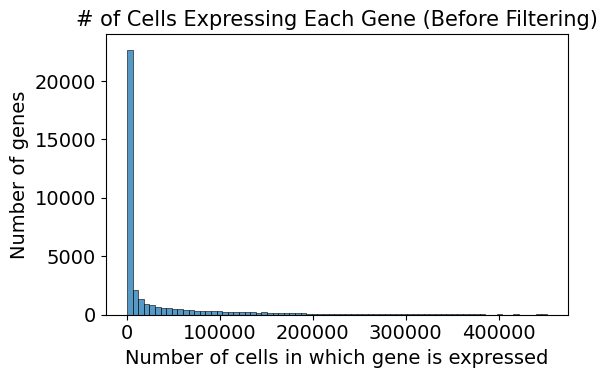

In [ ]:
histogram_cells_expressing_gene(adata, title="# of Cells Expressing Each Gene (Before Filtering)", ymax=24000)

Filter genes that are expressed in fewer than 20 cells, while keeping all TFs.

(Note: there were 20200 genes remaining after removing 30% of genes with lowest expression and genes expressed in <100 cells)

In [ ]:
adata_filtered = filter_low_expressed_genes(adata, lambert_tfs, 
                    percent_threshold=0, min_n_cells=20, silent=False)

Copying data
Converting data from sparse to dense


Applying cell number threshold
Removed 5449 genes


In [ ]:
adata_filtered

AnnData object with n_obs × n_vars = 451878 × 32118
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'counts'

In [ ]:
adata_filtered.write("/home/ranwyl/data_tf_project/Aggregate_Basic_QC_Cell_Gene_QC_TF_KD.h5ad")

Copying data
Converting data from sparse to dense
Normalizing (CPM)
Log1p tranforming


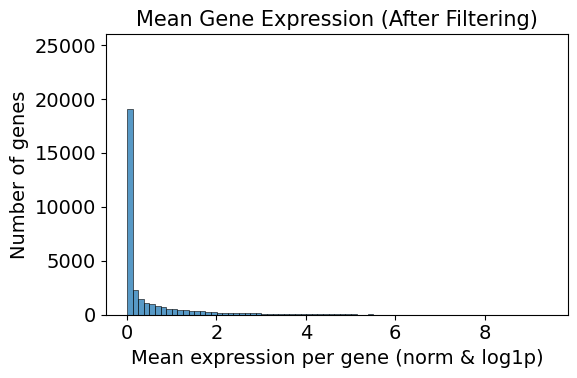

In [ ]:
histogram_mean_norm_expression(adata_filtered, title="Mean Gene Expression (After Filtering)", ymax=26000)

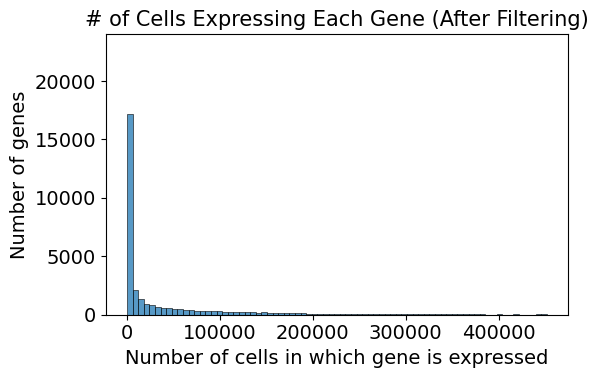

In [ ]:
histogram_cells_expressing_gene(adata_filtered, title="# of Cells Expressing Each Gene (After Filtering)", ymax=24000)

Restart kernel

## Step D: Isolating Core NTC Cells 

Read in QC-passed data:

In [ ]:
adata = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_Basic_QC_Cell_Gene_QC_TF_KD.h5ad")
adata

AnnData object with n_obs × n_vars = 451878 × 32118
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'counts'

**Step D with modified RNG functions and PCA random seed = 0**

Use isolation forest model with 30% contamination fraction to isolate core NTC cells. Use modified version of scrub_ntc() that uses random seeds for PCA and isolation forest model:

Initial number of NTC Cells: 50328
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    386 total control genes are used. (0:00:01)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    297 total control genes are used. (0:00:01)
-->     'phase', cell cycle phase (adata.obs)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=100
    finished (0:00:07)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adat

  0%|          | 0/200 [00:00<?, ?it/s]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:30)


/home/ranwyl/pymde_env/lib64/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/home/ranwyl/pymde_env/lib64/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/home/ranwyl/pymde_env/lib64/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


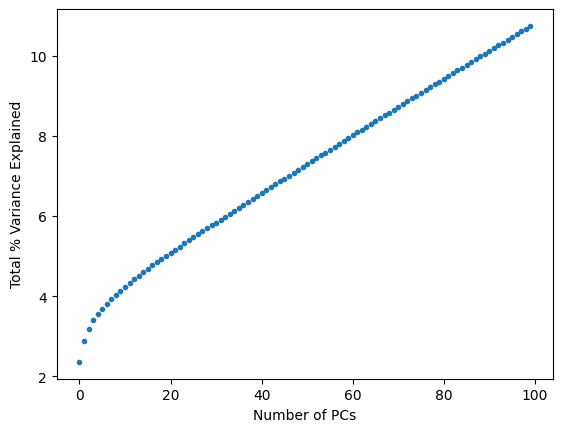

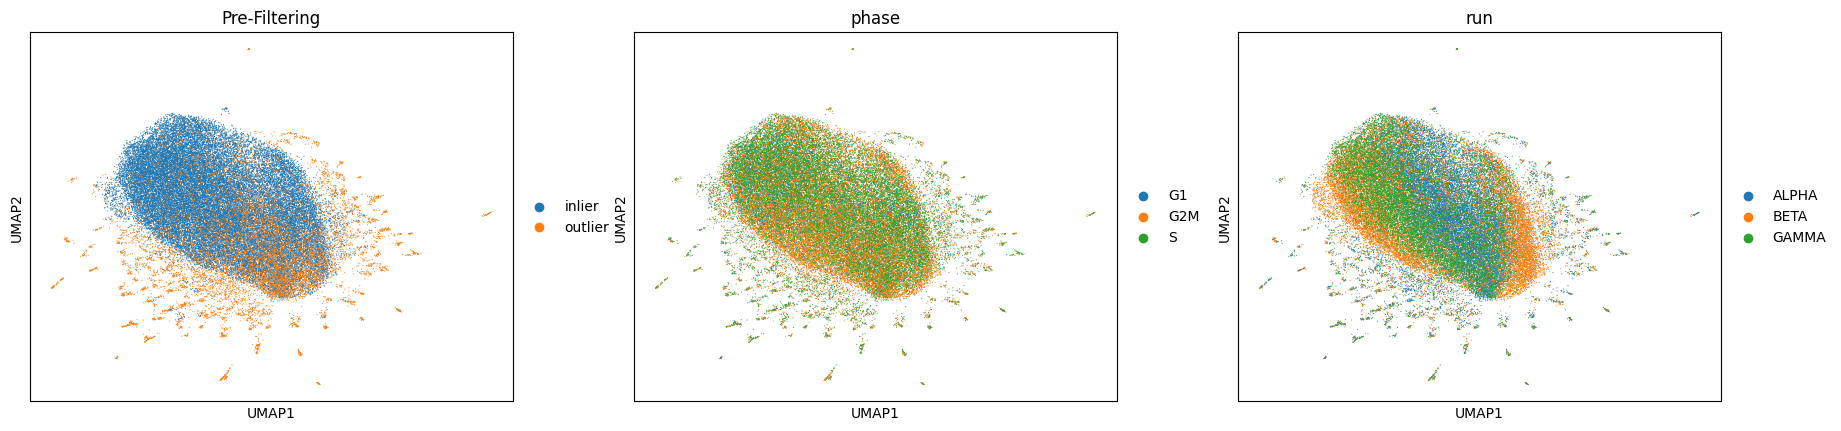

computing density on 'umap'
--> added
    'umap_density', densities (adata.obs)
    'umap_density_params', parameter (adata.uns)


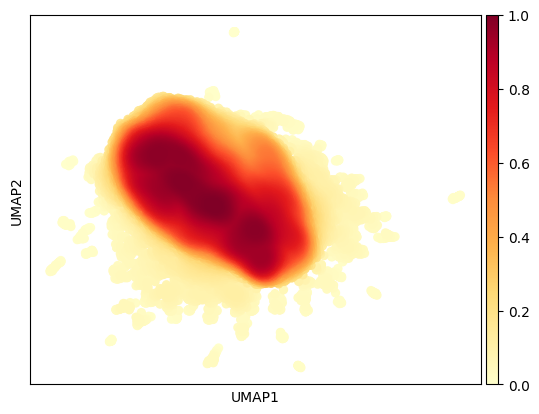

computing neighbors
        initialized `.distances` `.connectivities` 
    computing neighbors
    computed neighbors (0:00:02)
    computed connectivities (0:00:02)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:26)
computing UMAP


  0%|          | 0/200 [00:00<?, ?it/s]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:21)


/home/ranwyl/pymde_env/lib64/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/home/ranwyl/pymde_env/lib64/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/home/ranwyl/pymde_env/lib64/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


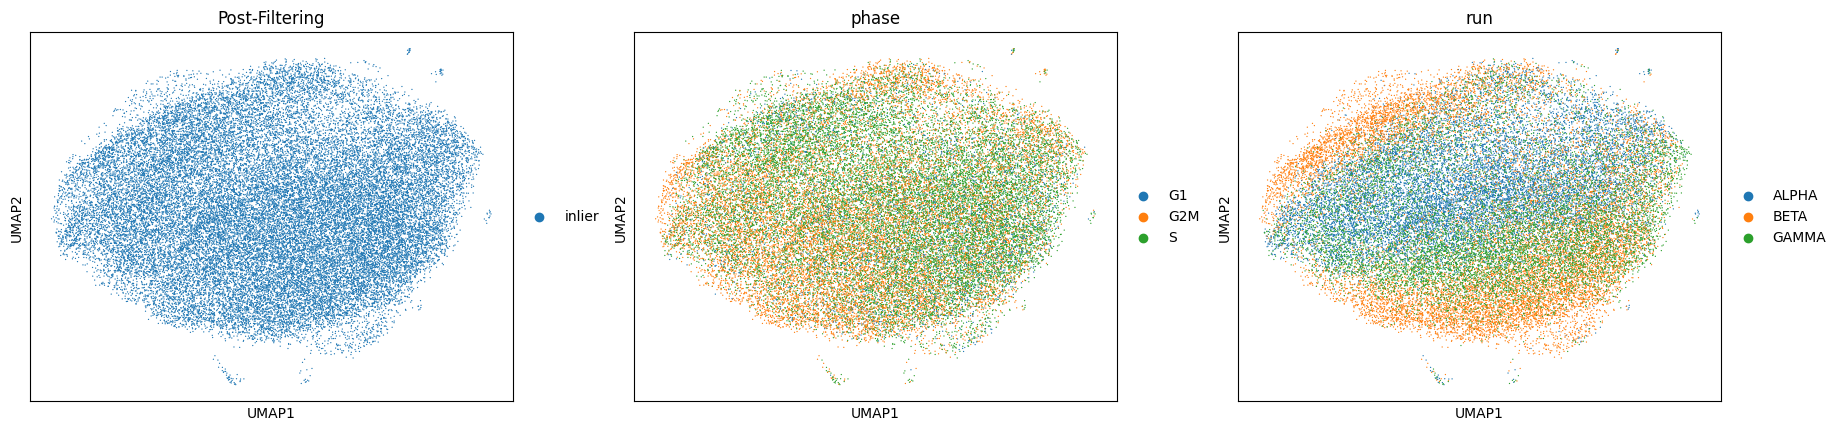

computing density on 'umap'
--> added
    'umap_density', densities (adata.obs)
    'umap_density_params', parameter (adata.uns)


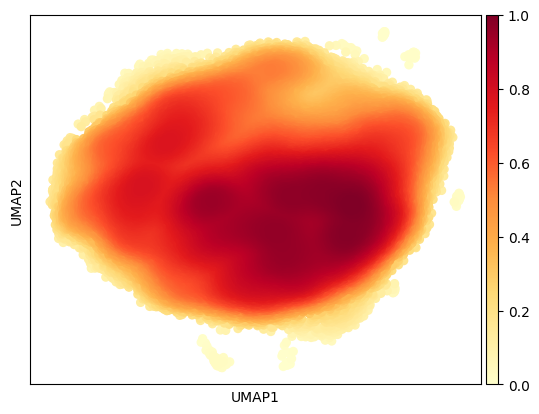

In [ ]:
step_d_pca_seed = 0
step_d_isolation_forest_seed = 123

ntc_adata = adata[adata.obs.perturbed=="False"].copy()
ntc_adata = ntc_adata[ntc_adata.obs.index.isin(qc2.scrub_ntc_random_seed(ntc_adata, 
                                                                         rand_seed_pca=step_d_pca_seed, 
                                                                         rand_seed_isolation_forest=step_d_isolation_forest_seed))]

In [ ]:
ntc_adata

View of AnnData object with n_obs × n_vars = 35229 × 32118
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'S_score', 'G2M_score', 'phase', 'is_outlier', 'umap_density'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca', 'neighbors', 'umap', 'is_outlier_colors', 'phase_colo

In [ ]:
ntc_adata.obs.run.value_counts()

run
ALPHA    13300
BETA     12769
GAMMA     9160
Name: count, dtype: int64

We have now isolated the core NTC cells. We will subset `adata` to only include perturbed cells and the core NTC cells.

In [ ]:
perturbed_mask = adata.obs.perturbed == "True"
valid_ntc_mask = adata.obs.index.isin(ntc_adata.obs.index)
adata = adata[perturbed_mask | valid_ntc_mask,:].copy()

In [ ]:
adata

AnnData object with n_obs × n_vars = 436779 × 32118
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'counts'

Save the file:

In [ ]:
adata.write("/home/ranwyl/data_tf_project/Aggregate_Core_NTC_TF_KD.h5ad")

Check that the number of NTC cells is correct:

In [ ]:
adata.obs.perturbed.value_counts()

perturbed
True     401550
False     35229
Name: count, dtype: int64

Plot cells per perturbation:

1578/1610 (98.01)% Perturbations have > 100 cells


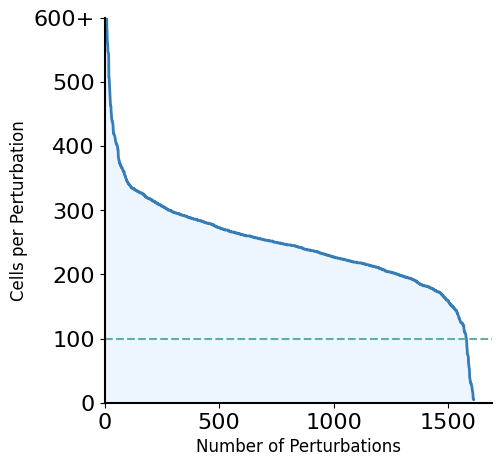

In [ ]:
f = qc2.plot_cells_per_perturbation(adata)

Plot UMIs per cell:

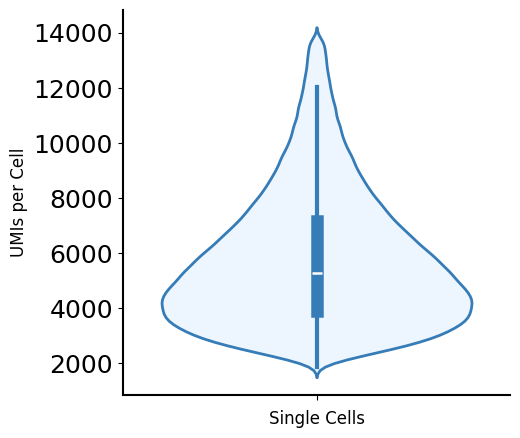

In [ ]:
f = qc2.plot_umis_per_cell(adata)

Remove invalid gene targets:

In [ ]:
gene_id_file_path = "/home/ranwyl/data_tf_project/gene_ids.txt"
qc2.assign_gene_ids(adata, gene_id_file_path)
adata = qc2.remove_invalid_gene_targets_in_place(adata,obs_key="gene_target_ensembl_id",var_key="gene_ids")

Split by run and save intermediate files:

In [ ]:
adata_alpha = adata[adata.obs.run=="ALPHA"].copy()
adata_alpha.write("/home/ranwyl/data_tf_project/Aggregate_ALPHA_TF_KD.h5ad")

In [ ]:
adata_beta = adata[adata.obs.run=="BETA"].copy()
adata_beta.write("/home/ranwyl/data_tf_project/Aggregate_BETA_TF_KD.h5ad")

In [ ]:
adata_gamma = adata[adata.obs.run=="GAMMA"].copy()
adata_gamma.write("/home/ranwyl/data_tf_project/Aggregate_GAMMA_TF_KD.h5ad")

In [ ]:
print(f"Cells per batch: ALPHA = {adata_alpha.shape[0]}, BETA = {adata_beta.shape[0]}, GAMMA = {adata_gamma.shape[0]}")

Cells per batch: ALPHA = 411135, BETA = 15315, GAMMA = 10329


Restart kernel

## Step E: Isolating effective sgRNA

**Step E with modified RNG functions (step D PCA random seed = 0)**

In the knockdown QC step, we will normalize counts per cell to 1M, remove sgRNA that do not induce mean >30% on-target knockdown, and remove unrepressed cells and sgRNA without at least 25 associated cells. We will read in each dataset and perform knockdown QC one at a time.

Perform knockdown QC:

In [ ]:
adata_alpha = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_TF_KD.h5ad")
adata_alpha

AnnData object with n_obs × n_vars = 411135 × 32118
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'counts'

In [ ]:
gene_targets_alpha = adata_alpha.obs.gene_target.unique().tolist()
print(f"Batch ALPHA has {len(gene_targets_alpha)-1} TF KDs")

Batch ALPHA has 1592 TF KDs


normalizing counts per cell
    finished (0:00:04)
3459 out of 4998 (69.21%) non-NTC sgRNAs have more than 30% knockdown.


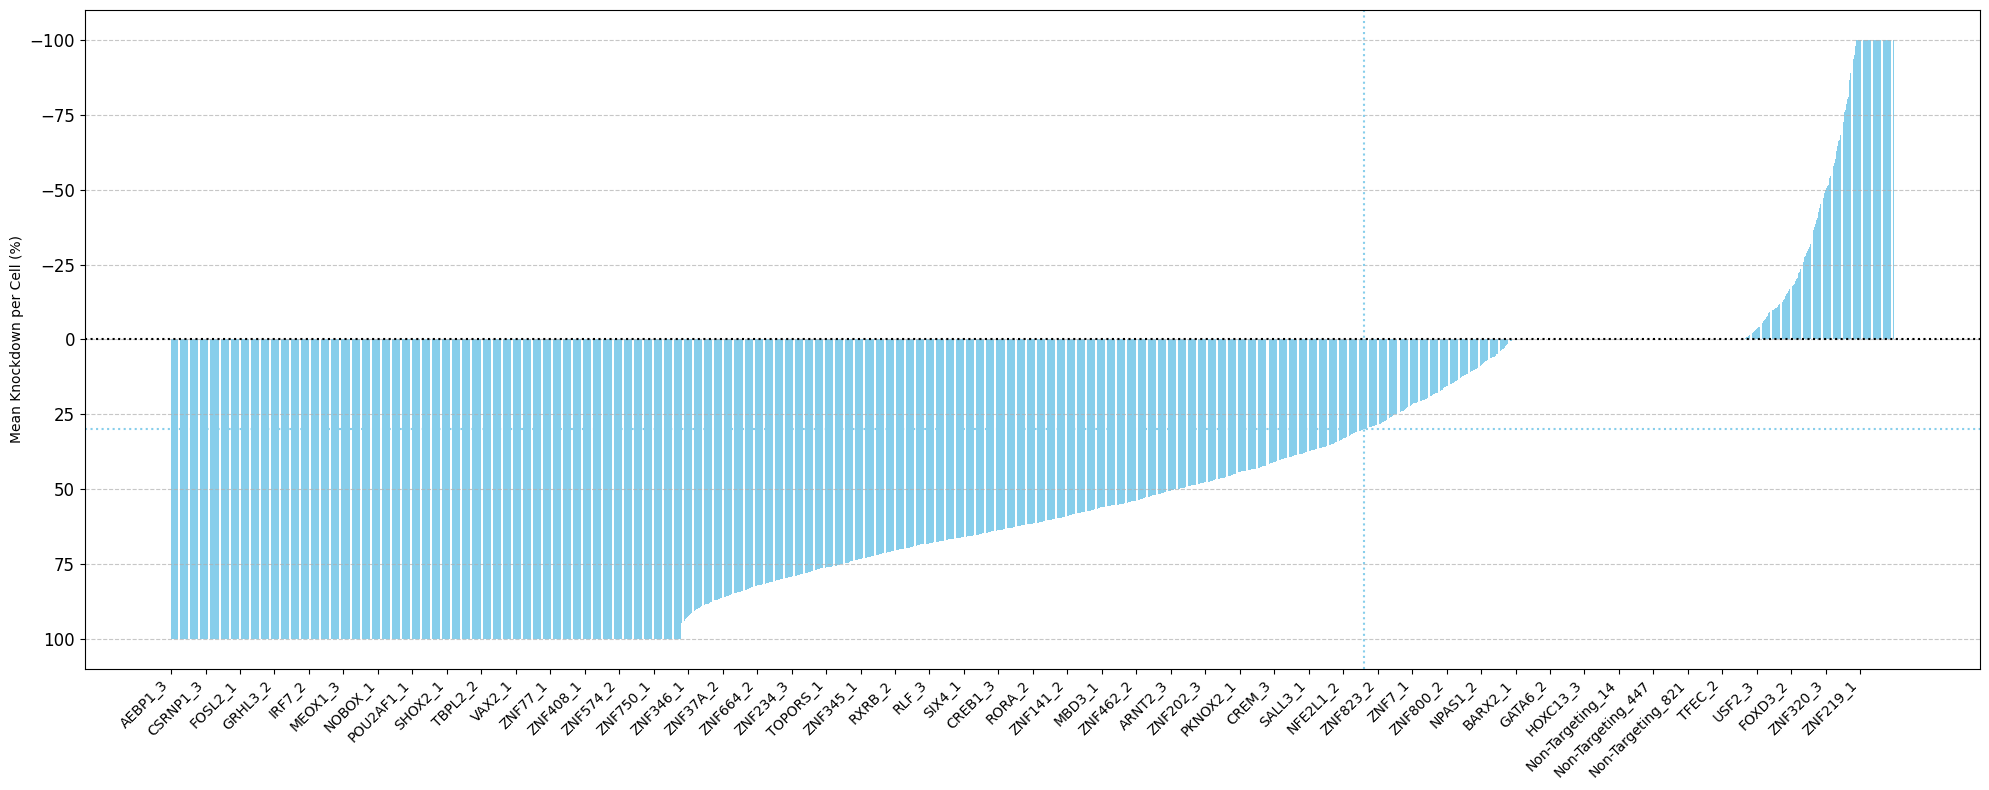

Removing 1303 perturbing sgRNA for not having more than 30% knockdown
Before filter: 4998,perturbed
True     397835
False     13300
Name: count, dtype: int64
After filter: 3695,perturbed
True     288863
False     13300
Name: count, dtype: int64
Removing 11845 perturbed cells for not having any measureable repression.
Before filter: 3695,perturbed
True     288863
False     13300
Name: count, dtype: int64
After filter: 3695,perturbed
True     277018
False     13300
Name: count, dtype: int64


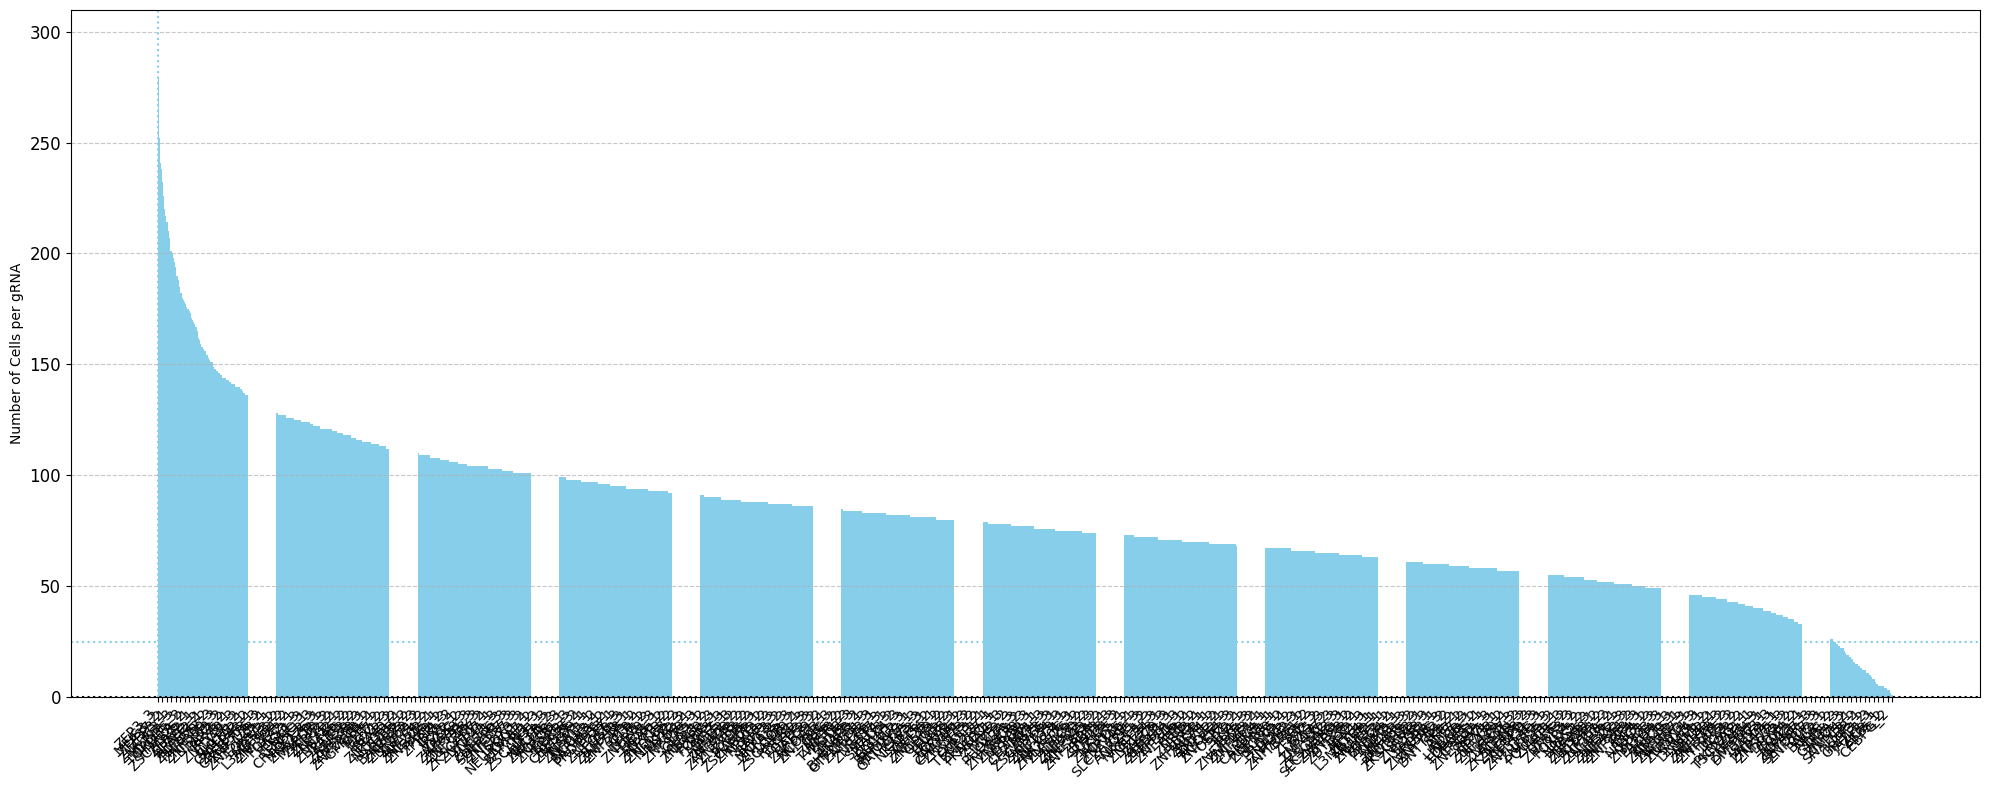

Before filter: 3695,perturbed
True     277018
False     13300
Name: count, dtype: int64
Removing 120 perturbing sgRNA for not having more than 25 cells
After filter: 3575,perturbed
True     275500
False     13300
Name: count, dtype: int64


In [ ]:
knockdown_adata_alpha = qc2.knockdown_qc(adata_alpha, 'gene_target_ensembl_id', 'gene_ids').copy()

In [ ]:
adata_beta = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_BETA_TF_KD.h5ad")
adata_beta

AnnData object with n_obs × n_vars = 15315 × 32118
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'counts'

In [ ]:
gene_targets_beta = adata_beta.obs.gene_target.unique().tolist()
print(gene_targets_beta)

['NTC', 'SNAPC5', 'ZBED5', 'AKAP8L', 'MTERF4', 'MSANTD4', 'TRAFD1', 'PIN1', 'DZIP1', 'RBCK1', 'NAIF1', 'CCDC17', 'ZBED6', 'PURB']


normalizing counts per cell
    finished (0:00:00)
33 out of 271 (12.18%) non-NTC sgRNAs have more than 30% knockdown.


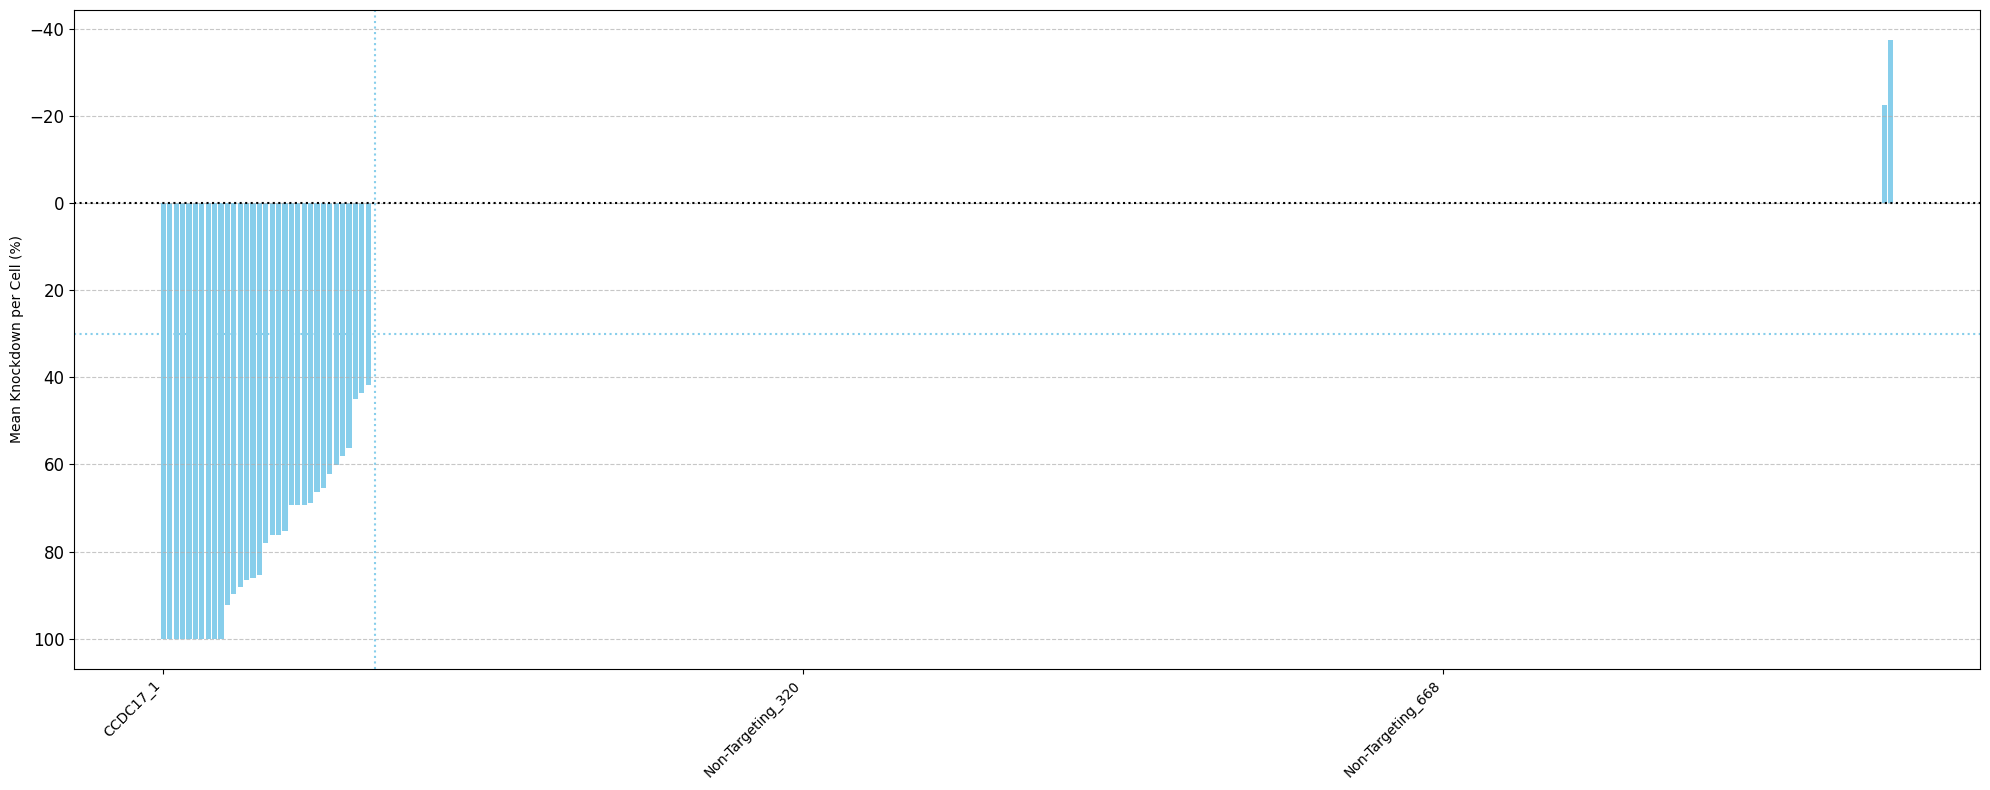

Removing 2 perturbing sgRNA for not having more than 30% knockdown
Before filter: 271,perturbed
False    12769
True      2546
Name: count, dtype: int64
After filter: 269,perturbed
False    12769
True      2475
Name: count, dtype: int64
Removing 111 perturbed cells for not having any measureable repression.
Before filter: 269,perturbed
False    12769
True      2475
Name: count, dtype: int64
After filter: 269,perturbed
False    12769
True      2364
Name: count, dtype: int64


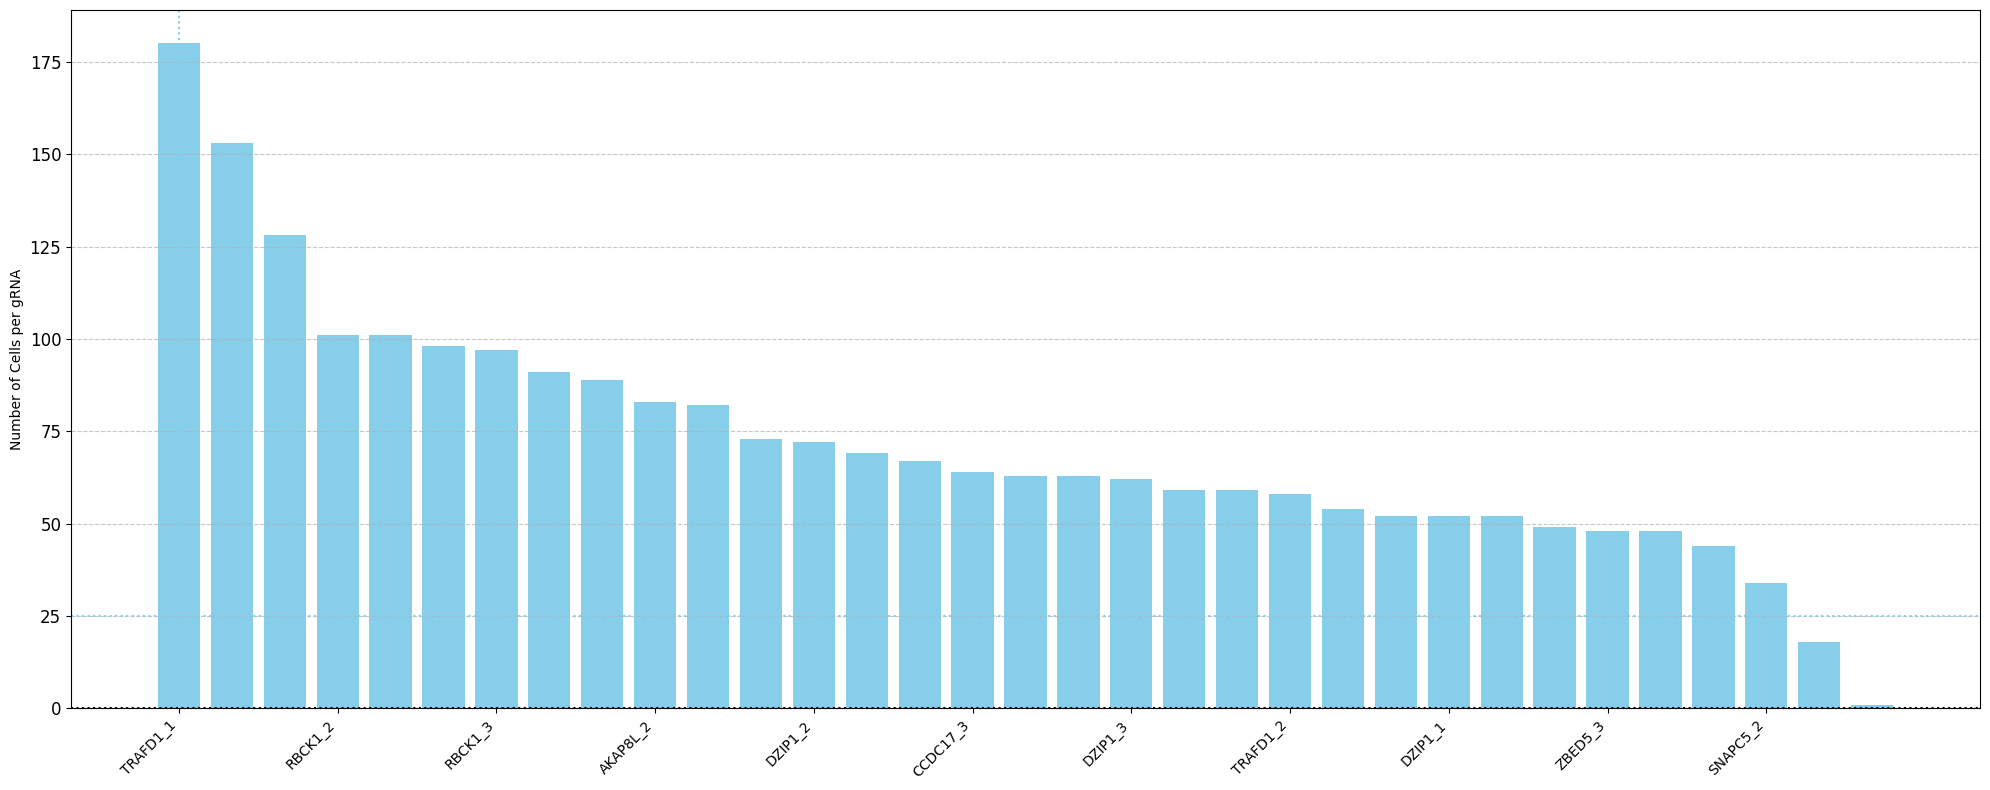

Before filter: 269,perturbed
False    12769
True      2364
Name: count, dtype: int64
Removing 2 perturbing sgRNA for not having more than 25 cells
After filter: 267,perturbed
False    12769
True      2345
Name: count, dtype: int64


In [ ]:
knockdown_adata_beta = qc2.knockdown_qc(adata_beta, 'gene_target_ensembl_id', 'gene_ids').copy()

In [ ]:
adata_gamma = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_GAMMA_TF_KD.h5ad")
adata_gamma

AnnData object with n_obs × n_vars = 10329 × 32118
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'counts'

In [ ]:
gene_targets_gamma = adata_gamma.obs.gene_target.unique().tolist()
print(gene_targets_gamma)

['NTC', 'FAM200B', 'THYN1', 'MSANTD3', 'PRR12', 'RBSN', 'ZBED6', 'SGSM2', 'MTERF2']


normalizing counts per cell
    finished (0:00:00)
22 out of 259 (8.49%) non-NTC sgRNAs have more than 30% knockdown.


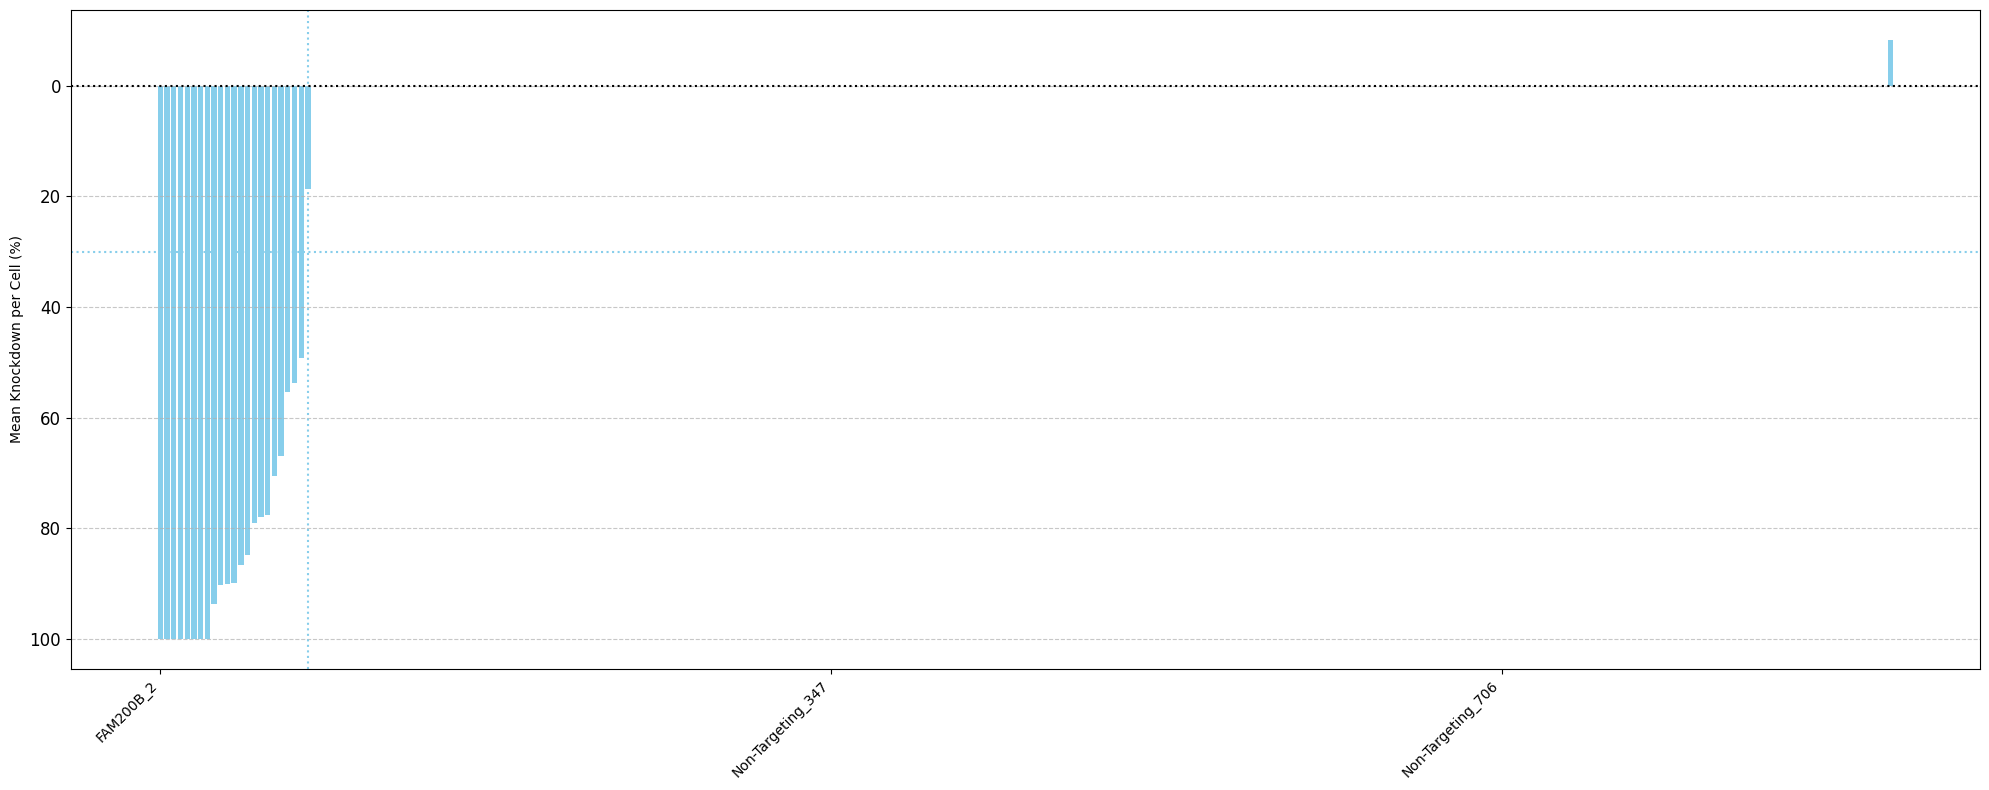

Removing 2 perturbing sgRNA for not having more than 30% knockdown
Before filter: 259,perturbed
False    9160
True     1169
Name: count, dtype: int64
After filter: 257,perturbed
False    9160
True     1103
Name: count, dtype: int64
Removing 33 perturbed cells for not having any measureable repression.
Before filter: 257,perturbed
False    9160
True     1103
Name: count, dtype: int64
After filter: 257,perturbed
False    9160
True     1070
Name: count, dtype: int64


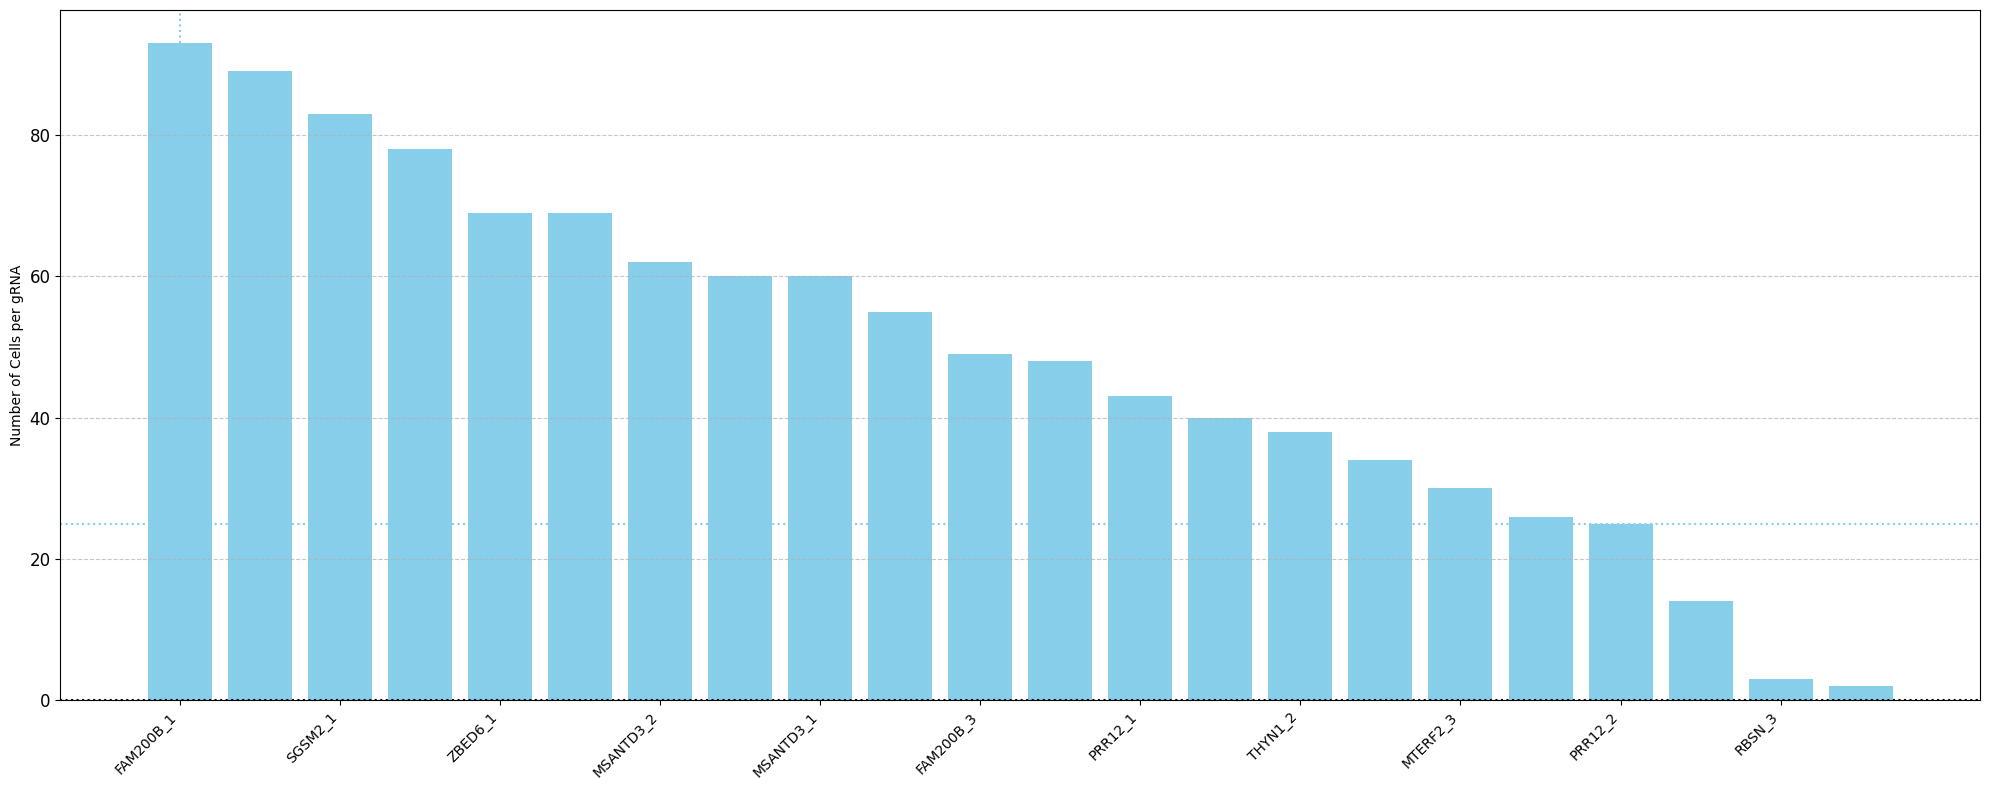

Before filter: 257,perturbed
False    9160
True     1070
Name: count, dtype: int64
Removing 4 perturbing sgRNA for not having more than 25 cells
After filter: 253,perturbed
False    9160
True     1026
Name: count, dtype: int64


In [ ]:
knockdown_adata_gamma = qc2.knockdown_qc(adata_gamma, 'gene_target_ensembl_id', 'gene_ids').copy()

1190/1613 (74%) perturbations achieve > 30% knockdown


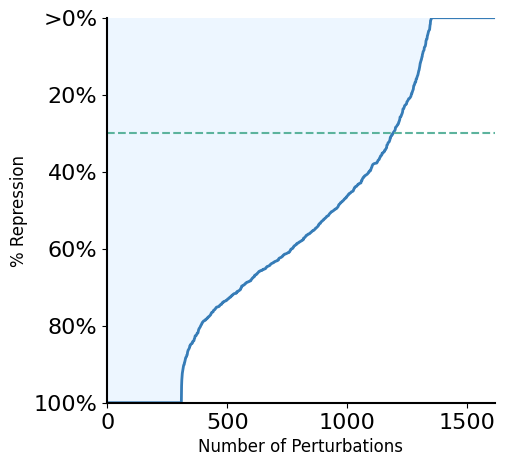

In [ ]:
alpha_knockdown = list(qc2._get_perturbed_view(adata_alpha).obs.groupby("gene_target")["target_knockdown"].mean())
beta_knockdown = list(qc2._get_perturbed_view(adata_beta).obs.groupby("gene_target")["target_knockdown"].mean())
gamma_knockdown = list(qc2._get_perturbed_view(adata_gamma).obs.groupby("gene_target")["target_knockdown"].mean())
total_knockdown = np.sort(np.clip(np.array(alpha_knockdown + beta_knockdown + gamma_knockdown),a_min=0,a_max=1))[::-1]
f = qc2.plot_percentage_perturbations_by_repression(total_knockdown)

Calculate median NTC number of UMI counts:

Note: median NTC UMI count was 4540 for full dataset (all KOs) and 4314.0 for TF KD and NTC dataset with 30%/100 cell gene filter

In [ ]:
median_NTC = np.median(list(qc2._get_ntc_view(knockdown_adata_alpha).obs.n_UMI_counts) 
                       + list(qc2._get_ntc_view(knockdown_adata_beta).obs.n_UMI_counts) 
                       + list(qc2._get_ntc_view(knockdown_adata_gamma).obs.n_UMI_counts))
print(median_NTC)

4557.0


In [ ]:
print(f"Cell numbers: Batch ALPHA = {knockdown_adata_alpha.shape[0]}, "
      f"BETA = {knockdown_adata_beta.shape[0]}, GAMMA = {knockdown_adata_gamma.shape[0]}")

Cell numbers: Batch ALPHA = 288800, BETA = 15114, GAMMA = 10186


Normalize, log1p transform, and scale data with target sum `median_NTC`, one dataset at a time.

ALPHA:

In [ ]:
sc.pp.normalize_total(knockdown_adata_alpha,target_sum=median_NTC)
sc.pp.log1p(knockdown_adata_alpha)
sc.pp.scale(knockdown_adata_alpha)

normalizing counts per cell
    finished (0:00:03)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [ ]:
knockdown_adata_alpha.write("/home/ranwyl/data_tf_project/step_E_output_ALPHA_TF_KD.h5ad")

BETA:

In [ ]:
sc.pp.normalize_total(knockdown_adata_beta,target_sum=median_NTC)
sc.pp.log1p(knockdown_adata_beta)
sc.pp.scale(knockdown_adata_beta)

normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [ ]:
knockdown_adata_beta.write("/home/ranwyl/data_tf_project/step_E_output_BETA_TF_KD.h5ad")

GAMMA:

In [ ]:
sc.pp.normalize_total(knockdown_adata_gamma,target_sum=median_NTC)
sc.pp.log1p(knockdown_adata_gamma)
sc.pp.scale(knockdown_adata_gamma)

normalizing counts per cell


    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [ ]:
knockdown_adata_gamma.write("/home/ranwyl/data_tf_project/step_E_output_GAMMA_TF_KD.h5ad")

Restart kernel

## Step F: Isolate sgRNA altering cell state and isolate perturbed cells

### Step F energy distance

First we perform sgRNA-level energy distance-based filtering on each of the 3 data subsets (using modified RNG functions)

**ALPHA:**

In [ ]:
# Settings for parallel processing with tqdm_joblib
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OMP_MAX_ACTIVE_LEVELS"] = "1"
os.environ["KMP_WARNINGS"] = "0"  # For Intel's OpenMP implementation

# Create numpy default_rng() RNG object
step_f_rand_seed = 1337
step_f_rng = np.random.default_rng(step_f_rand_seed)

In [ ]:
knockdown_adata_alpha = ad.read_h5ad("/home/ranwyl/data_tf_project/step_E_output_ALPHA_TF_KD.h5ad")
knockdown_adata_alpha

AnnData object with n_obs × n_vars = 288800 × 32118
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std'
    uns: 'log1p'
    layers: 'counts', 'normalized_counts'

In [ ]:
knockdown_adata_alpha.obs.perturbed.value_counts()

perturbed
True     275500
False     13300
Name: count, dtype: int64

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:06)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)
computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 50
    computed neighbors (0:00:16)
    computed connectivities (0:00:07)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:24)


Computing null distribution:   0%|          | 0/25 [00:00<?, ?it/s]

Computing group distances:   0%|          | 0/3340 [00:00<?, ?it/s]

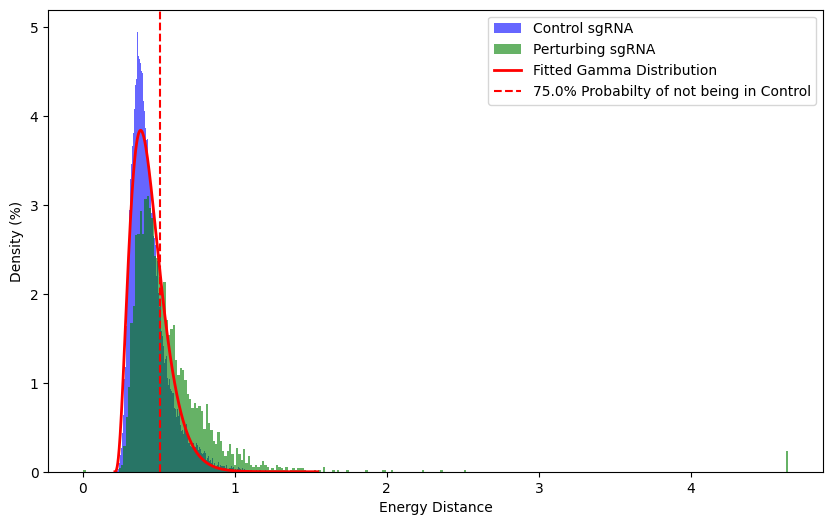

1577/3340 Perturbing sgRNA cross threshold of 0.75


In [ ]:
alpha_filtered, alpha_null_distances, alpha_results = qc2.filter_sgRNA_rng(knockdown_adata_alpha, cells_per_ko=25,
                                                                           rng=step_f_rng, n_jobs=25,
                                                                           n_permutations=50000)

In [ ]:
alpha_filtered = alpha_filtered.copy()
alpha_filtered

AnnData object with n_obs × n_vars = 141822 × 32118
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std'
    uns: 'log1p'
    layers: 'counts', 'normalized_counts'

In [ ]:
print(f"Batch ALPHA has {len(alpha_filtered.obs.gene_target.unique().tolist())-1} TF KDs")

Batch ALPHA has 1042 TF KDs


In [ ]:
alpha_filtered.write("/home/ranwyl/data_tf_project/Aggregate_ALPHA_sgRNA_Filtered_TF_KD.h5ad")

Restart kernel

**BETA:**

In [ ]:
# Settings for parallel processing with tqdm_joblib
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OMP_MAX_ACTIVE_LEVELS"] = "1"
os.environ["KMP_WARNINGS"] = "0"  # For Intel's OpenMP implementation

# Create numpy default_rng() RNG object
step_f_rand_seed = 1337
step_f_rng = np.random.default_rng(step_f_rand_seed)

In [ ]:
knockdown_adata_beta = ad.read_h5ad("/home/ranwyl/data_tf_project/step_E_output_BETA_TF_KD.h5ad")
knockdown_adata_beta

AnnData object with n_obs × n_vars = 15114 × 32118
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std'
    uns: 'log1p'
    layers: 'counts', 'normalized_counts'

In [ ]:
knockdown_adata_beta.obs.perturbed.value_counts()

perturbed
False    12769
True      2345
Name: count, dtype: int64

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)
computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 50
    computed neighbors (0:00:12)
    computed connectivities (0:00:02)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:15)


Computing null distribution:   0%|          | 0/25 [00:00<?, ?it/s]

Computing group distances:   0%|          | 0/32 [00:00<?, ?it/s]

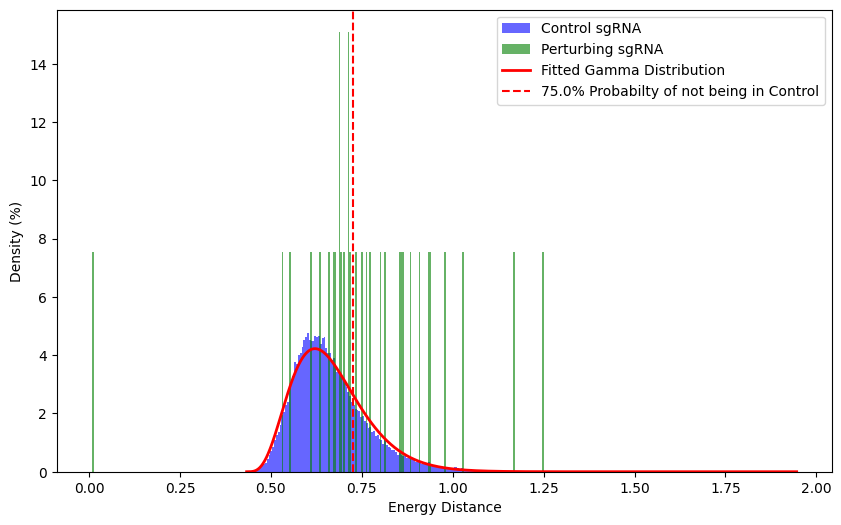

17/32 Perturbing sgRNA cross threshold of 0.75


In [ ]:
beta_filtered, beta_null_distances, beta_results = qc2.filter_sgRNA_rng(knockdown_adata_beta, rng=step_f_rng, 
                                                                        cells_per_ko=25, n_jobs=25, 
                                                                        n_permutations=50000)

In [ ]:
beta_filtered = beta_filtered.copy()
beta_filtered

AnnData object with n_obs × n_vars = 14097 × 32118
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std'
    uns: 'log1p'
    layers: 'counts', 'normalized_counts'

In [ ]:
print(f"Batch BETA has {len(beta_filtered.obs.gene_target.unique().tolist())-1} TF KDs")

Batch BETA has 12 TF KDs


In [ ]:
print(beta_filtered.obs.gene_target.unique().tolist())

['NTC', 'SNAPC5', 'AKAP8L', 'MTERF4', 'TRAFD1', 'PIN1', 'ZBED5', 'NAIF1', 'MSANTD4', 'ZBED6', 'RBCK1', 'CCDC17', 'DZIP1']


In [ ]:
beta_filtered.write("/home/ranwyl/data_tf_project/Aggregate_BETA_sgRNA_Filtered_TF_KD.h5ad")

Restart kernel

**GAMMA:**

In [ ]:
# Settings for parallel processing with tqdm_joblib
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OMP_MAX_ACTIVE_LEVELS"] = "1"
os.environ["KMP_WARNINGS"] = "0"  # For Intel's OpenMP implementation

# Create numpy default_rng() RNG object
step_f_rand_seed = 1337
step_f_rng = np.random.default_rng(step_f_rand_seed)

In [ ]:
knockdown_adata_gamma = ad.read_h5ad("/home/ranwyl/data_tf_project/step_E_output_GAMMA_TF_KD.h5ad")
knockdown_adata_gamma

AnnData object with n_obs × n_vars = 10186 × 32118
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std'
    uns: 'log1p'
    layers: 'counts', 'normalized_counts'

In [ ]:
knockdown_adata_gamma.obs.perturbed.value_counts()

perturbed
False    9160
True     1026
Name: count, dtype: int64

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)
computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 50


    computed neighbors (0:00:12)
    computed connectivities (0:00:02)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:14)


Computing null distribution:   0%|          | 0/25 [00:00<?, ?it/s]

Computing group distances:   0%|          | 0/19 [00:00<?, ?it/s]

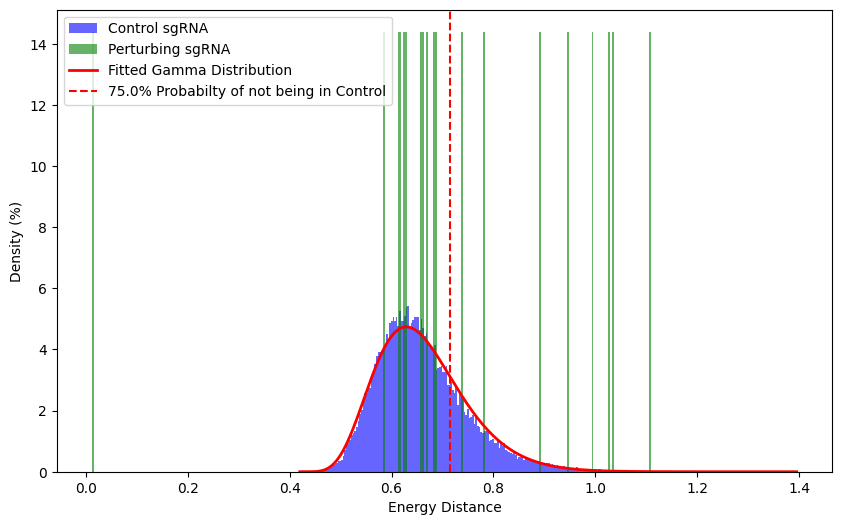

8/19 Perturbing sgRNA cross threshold of 0.75


In [ ]:
gamma_filtered, gamma_null_distances, gamma_results = qc2.filter_sgRNA_rng(knockdown_adata_gamma, rng=step_f_rng, 
                                                                           cells_per_ko=25, n_jobs=25,
                                                                           n_permutations=50000)

In [ ]:
gamma_filtered = gamma_filtered.copy()
gamma_filtered

AnnData object with n_obs × n_vars = 9667 × 32118
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std'
    uns: 'log1p'
    layers: 'counts', 'normalized_counts'

In [ ]:
print(f"Batch GAMMA has {len(gamma_filtered.obs.gene_target.unique().tolist())-1} TF KDs")

Batch GAMMA has 6 TF KDs


In [ ]:
print(gamma_filtered.obs.gene_target.unique().tolist())

['NTC', 'FAM200B', 'THYN1', 'PRR12', 'SGSM2', 'MSANTD3', 'ZBED6']


In [ ]:
gamma_filtered.write("/home/ranwyl/data_tf_project/Aggregate_GAMMA_sgRNA_Filtered_TF_KD.h5ad")

Restart kernel

### Step F SVM

Next, we remove unperturbed cells one data subset at a time using an SVM classifier. The SVM is trained on the PCA embedding of the dataset. KO cells that are classified as NTC cells by the SVM will be removed.

ALPHA:

In [ ]:
adata_alpha = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_sgRNA_Filtered_TF_KD.h5ad")
adata_alpha

AnnData object with n_obs × n_vars = 141822 × 32118
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std'
    uns: 'log1p'
    layers: 'counts', 'normalized_counts'

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:01)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:09)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


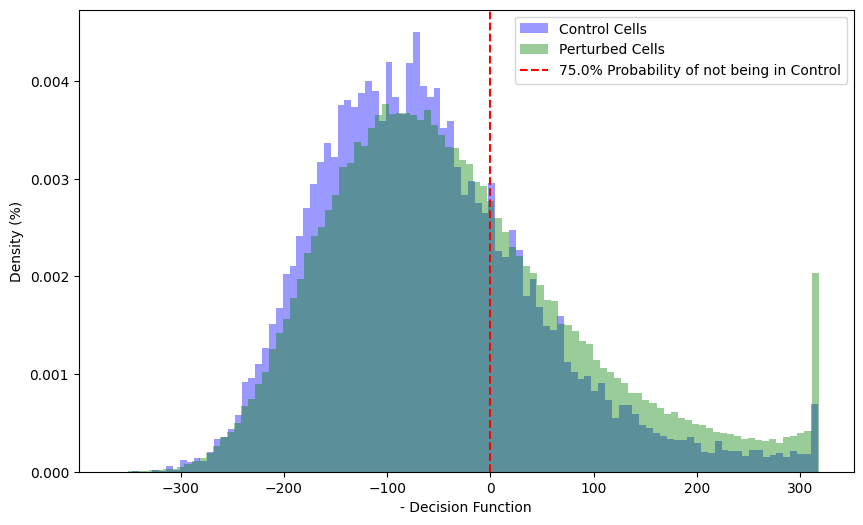

41604/128522 Perturbed Cells cross threshold of 0.75


In [ ]:
adata_alpha_filtered, c, p = qc2.remove_unperturbed_cells_random_seed(adata_alpha, threshold=0.75, rand_seed=0)

In [ ]:
perturbation_counts = dict(adata_alpha_filtered.obs.gene_target.value_counts())
remaining_perturbations = [k for k,v in perturbation_counts.items() if v >= 25]
print(f"{len(remaining_perturbations)} perturbations have at least 25 cells")

740 perturbations have at least 25 cells


In [ ]:
adata_alpha_filtered = qc2.remove_perturbations_by_cell_threshold(adata_alpha_filtered)

Removing 303 perturbations for having under 25 cells.


In [ ]:
adata_alpha_filtered

AnnData object with n_obs × n_vars = 49428 × 32118
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '

In [ ]:
print(f"Batch ALPHA has {len(adata_alpha_filtered.obs.gene_target.unique())-1} TF KDs")

Batch ALPHA has 739 TF KDs


In [ ]:
adata_alpha_filtered.write("/home/ranwyl/data_tf_project/Aggregate_ALPHA_Core_Cells_TF_KD.h5ad")

BETA:

In [ ]:
adata_beta = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_BETA_sgRNA_Filtered_TF_KD.h5ad")

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


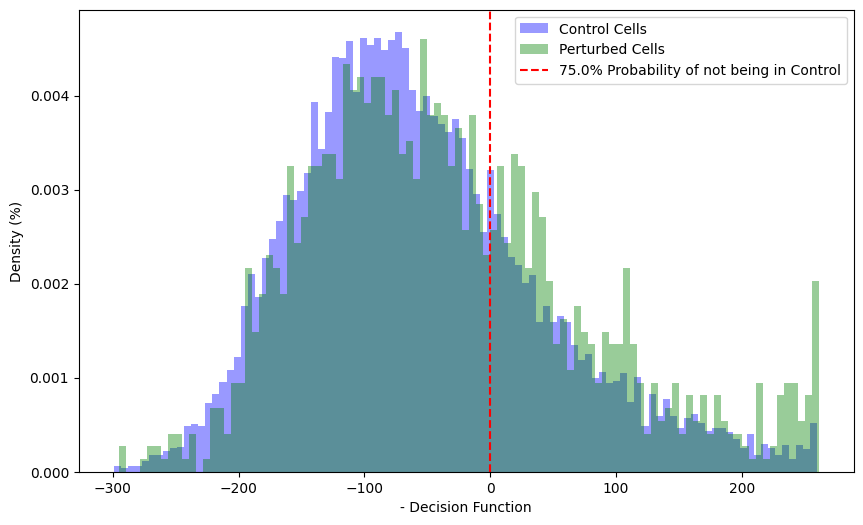

439/1328 Perturbed Cells cross threshold of 0.75


In [ ]:
adata_beta_filtered, c, p = qc2.remove_unperturbed_cells_random_seed(adata_beta, threshold=0.75, rand_seed=0)

In [ ]:
perturbation_counts = dict(adata_beta_filtered.obs.gene_target.value_counts())
remaining_perturbations = [k for k,v in perturbation_counts.items() if v >= 25]
print(f"{len(remaining_perturbations)} perturbations have at least 25 cells")

9 perturbations have at least 25 cells


In [ ]:
adata_beta_filtered = qc2.remove_perturbations_by_cell_threshold(adata_beta_filtered)

Removing 4 perturbations for having under 25 cells.


In [ ]:
adata_beta_filtered

AnnData object with n_obs × n_vars = 13130 × 32118
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '

In [ ]:
print(f"Batch BETA has {len(adata_beta_filtered.obs.gene_target.unique())-1} TF KDs")

Batch BETA has 8 TF KDs


In [ ]:
adata_beta_filtered.write("/home/ranwyl/data_tf_project/Aggregate_BETA_Core_Cells_TF_KD.h5ad")

GAMMA:

In [ ]:
adata_gamma = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_GAMMA_sgRNA_Filtered_TF_KD.h5ad")
adata_gamma

AnnData object with n_obs × n_vars = 9667 × 32118
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std'
    uns: 'log1p'
    layers: 'counts', 'normalized_counts'

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


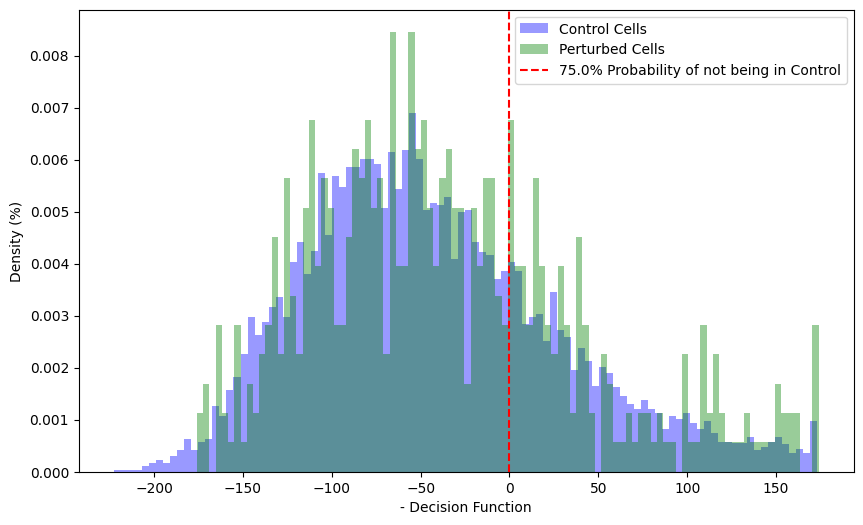

145/507 Perturbed Cells cross threshold of 0.75


In [ ]:
adata_gamma_filtered, c, p = qc2.remove_unperturbed_cells_random_seed(adata_gamma, threshold=0.75, rand_seed=0)

In [ ]:
perturbation_counts = dict(adata_gamma_filtered.obs.gene_target.value_counts())
remaining_perturbations = [k for k,v in perturbation_counts.items() if v >= 25]
print(f"{len(remaining_perturbations)} perturbations have at least 25 cells")

3 perturbations have at least 25 cells


In [ ]:
adata_gamma_filtered = qc2.remove_perturbations_by_cell_threshold(adata_gamma_filtered)

Removing 4 perturbations for having under 25 cells.


In [ ]:
adata_gamma_filtered

AnnData object with n_obs × n_vars = 9251 × 32118
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'l

In [ ]:
print(f"Batch GAMMA has {len(adata_gamma_filtered.obs.gene_target.unique())-1} TF KDs")

Batch GAMMA has 2 TF KDs


In [ ]:
adata_gamma_filtered.write("/home/ranwyl/data_tf_project/Aggregate_GAMMA_Core_Cells_TF_KD.h5ad")

### Venn diagrams - gene filters

Gene filter

In [3]:
adata_strict_alpha = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_Core_Cells_TF_KO.h5ad")
adata_strict_beta = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_BETA_Core_Cells_TF_KO.h5ad")
adata_strict = ad.concat([adata_strict_alpha, adata_strict_beta])
adata_strict

AnnData object with n_obs × n_vars = 77912 × 20200
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts'

In [4]:
adata_lenient_alpha = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_Core_Cells_TF_KD.h5ad")
adata_lenient_beta = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_BETA_Core_Cells_TF_KD.h5ad")
adata_lenient_gamma = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_GAMMA_Core_Cells_TF_KD.h5ad")
adata_lenient = ad.concat([adata_lenient_alpha, adata_lenient_beta, adata_lenient_gamma])
adata_lenient

AnnData object with n_obs × n_vars = 71809 × 32118
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts'

In [7]:
strict_kds = get_kds(adata_strict)
lenient_kds = get_kds(adata_lenient)

In [8]:
print(len(strict_kds))
print(len(lenient_kds))

975
749


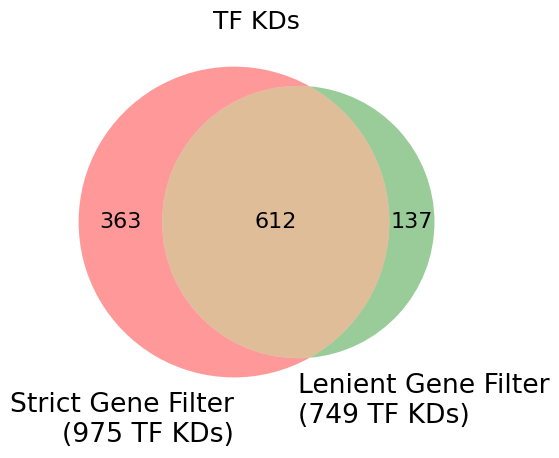

In [9]:
plot_venn2(strict_kds, lenient_kds, f"Strict Gene Filter\n({len(strict_kds)} TF KDs)", 
           f"Lenient Gene Filter\n({len(lenient_kds)} TF KDs)",
           title="TF KDs")

Gene filter - NTC cells in batch ALPHA

In [3]:
adata_strict_gene_filt = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_Core_Cells_TF_KO.h5ad", backed="r")
adata_lenient_gene_filt = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_Core_Cells_TF_KD.h5ad", backed="r")

In [ ]:
adata_strict_ntc = adata_strict_gene_filt[adata_strict_gene_filt.obs.gene_target == "NTC"]
adata_strict_ntc_barcodes = set(adata_strict_ntc.obs.index.tolist())
adata_lenient_ntc = adata_lenient_gene_filt[adata_lenient_gene_filt.obs.gene_target == "NTC"]
adata_lenient_ntc_barcodes = set(adata_lenient_ntc.obs.index.tolist())
print(f"Strict dataset has {len(adata_strict_ntc_barcodes)} cells "
      f"and lenient dataset has {len(adata_lenient_ntc_barcodes)} cells")
print(f"Strict and lenient datasets share {len(adata_strict_ntc_barcodes & adata_lenient_ntc_barcodes)} NTC cells")

In [ ]:
plot_venn2(adata_strict_ntc_barcodes, adata_lenient_ntc_barcodes, "Strict gene filter\n(13,842 NTC cells)", 
           "Lenient gene filter\n(13,244 NTC cells)", title="NTC cells")

# F25 Week 1 DE testing

In [ ]:
def generate_pseudoreplicates_for_DE(adata, gene_target, ntc_cells, rng, n_reps=2):
    """
    Generate n_reps independent (partitioned) pseudoreplicates for a given gene target 
    and matched NTC cells. Manually set NTC as reference for DE analysis.
    rng = numpy Generator object
    """
    data_matrix = adata.X
    target_indices = np.where(adata.obs['gene_target'] == gene_target)[0]
    target_bulk = []
    ntc_bulk = []
    sample_names = []
    control_names = []

    # Create gene target pseudoreplicates
    rep_size = len(target_indices) // n_reps
    sample_size = rep_size * n_reps
    sampled_target_indices = rng.choice(target_indices, sample_size, replace=False)
    for rep in range(n_reps):
        start, stop = rep*rep_size, (rep+1)*rep_size
        rep_indices = sampled_target_indices[start:stop]
        target_profile = data_matrix[rep_indices].sum(axis=0)
        target_bulk.append(target_profile)
        sample_names.append(f"{gene_target}_rep_{rep+1}")

    # Create NTC pseudoreplicates
    sampled_ntc_indices = rng.choice(ntc_cells, sample_size, replace=False)
    for rep in range(n_reps):
        start, stop = rep*rep_size, (rep+1)*rep_size
        rep_indices = sampled_ntc_indices[start:stop]
        ntc_profile = data_matrix[rep_indices].sum(axis=0)
        ntc_bulk.append(ntc_profile)
        control_names.append(f"NTC_rep_{rep+1}")
    
    # Convert to DataFrame
    sample_names.extend(control_names)
    # Build counts DataFrame
    pseudo_bulk_df = pd.DataFrame(np.vstack(target_bulk + ntc_bulk), index=sample_names, columns=adata.var_names)
    pseudo_bulk_df = pseudo_bulk_df[pseudo_bulk_df.columns[pseudo_bulk_df.sum(axis=0)>=1]] #Remove any samples with 0s in both NTC and Perturbed Sample
    # Build metadata DataFrame
    metadata_records = [{'condition': sample.split('_')[0]} for sample in sample_names]
    metadata_df = pd.DataFrame(metadata_records, index=sample_names)
    # Set NTC as reference
    metadata_df["condition"] = pd.Categorical(
        metadata_df["condition"],
        categories=["NTC", gene_target],
        ordered=True
        )

    return pseudo_bulk_df, metadata_df


def de_analysis(data, metadata, contrast, alpha=0.05, n_cpus=16):
    """
    Run differential expression analysis on a single gene target using PyDESeq2.
    """
    inference = DefaultInference(n_cpus=n_cpus) # Only use n_cpus CPUs
    
    # Read counts modeling and fitting dispersions
    dds = DeseqDataSet(
        counts = data, 
        metadata = metadata, 
        design="~condition",
        refit_cooks=True,
        inference=inference,
        quiet=True
        )
    dds.deseq2()
    
    # Statistical testing
    stat_res = DeseqStats(
        dds, 
        contrast=contrast, 
        alpha=alpha,
        inference=inference,
        quiet=True)
    stat_res.summary()
    # Shrink LFCs for downstream analysis
    stat_res.lfc_shrink(coeff=f"condition[T.{contrast[1]}]", adapt=False) 
    results = stat_res.results_df
    return results


def de_analysis_dataset(adata, n_cpus=16, n_reps=2, 
                        gene_target_obs_column="gene_target", ntc_cells_delimiter="NTC", 
                        alpha=0.05, de_rng=None):
    """
    Run differential expression analysis on each gene target in the dataset.
    """
    # Reset adata.X to raw counts
    adata.X = adata.layers["counts"].copy()

    # Identify KD and NTC cells
    ntc_cells = np.where(adata.obs[gene_target_obs_column] == ntc_cells_delimiter)[0]
    gene_targets = list(adata.obs[gene_target_obs_column].unique())
    gene_targets.remove(ntc_cells_delimiter)  # Remove the control group
    n_gene_targets = len(gene_targets)

    # Create RNG object to handle case where one is not provided
    if de_rng is None:
        hard_coded_seed = 42
        de_rng = np.random.default_rng(hard_coded_seed)
    # Create one child RNG object per gene target
    streams = de_rng.spawn(n_gene_targets)

    # Function to run DE analysis on a single gene target
    def process_gene_target(gene_target, rng):
        pseudo_bulk_df, metadata_df = generate_pseudoreplicates_for_DE(
            adata, gene_target, ntc_cells, rng=rng, n_reps=n_reps
        )
        return de_analysis(
            pseudo_bulk_df, 
            metadata_df, 
            contrast=["condition", gene_target, ntc_cells_delimiter], 
            alpha=alpha,
            n_cpus=n_cpus)

    # Run DE analysis on all gene targets in parallel
    with tqdm_joblib(desc="Running DE analysis", total=len(gene_targets)):
        results = Parallel(n_jobs=n_cpus)(
            delayed(process_gene_target)(gene_target, rng) for gene_target, rng in zip(gene_targets, streams))
    
    results_dict = dict(zip(gene_targets, results))
    
    return results_dict

def build_de_df(results_dict):
    df_list = list()
    for gene_target, df in results_dict.items():
        df = df.sort_index() # Sort genes alphabetically
        # Prepend TF KO name to each column label
        new_col_names = {col: f"{gene_target}_{col}" for col in df}
        df = df.rename(columns=new_col_names)
        df_list.append(df)
    # Concatenate all DE result DataFrames (using intersection of genes)
    de_df = pd.concat(df_list, axis=1)
    de_df = de_df.sort_index() # Sort genes alphabetically
    return de_df

def build_deg_df(de_df, tf_kd, lfc_threshold=0, padj_threshold=0.05):
    tf_kd_cols = de_df.columns[de_df.columns.str.contains(tf_kd)]
    tf_kd_df = de_df[tf_kd_cols]
    tf_kd_deg_df = tf_kd_df[(abs(tf_kd_df[f"{tf_kd}_log2FoldChange"]) > lfc_threshold) 
                            & (tf_kd_df[f"{tf_kd}_padj"] < padj_threshold)]
    return tf_kd_deg_df

In [ ]:
adata_alpha = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_Core_Cells_TF_KO.h5ad")
adata_beta = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_BETA_Core_Cells_TF_KO.h5ad")
print(f"Total cells per batch: ALPHA {adata_alpha.shape[0]}, BETA {adata_beta.shape[0]}")

Total cells per batch: ALPHA 65308, BETA 12604


In [ ]:
test_gene_targets = ["POU5F1", "NANOG", "NTC"]
adata_test = adata_alpha[adata_alpha.obs.gene_target.isin(test_gene_targets)].copy()
adata_test

AnnData object with n_obs × n_vars = 14034 × 20200
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '

In [ ]:
adata_test.obs.gene_target.unique().tolist()

['NTC', 'POU5F1', 'NANOG']

In [ ]:
adata_test[adata_test.obs.gene_target == "POU5F1"].shape[0]

96

In [ ]:
adata_test[adata_test.obs.gene_target == "NANOG"].shape[0]

96

In [ ]:
results_dict_test_2reps = de_analysis_dataset(adata_test, n_cpus=25, n_reps=2)

Running DE analysis:   0%|          | 0/2 [00:00<?, ?it/s]

/home/ranwyl/pymde_env/lib64/python3.11/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
/home/ranwyl/pymde_env/lib64/python3.11/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
/home/ranwyl/pymde_env/lib64/python3.11/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()


In [ ]:
test_de_df_2reps = build_de_df(results_dict_test_2reps)
test_de_df_2reps.head()

POU5F1_baseMean  POU5F1_log2FoldChange  POU5F1_lfcSE  POU5F1_stat  \
A1BG             3.971359              -0.315204      1.012120    -0.635116   
A1BG-AS1         0.229447               0.154118      1.967397     0.309621   
A2M              0.498122              -0.019972      1.281926    -0.057165   
A2M-AS1          0.229447               0.154118      1.967397     0.309621   
A2ML1            1.524100              -0.519355      1.206868    -1.133351   

          POU5F1_pvalue  POU5F1_padj  NANOG_baseMean  NANOG_log2FoldChange  \
A1BG           0.525353          NaN        2.959269             -0.182179   
A1BG-AS1       0.756849          NaN        0.986616             -0.010507   
A2M            0.954413          NaN             NaN                   NaN   
A2M-AS1        0.756849          NaN        0.239337              0.100094   
A2ML1          0.257067          NaN        1.985454             -0.216242   

          NANOG_lfcSE  NANOG_stat  NANOG_pvalue  NANOG_padj  
A1BG         1.008075   -0.376555      0.706505         NaN  
A1BG-AS1     1.227681   -0.028067      0.977609         NaN  
A2M               NaN         NaN           NaN         NaN  
A2M-AS1      2.483595    0.261954      0.793357         NaN  
A2ML1        1.079070   -0.473599      0.635786         NaN

In [ ]:
pou5f1_df_2reps = build_deg_df(test_de_df_2reps, "POU5F1", lfc_threshold=0)
print(pou5f1_df_2reps.shape[0])
nanog_df_2reps = build_deg_df(test_de_df_2reps, "NANOG", lfc_threshold=0)
print(nanog_df_2reps.shape[0])

18
41


In [ ]:
results_dict_test_3reps = de_analysis_dataset(adata_test, n_cpus=25, n_reps=3)

Running DE analysis:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
test_de_df_3reps = build_de_df(results_dict_test_3reps)
test_de_df_3reps.head()

POU5F1_baseMean  POU5F1_log2FoldChange  POU5F1_lfcSE  POU5F1_stat  \
A1BG             2.638843              -0.426730      0.892003    -0.801785   
A1BG-AS1         0.149793               0.122497      2.188104     0.185412   
A2M              0.321964              -0.017672      1.315148    -0.044368   
A2M-AS1          0.154794               0.123601      2.192710     0.185412   
A2ML1            1.014696              -0.541940      1.209727    -1.124439   

          POU5F1_pvalue  POU5F1_padj  NANOG_baseMean  NANOG_log2FoldChange  \
A1BG           0.422677          NaN        1.954981             -0.215939   
A1BG-AS1       0.852906          NaN        0.645030             -0.015579   
A2M            0.964611          NaN             NaN                   NaN   
A2M-AS1        0.852906          NaN        0.153256              0.126667   
A2ML1          0.260827          NaN        1.316343             -0.242587   

          NANOG_lfcSE  NANOG_stat  NANOG_pvalue  NANOG_padj  
A1BG         0.973807   -0.432866      0.665112         NaN  
A1BG-AS1     1.188210   -0.037305      0.970242         NaN  
A2M               NaN         NaN           NaN         NaN  
A2M-AS1      2.179549    0.205352      0.837297         NaN  
A2ML1        1.043105   -0.506768      0.612318         NaN

In [ ]:
pou5f1_df_3reps = build_deg_df(test_de_df_3reps, "POU5F1", lfc_threshold=0)
print(pou5f1_df_3reps.shape[0])
nanog_df_3reps = build_deg_df(test_de_df_3reps, "NANOG", lfc_threshold=0)
print(nanog_df_3reps.shape[0])

443
64


Remove genes expressed in <100 cells

In [ ]:
adata = ad.concat([adata_alpha, adata_beta])
adata

AnnData object with n_obs × n_vars = 77912 × 20200
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts'

In [ ]:
adata_genes_filt = adata.copy()
sc.pp.filter_genes(adata_genes_filt, min_cells=100)

filtered out 311 genes that are detected in less than 100 cells


In [ ]:
adata_genes_filt

AnnData object with n_obs × n_vars = 77912 × 19889
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'n_cells'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts'

In [ ]:
adata_alpha_filt = adata_genes_filt[adata_genes_filt.obs.run == "ALPHA"].copy()
adata_beta_filt = adata_genes_filt[adata_genes_filt.obs.run == "BETA"].copy()

In [ ]:
test_gene_targets = ["POU5F1", "NANOG", "NTC"]
adata_test_filt = adata_alpha_filt[adata_alpha_filt.obs.gene_target.isin(test_gene_targets)].copy()
adata_test_filt

AnnData object with n_obs × n_vars = 14034 × 19889
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'n_cells'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts'

In [ ]:
results_dict_test_2reps_filt = de_analysis_dataset(adata_test_filt, n_cpus=25, n_reps=2)

Running DE analysis:   0%|          | 0/2 [00:00<?, ?it/s]

/home/ranwyl/pymde_env/lib64/python3.11/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
/home/ranwyl/pymde_env/lib64/python3.11/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
/home/ranwyl/pymde_env/lib64/python3.11/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()


In [ ]:
test_de_df_2reps_filt = build_de_df(results_dict_test_2reps_filt)
pou5f1_df_2reps = build_deg_df(test_de_df_2reps_filt, "POU5F1", lfc_threshold=0)
print(pou5f1_df_2reps.shape[0])
nanog_df_2reps = build_deg_df(test_de_df_2reps_filt, "NANOG", lfc_threshold=0)
print(nanog_df_2reps.shape[0])

19
41


In [ ]:
results_dict_test_3reps_filt = de_analysis_dataset(adata_test_filt, n_cpus=25, n_reps=3)

Running DE analysis:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
test_de_df_3reps_filt = build_de_df(results_dict_test_3reps_filt)
pou5f1_df_3reps = build_deg_df(test_de_df_3reps_filt, "POU5F1", lfc_threshold=0)
print(pou5f1_df_3reps.shape[0])
nanog_df_3reps = build_deg_df(test_de_df_3reps_filt, "NANOG", lfc_threshold=0)
print(nanog_df_3reps.shape[0])

446
64


Batch BETA

In [ ]:
def build_deg_df(de_df, tf_kd, lfc_threshold=0, padj_threshold=0.05):
    tf_kd_cols = de_df.columns[de_df.columns.str.contains(tf_kd)]
    tf_kd_df = de_df[tf_kd_cols]
    tf_kd_deg_df = tf_kd_df[(abs(tf_kd_df[f"{tf_kd}_log2FoldChange"]) > lfc_threshold) 
                            & (tf_kd_df[f"{tf_kd}_padj"] < padj_threshold)]
    return tf_kd_deg_df

def count_degs(de_df, tf_kd, lfc_threshold=0, padj_threshold=0.05):
    deg_df = build_deg_df(de_df, tf_kd, lfc_threshold, padj_threshold)
    return deg_df.shape[0]

def count_degs_for_tf_kd_list(de_df, tf_kd_list, lfc_threshold=0, padj_threshold=0.05):
    for tf_kd in tf_kd_list:
        n_degs = count_degs(de_df, tf_kd, lfc_threshold, padj_threshold)
        if n_degs == 1:
            print(f"{tf_kd} has {n_degs} DEG")
        else:
            print(f"{tf_kd} has {n_degs} DEGs")

In [ ]:
beta_kds = adata_beta_filt.obs.gene_target.unique().to_list()
beta_kds.remove("NTC")
print(f"Batch BETA has {len(beta_kds)} unique TF KDs")

Batch BETA has 7 unique TF KDs


In [ ]:
print(f"Batch BETA TF KDs: {', '.join(beta_kds)}")

Batch BETA TF KDs: SNAPC5, TRAFD1, RBCK1, NAIF1, MTERF4, PIN1, ZBED6


In [ ]:
beta_filt_cells_per_kd = adata_beta_filt.obs.gene_target.value_counts()
beta_filt_cells_per_kd = beta_filt_cells_per_kd.drop("NTC")
beta_filt_cells_per_kd

gene_target
PIN1      78
TRAFD1    77
RBCK1     52
SNAPC5    51
NAIF1     33
MTERF4    32
ZBED6     26
Name: count, dtype: int64

In [ ]:
results_dict_beta = de_analysis_dataset(adata_beta_filt, n_cpus=25, n_reps=2)

Running DE analysis:   0%|          | 0/7 [00:00<?, ?it/s]

/home/ranwyl/pymde_env/lib64/python3.11/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
/home/ranwyl/pymde_env/lib64/python3.11/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
/home/ranwyl/pymde_env/lib64/python3.11/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
/home/ranwyl/pymde_env/lib64/python3.11/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be p

In [ ]:
beta_DE_df = build_de_df(results_dict_beta)

In [ ]:
beta_DE_df.head()

SNAPC5_baseMean  SNAPC5_log2FoldChange  SNAPC5_lfcSE  SNAPC5_stat  \
A1BG             2.090794               0.657907      1.613191     1.318879   
A1BG-AS1              NaN                    NaN           NaN          NaN   
A2M              0.690982               0.285339      2.327042     0.769845   
A2M-AS1          0.232651               0.094468      2.500232     0.235438   
A2ML1            1.469387               0.126239      1.343993     0.337321   

          SNAPC5_pvalue  SNAPC5_padj  TRAFD1_baseMean  TRAFD1_log2FoldChange  \
A1BG           0.187210      0.99514         3.235310              -0.259582   
A1BG-AS1            NaN          NaN         0.252513               0.097314   
A2M            0.441392      0.99514         1.239847               0.083991   
A2M-AS1        0.813869      0.99514              NaN                    NaN   
A2ML1          0.735875      0.99514         2.630036               0.178879   

          TRAFD1_lfcSE  TRAFD1_stat  ...  PIN1_lfcSE  PIN1_stat  PIN1_pvalue  \
A1BG          1.013076    -0.531073  ...    0.953159   0.174302     0.861628   
A1BG-AS1      2.543327     0.262381  ...    2.238469   0.638538     0.523123   
A2M           1.278528     0.219586  ...    1.446661   0.345858     0.729449   
A2M-AS1            NaN          NaN  ...    2.485085   0.284172     0.776278   
A2ML1         1.150894     0.385241  ...    2.238469   0.638538     0.523123   

          PIN1_padj  ZBED6_baseMean  ZBED6_log2FoldChange  ZBED6_lfcSE  \
A1BG       0.997742        1.999285             -0.548611     1.104251   
A1BG-AS1   0.997742             NaN                   NaN          NaN   
A2M        0.997742        0.506277             -0.338132     1.194558   
A2M-AS1    0.997742        0.234035             -0.102118     1.109997   
A2ML1      0.997742        0.529991             -0.008621     1.307980   

          ZBED6_stat  ZBED6_pvalue  ZBED6_padj  
A1BG       -1.047380      0.294925    0.998534  
A1BG-AS1         NaN           NaN         NaN  
A2M        -0.749747      0.453407    0.998534  
A2M-AS1    -0.277981      0.781027    0.998534  
A2ML1      -0.025116      0.979963    0.998534  

[5 rows x 42 columns]

In [ ]:
count_degs_for_tf_kd_list(beta_DE_df, beta_kds)

SNAPC5 has 0 DEGs
TRAFD1 has 0 DEGs
RBCK1 has 0 DEGs
NAIF1 has 0 DEGs
MTERF4 has 1 DEG
PIN1 has 0 DEGs
ZBED6 has 0 DEGs


In [ ]:
results_dict_beta_3reps = de_analysis_dataset(adata_beta_filt, n_cpus=25, n_reps=3)

Running DE analysis:   0%|          | 0/7 [00:00<?, ?it/s]

/home/ranwyl/pymde_env/lib64/python3.11/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)


In [ ]:
beta_DE_df_3reps = build_de_df(results_dict_beta)

In [ ]:
count_degs_for_tf_kd_list(beta_DE_df_3reps, beta_kds)

SNAPC5 has 0 DEGs
TRAFD1 has 0 DEGs
RBCK1 has 0 DEGs
NAIF1 has 0 DEGs
MTERF4 has 1 DEG
PIN1 has 0 DEGs
ZBED6 has 0 DEGs


# Fall Week 2

Which TFs are in each batch

In [2]:
adata = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_Basic_QC_Cell_QC.h5ad")
adata.obs["run"] = [label.split('-')[0] for label in adata.obs.channel]

In [3]:
# List of 1639 TFs from Lambert et al (2018)
lambert_csv = pd.read_csv("Lambert_2018_TFs.csv")
lambert_tfs = lambert_csv[lambert_csv.iloc[:,3] == "Yes"].iloc[:,1].tolist()
lambert_tfs = set(lambert_tfs)

In [4]:
adata_alpha = adata[adata.obs.run == "ALPHA"]
adata_beta = adata[adata.obs.run == "BETA"]
adata_gamma = adata[adata.obs.run == "GAMMA"]

In [5]:
alpha_perts = adata_alpha.obs.gene_target.unique().tolist()
beta_perts = adata_beta.obs.gene_target.unique().tolist()
gamma_perts = adata_gamma.obs.gene_target.unique().tolist()

In [6]:
alpha_tf_perts = set(alpha_perts) & lambert_tfs
beta_tf_perts = set(beta_perts) & lambert_tfs
gamma_tf_perts = set(gamma_perts) & lambert_tfs
print(f"TF KDs per dataset pre-QC: ALPHA = {len(alpha_tf_perts)}, BETA = {len(beta_tf_perts)}, "
    f"GAMMA = {len(gamma_tf_perts)}")

TF KDs per dataset pre-QC: ALPHA = 1592, BETA = 13, GAMMA = 8


In [8]:
print(", ".join(beta_tf_perts))

CCDC17, MSANTD4, SNAPC5, ZBED5, MTERF4, NAIF1, AKAP8L, PURB, RBCK1, ZBED6, PIN1, TRAFD1, DZIP1


In [9]:
print(", ".join(gamma_tf_perts))

FAM200B, MTERF2, MSANTD3, PRR12, SGSM2, THYN1, ZBED6, RBSN


In [3]:
adata = sc.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_Basic_QC_Cell_QC.h5ad", backed="r")

In [5]:
adata

AnnData object with n_obs × n_vars = 2502888 × 37567 backed at '/home/ranwyl/data_tf_project/Aggregate_Basic_QC_Cell_QC.h5ad'
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [12]:
# List of 1639 TFs from Lambert et al (2018)
lambert_csv = pd.read_csv("Lambert_2018_TFs.csv")
lambert_tfs = lambert_csv[lambert_csv.iloc[:,3] == "Yes"].iloc[:,1].tolist()
lambert_tfs = set(lambert_tfs)

In [9]:
adata_alpha = adata[adata.obs.channel.str.startswith("ALPHA")]
adata_alpha.obs.perturbed.value_counts()

perturbed
True     841102
False     76692
Name: count, dtype: int64

In [18]:
adata_alpha_tf_kd_cells = adata[(adata.obs.gene_target.isin(lambert_tfs)) &
                               (adata.obs.channel.str.startswith("ALPHA")) ]
adata_alpha_tf_kd_cells.shape[0]

397835

In [10]:
adata_beta = adata[adata.obs.channel.str.startswith("BETA")]
adata_beta.obs.perturbed.value_counts()

perturbed
True     884371
False     36557
Name: count, dtype: int64

In [16]:
adata_beta_tf_kd_cells = adata[(adata.obs.gene_target.isin(lambert_tfs)) &
                               (adata.obs.channel.str.startswith("BETA")) ]
adata_beta_tf_kd_cells.shape[0]

2546

In [11]:
adata_gamma = adata[adata.obs.channel.str.startswith("GAMMA")]
adata_gamma.obs.perturbed.value_counts()

perturbed
True     639141
False     25025
Name: count, dtype: int64

In [17]:
adata_gamma_tf_kd_cells = adata[(adata.obs.gene_target.isin(lambert_tfs)) &
                               (adata.obs.channel.str.startswith("GAMMA")) ]
adata_gamma_tf_kd_cells.shape[0]

1169